In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp
import random
import os

FRAC_ADMIT = 0.5


In [6]:


###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test_large.csv')
df['key'] = df['R'].astype(str) + "_"  + df['T'].astype(str)



In [7]:
df_train = pd.read_csv('./df_train.csv')
df_stratum_utility = df_train[['R','T','Y']].groupby(['R','T']).mean().reset_index()
df_stratum_utility['stratum_utility'] = df_stratum_utility['Y'] 
df_stratum_utility['key'] = df_stratum_utility['R'].astype(str) + "_" + df_stratum_utility['T'].astype(str)

df = df.merge(df_stratum_utility[['stratum_utility','key']], on='key')
df['ml_outcomes'] = df['stratum_utility']

In [8]:
FRAC_ADMIT = 0.5#df[['A']].sum()/len(df)


In [9]:
TOTAL_ADMITS = int(len(df)*FRAC_ADMIT)
MAX_BLACK_ADMITS = len(df[df['R']==1])
MIN_GRADUATES = 100000
GRID_SIZE = 1000

outcomes_grid = []
Xs = []
Ys = []

for N_black_admits in range(0,MAX_BLACK_ADMITS):
    
    if N_black_admits % GRID_SIZE != 0:
        continue
    
    black_admits = df[df['R']==1].sort_values(by='T',ascending=False).head(n=N_black_admits)
    white_admits = df[df['R']==0].sort_values(by='T',ascending=False).head(n=TOTAL_ADMITS-N_black_admits)
    
    Y = black_admits['Y'].sum() + white_admits['Y'].sum()
    
    Xs.append(N_black_admits)
    Ys.append(Y)
    print(N_black_admits,Y)
    
    for y_iter in np.arange(MIN_GRADUATES,Y,GRID_SIZE):
        outcomes_grid.append({'min_black_admits':N_black_admits-GRID_SIZE/2, 'max_black_admits':N_black_admits+GRID_SIZE/2, 'max_graduates':y_iter+GRID_SIZE, 'min_graduates':y_iter, 'policy_exists':'Unknown'})
        

0 292727
1000 293296
2000 293843
3000 294349
4000 294802
5000 295230
6000 295649
7000 296056
8000 296503
9000 296899
10000 297279
11000 297608
12000 297984
13000 298366
14000 298683
15000 299052
16000 299370
17000 299701
18000 300000
19000 300286
20000 300621
21000 300901
22000 301169
23000 301426
24000 301701
25000 301922
26000 302190
27000 302463
28000 302703
29000 302921
30000 303166
31000 303429
32000 303662
33000 303795
34000 304003
35000 304205
36000 304398
37000 304581
38000 304794
39000 304999
40000 305171
41000 305375
42000 305568
43000 305731
44000 305871
45000 306003
46000 306174
47000 306344
48000 306459
49000 306588
50000 306677
51000 306780
52000 306852
53000 306973
54000 307127
55000 307270
56000 307404
57000 307504
58000 307630
59000 307771
60000 307881
61000 308000
62000 308099
63000 308173
64000 308242
65000 308299
66000 308385
67000 308412
68000 308486
69000 308508
70000 308521
71000 308536
72000 308593
73000 308654
74000 308704
75000 308708
76000 308768
77000 308775

In [10]:
df_pareto = pd.DataFrame({'# Black Admits':Xs, '# Graduates':Ys})

dff = df[['R','T','Y']].groupby(['R','T']).count().reset_index()
dff.columns = ['R','T','N']
dff['key'] = dff['R'].astype(str) + "_" + dff['T'].astype(str)
dff2 = df[['R','T','Y']].groupby(['R','T']).mean().reset_index()
dff2.columns = ['R','T','Y']
dff2['key'] = dff['R'].astype(str) + "_" + dff['T'].astype(str)

dff = dff.merge(dff2[['key','Y']],on='key')

In [11]:
###
## Get boards passage probability in each stratum
###

df_prob = df[['R','T','Y']].groupby(['R','T']).mean().reset_index()
df_prob.columns = ['R','T','ml_outcomes_prob']
dff = dff.merge(df_prob[['ml_outcomes_prob']],left_index=True,right_index=True)


In [12]:
dff['Pr(X=X_j)'] = dff['N']/(dff['N']).sum()

In [13]:
df_decisions = None
max_utility = -1.0
solutions = 0

for C_y in np.linspace(0.0,1.0,101):
    
    print(C_y)
    
    dff['alpha_j'] = dff['Pr(X=X_j)']* (dff['ml_outcomes_prob'] - C_y)
    solver = pywraplp.Solver.CreateSolver('GLOP')

    
    applicant_stratum = []
    vars_cache = {}
    alpha_j = {}
    
    # Objective: Maximize the expected utility of the admitted students
    objective = solver.Objective()
    
    # For each stratum
    for ix, row in dff.iterrows():
        # probability of admission
        numvar = solver.NumVar(0.0, 1.0, str(ix))
        
        # store variable by index, and also by stratum R, T
        applicant_stratum.append(numvar)
        vars_cache[(row['R'],row['T'])] = numvar
        
        alpha_j[(row['R'],row['T'])] = row['alpha_j']
        
        # Benefit of admitting people is total utility in that stratum
        objective.SetCoefficient(applicant_stratum[ix], float(row['N']))
        
    objective.SetMaximization()

    # Constraint: At most K applicants
    K = int(len(df)*FRAC_ADMIT)
    admit_quota = solver.Constraint(0, K)
    
    # Total admits cannot exceed K 
    for ix, row in dff.iterrows():
        admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
    

    constrain_graduate = solver.Constraint(0, 0)
    
    for ix, row in dff.iterrows():
        
        key = (row['R'],row['T'])
        n_graduate = row['Y'] * row['N']
        constrain_graduate.SetCoefficient(vars_cache[key], float(n_graduate))
    
    constrain_black_admit = solver.Constraint(0, 0)
    
    for ix, row in dff.iterrows():
        key = (row['R'],row['T'])
        n_black = row['R'] * row['N']
        constrain_black_admit.SetCoefficient(vars_cache[key], float(n_black))

    
    
    sum_alpha = 0
    R = 1 
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_minority = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_minority.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )    
    
    sum_alpha = 0
    R = 0
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_majority = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_majority.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )
        
    count = 0 
    
    print ('Total grid cells to check: {}'.format(len(outcomes_grid)))
    
    for region in outcomes_grid:
        constrain_graduate.SetBounds(float(region['min_graduates']), float(region['max_graduates']))
        constrain_black_admit.SetBounds(float(region['min_black_admits']), float(region['max_black_admits']))
        status = solver.Solve()
        count+=1
        
        if count % 1000 ==0:
            print ('Total grid cells checked so far: {}/{}, Solutions: {}'.format(count,len(outcomes_grid),solutions))


        if status == 0:
            
            if region['policy_exists'] != 1:
                solutions+=1
            
            region['policy_exists'] = 1
            row = []
            admit = []
    
            for i in applicant_stratum:
                row.append(int(str(i)))
                admit.append(i.solution_value())
            #df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
            region['policy'] = (row,admit)    
        else:
            continue
            #print(status)
            



0.0
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions:

Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions:

Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions:

Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.09
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells che

Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.11
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so

Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions:

Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions:

Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions:

Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.2
Total grid cells to check: 63022
Total grid cells ch

Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.22
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so

Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 

Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions:

Total grid cells checked so far: 33000/63022, Solutions: 136
Total grid cells checked so far: 34000/63022, Solutions: 136
Total grid cells checked so far: 35000/63022, Solutions: 136
Total grid cells checked so far: 36000/63022, Solutions: 136
Total grid cells checked so far: 37000/63022, Solutions: 136
Total grid cells checked so far: 38000/63022, Solutions: 136
Total grid cells checked so far: 39000/63022, Solutions: 136
Total grid cells checked so far: 40000/63022, Solutions: 136
Total grid cells checked so far: 41000/63022, Solutions: 136
Total grid cells checked so far: 42000/63022, Solutions: 136
Total grid cells checked so far: 43000/63022, Solutions: 136
Total grid cells checked so far: 44000/63022, Solutions: 136
Total grid cells checked so far: 45000/63022, Solutions: 136
Total grid cells checked so far: 46000/63022, Solutions: 136
Total grid cells checked so far: 47000/63022, Solutions: 136
Total grid cells checked so far: 48000/63022, Solutions: 136
Total grid cells checked

Total grid cells checked so far: 41000/63022, Solutions: 1613
Total grid cells checked so far: 42000/63022, Solutions: 1613
Total grid cells checked so far: 43000/63022, Solutions: 1613
Total grid cells checked so far: 44000/63022, Solutions: 1613
Total grid cells checked so far: 45000/63022, Solutions: 1613
Total grid cells checked so far: 46000/63022, Solutions: 1613
Total grid cells checked so far: 47000/63022, Solutions: 1613
Total grid cells checked so far: 48000/63022, Solutions: 1613
Total grid cells checked so far: 49000/63022, Solutions: 1613
Total grid cells checked so far: 50000/63022, Solutions: 1613
Total grid cells checked so far: 51000/63022, Solutions: 1613
Total grid cells checked so far: 52000/63022, Solutions: 1613
Total grid cells checked so far: 53000/63022, Solutions: 1613
Total grid cells checked so far: 54000/63022, Solutions: 1613
Total grid cells checked so far: 55000/63022, Solutions: 1613
Total grid cells checked so far: 56000/63022, Solutions: 1613
Total gr

Total grid cells checked so far: 47000/63022, Solutions: 4851
Total grid cells checked so far: 48000/63022, Solutions: 4851
Total grid cells checked so far: 49000/63022, Solutions: 4851
Total grid cells checked so far: 50000/63022, Solutions: 4851
Total grid cells checked so far: 51000/63022, Solutions: 4851
Total grid cells checked so far: 52000/63022, Solutions: 4851
Total grid cells checked so far: 53000/63022, Solutions: 4851
Total grid cells checked so far: 54000/63022, Solutions: 4851
Total grid cells checked so far: 55000/63022, Solutions: 4851
Total grid cells checked so far: 56000/63022, Solutions: 4851
Total grid cells checked so far: 57000/63022, Solutions: 4851
Total grid cells checked so far: 58000/63022, Solutions: 4851
Total grid cells checked so far: 59000/63022, Solutions: 4851
Total grid cells checked so far: 60000/63022, Solutions: 4851
Total grid cells checked so far: 61000/63022, Solutions: 4851
Total grid cells checked so far: 62000/63022, Solutions: 4851
Total gr

Total grid cells checked so far: 53000/63022, Solutions: 8683
Total grid cells checked so far: 54000/63022, Solutions: 8683
Total grid cells checked so far: 55000/63022, Solutions: 8683
Total grid cells checked so far: 56000/63022, Solutions: 8683
Total grid cells checked so far: 57000/63022, Solutions: 8683
Total grid cells checked so far: 58000/63022, Solutions: 8683
Total grid cells checked so far: 59000/63022, Solutions: 8683
Total grid cells checked so far: 60000/63022, Solutions: 8683
Total grid cells checked so far: 61000/63022, Solutions: 8683
Total grid cells checked so far: 62000/63022, Solutions: 8683
Total grid cells checked so far: 63000/63022, Solutions: 8683
0.35000000000000003
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 8683
Total grid cells checked so far: 2000/63022, Solutions: 8683
Total grid cells checked so far: 3000/63022, Solutions: 8683
Total grid cells checked so far: 4000/63022, Solutions: 8683
Total grid cells chec

Total grid cells checked so far: 57000/63022, Solutions: 13094
Total grid cells checked so far: 58000/63022, Solutions: 13094
Total grid cells checked so far: 59000/63022, Solutions: 13094
Total grid cells checked so far: 60000/63022, Solutions: 13094
Total grid cells checked so far: 61000/63022, Solutions: 13094
Total grid cells checked so far: 62000/63022, Solutions: 13094
Total grid cells checked so far: 63000/63022, Solutions: 13094
0.37
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 13094
Total grid cells checked so far: 2000/63022, Solutions: 13094
Total grid cells checked so far: 3000/63022, Solutions: 13094
Total grid cells checked so far: 4000/63022, Solutions: 13094
Total grid cells checked so far: 5000/63022, Solutions: 13094
Total grid cells checked so far: 6000/63022, Solutions: 13094
Total grid cells checked so far: 7000/63022, Solutions: 13094
Total grid cells checked so far: 8000/63022, Solutions: 13094
Total grid cells checked 

Total grid cells checked so far: 61000/63022, Solutions: 18111
Total grid cells checked so far: 62000/63022, Solutions: 18111
Total grid cells checked so far: 63000/63022, Solutions: 18111
0.39
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 18111
Total grid cells checked so far: 2000/63022, Solutions: 18111
Total grid cells checked so far: 3000/63022, Solutions: 18111
Total grid cells checked so far: 4000/63022, Solutions: 18111
Total grid cells checked so far: 5000/63022, Solutions: 18111
Total grid cells checked so far: 6000/63022, Solutions: 18111
Total grid cells checked so far: 7000/63022, Solutions: 18111
Total grid cells checked so far: 8000/63022, Solutions: 18111
Total grid cells checked so far: 9000/63022, Solutions: 18111
Total grid cells checked so far: 10000/63022, Solutions: 18111
Total grid cells checked so far: 11000/63022, Solutions: 18111
Total grid cells checked so far: 12000/63022, Solutions: 18111
Total grid cells checked s

Total grid cells checked so far: 2000/63022, Solutions: 23775
Total grid cells checked so far: 3000/63022, Solutions: 23775
Total grid cells checked so far: 4000/63022, Solutions: 23775
Total grid cells checked so far: 5000/63022, Solutions: 23775
Total grid cells checked so far: 6000/63022, Solutions: 23775
Total grid cells checked so far: 7000/63022, Solutions: 23775
Total grid cells checked so far: 8000/63022, Solutions: 23775
Total grid cells checked so far: 9000/63022, Solutions: 23775
Total grid cells checked so far: 10000/63022, Solutions: 23775
Total grid cells checked so far: 11000/63022, Solutions: 23775
Total grid cells checked so far: 12000/63022, Solutions: 23775
Total grid cells checked so far: 13000/63022, Solutions: 23775
Total grid cells checked so far: 14000/63022, Solutions: 23775
Total grid cells checked so far: 15000/63022, Solutions: 23775
Total grid cells checked so far: 16000/63022, Solutions: 23775
Total grid cells checked so far: 17000/63022, Solutions: 23775


Total grid cells checked so far: 6000/63022, Solutions: 29869
Total grid cells checked so far: 7000/63022, Solutions: 29869
Total grid cells checked so far: 8000/63022, Solutions: 29869
Total grid cells checked so far: 9000/63022, Solutions: 29869
Total grid cells checked so far: 10000/63022, Solutions: 29869
Total grid cells checked so far: 11000/63022, Solutions: 29869
Total grid cells checked so far: 12000/63022, Solutions: 29869
Total grid cells checked so far: 13000/63022, Solutions: 29869
Total grid cells checked so far: 14000/63022, Solutions: 29869
Total grid cells checked so far: 15000/63022, Solutions: 29869
Total grid cells checked so far: 16000/63022, Solutions: 29869
Total grid cells checked so far: 17000/63022, Solutions: 29869
Total grid cells checked so far: 18000/63022, Solutions: 29869
Total grid cells checked so far: 19000/63022, Solutions: 29869
Total grid cells checked so far: 20000/63022, Solutions: 29869
Total grid cells checked so far: 21000/63022, Solutions: 29

Total grid cells checked so far: 10000/63022, Solutions: 35575
Total grid cells checked so far: 11000/63022, Solutions: 35575
Total grid cells checked so far: 12000/63022, Solutions: 35575
Total grid cells checked so far: 13000/63022, Solutions: 35575
Total grid cells checked so far: 14000/63022, Solutions: 35575
Total grid cells checked so far: 15000/63022, Solutions: 35575
Total grid cells checked so far: 16000/63022, Solutions: 35575
Total grid cells checked so far: 17000/63022, Solutions: 35575
Total grid cells checked so far: 18000/63022, Solutions: 35575
Total grid cells checked so far: 19000/63022, Solutions: 35575
Total grid cells checked so far: 20000/63022, Solutions: 35575
Total grid cells checked so far: 21000/63022, Solutions: 35575
Total grid cells checked so far: 22000/63022, Solutions: 35575
Total grid cells checked so far: 23000/63022, Solutions: 35575
Total grid cells checked so far: 24000/63022, Solutions: 35575
Total grid cells checked so far: 25000/63022, Solutions

Total grid cells checked so far: 14000/63022, Solutions: 40606
Total grid cells checked so far: 15000/63022, Solutions: 40606
Total grid cells checked so far: 16000/63022, Solutions: 40606
Total grid cells checked so far: 17000/63022, Solutions: 40606
Total grid cells checked so far: 18000/63022, Solutions: 40606
Total grid cells checked so far: 19000/63022, Solutions: 40606
Total grid cells checked so far: 20000/63022, Solutions: 40606
Total grid cells checked so far: 21000/63022, Solutions: 40606
Total grid cells checked so far: 22000/63022, Solutions: 40606
Total grid cells checked so far: 23000/63022, Solutions: 40606
Total grid cells checked so far: 24000/63022, Solutions: 40606
Total grid cells checked so far: 25000/63022, Solutions: 40606
Total grid cells checked so far: 26000/63022, Solutions: 40606
Total grid cells checked so far: 27000/63022, Solutions: 40606
Total grid cells checked so far: 28000/63022, Solutions: 40606
Total grid cells checked so far: 29000/63022, Solutions

Total grid cells checked so far: 18000/63022, Solutions: 43831
Total grid cells checked so far: 19000/63022, Solutions: 43831
Total grid cells checked so far: 20000/63022, Solutions: 43831
Total grid cells checked so far: 21000/63022, Solutions: 43831
Total grid cells checked so far: 22000/63022, Solutions: 43831
Total grid cells checked so far: 23000/63022, Solutions: 43831
Total grid cells checked so far: 24000/63022, Solutions: 43831
Total grid cells checked so far: 25000/63022, Solutions: 43831
Total grid cells checked so far: 26000/63022, Solutions: 43831
Total grid cells checked so far: 27000/63022, Solutions: 43831
Total grid cells checked so far: 28000/63022, Solutions: 43831
Total grid cells checked so far: 29000/63022, Solutions: 43831
Total grid cells checked so far: 30000/63022, Solutions: 43831
Total grid cells checked so far: 31000/63022, Solutions: 43831
Total grid cells checked so far: 32000/63022, Solutions: 43831
Total grid cells checked so far: 33000/63022, Solutions

Total grid cells checked so far: 22000/63022, Solutions: 45090
Total grid cells checked so far: 23000/63022, Solutions: 45090
Total grid cells checked so far: 24000/63022, Solutions: 45090
Total grid cells checked so far: 25000/63022, Solutions: 45090
Total grid cells checked so far: 26000/63022, Solutions: 45090
Total grid cells checked so far: 27000/63022, Solutions: 45090
Total grid cells checked so far: 28000/63022, Solutions: 45090
Total grid cells checked so far: 29000/63022, Solutions: 45090
Total grid cells checked so far: 30000/63022, Solutions: 45090
Total grid cells checked so far: 31000/63022, Solutions: 45090
Total grid cells checked so far: 32000/63022, Solutions: 45090
Total grid cells checked so far: 33000/63022, Solutions: 45090
Total grid cells checked so far: 34000/63022, Solutions: 45090
Total grid cells checked so far: 35000/63022, Solutions: 45090
Total grid cells checked so far: 36000/63022, Solutions: 45090
Total grid cells checked so far: 37000/63022, Solutions

Total grid cells checked so far: 26000/63022, Solutions: 45090
Total grid cells checked so far: 27000/63022, Solutions: 45090
Total grid cells checked so far: 28000/63022, Solutions: 45090
Total grid cells checked so far: 29000/63022, Solutions: 45090
Total grid cells checked so far: 30000/63022, Solutions: 45090
Total grid cells checked so far: 31000/63022, Solutions: 45090
Total grid cells checked so far: 32000/63022, Solutions: 45090
Total grid cells checked so far: 33000/63022, Solutions: 45090
Total grid cells checked so far: 34000/63022, Solutions: 45090
Total grid cells checked so far: 35000/63022, Solutions: 45090
Total grid cells checked so far: 36000/63022, Solutions: 45090
Total grid cells checked so far: 37000/63022, Solutions: 45090
Total grid cells checked so far: 38000/63022, Solutions: 45090
Total grid cells checked so far: 39000/63022, Solutions: 45090
Total grid cells checked so far: 40000/63022, Solutions: 45090
Total grid cells checked so far: 41000/63022, Solutions

Total grid cells checked so far: 30000/63022, Solutions: 45090
Total grid cells checked so far: 31000/63022, Solutions: 45090
Total grid cells checked so far: 32000/63022, Solutions: 45090
Total grid cells checked so far: 33000/63022, Solutions: 45090
Total grid cells checked so far: 34000/63022, Solutions: 45090
Total grid cells checked so far: 35000/63022, Solutions: 45090
Total grid cells checked so far: 36000/63022, Solutions: 45090
Total grid cells checked so far: 37000/63022, Solutions: 45090
Total grid cells checked so far: 38000/63022, Solutions: 45090
Total grid cells checked so far: 39000/63022, Solutions: 45090
Total grid cells checked so far: 40000/63022, Solutions: 45090
Total grid cells checked so far: 41000/63022, Solutions: 45090
Total grid cells checked so far: 42000/63022, Solutions: 45090
Total grid cells checked so far: 43000/63022, Solutions: 45090
Total grid cells checked so far: 44000/63022, Solutions: 45090
Total grid cells checked so far: 45000/63022, Solutions

Total grid cells checked so far: 34000/63022, Solutions: 45090
Total grid cells checked so far: 35000/63022, Solutions: 45090
Total grid cells checked so far: 36000/63022, Solutions: 45090
Total grid cells checked so far: 37000/63022, Solutions: 45090
Total grid cells checked so far: 38000/63022, Solutions: 45090
Total grid cells checked so far: 39000/63022, Solutions: 45090
Total grid cells checked so far: 40000/63022, Solutions: 45090
Total grid cells checked so far: 41000/63022, Solutions: 45090
Total grid cells checked so far: 42000/63022, Solutions: 45090
Total grid cells checked so far: 43000/63022, Solutions: 45090
Total grid cells checked so far: 44000/63022, Solutions: 45090
Total grid cells checked so far: 45000/63022, Solutions: 45090
Total grid cells checked so far: 46000/63022, Solutions: 45090
Total grid cells checked so far: 47000/63022, Solutions: 45090
Total grid cells checked so far: 48000/63022, Solutions: 45090
Total grid cells checked so far: 49000/63022, Solutions

Total grid cells checked so far: 38000/63022, Solutions: 45090
Total grid cells checked so far: 39000/63022, Solutions: 45090
Total grid cells checked so far: 40000/63022, Solutions: 45090
Total grid cells checked so far: 41000/63022, Solutions: 45090
Total grid cells checked so far: 42000/63022, Solutions: 45090
Total grid cells checked so far: 43000/63022, Solutions: 45090
Total grid cells checked so far: 44000/63022, Solutions: 45090
Total grid cells checked so far: 45000/63022, Solutions: 45090
Total grid cells checked so far: 46000/63022, Solutions: 45090
Total grid cells checked so far: 47000/63022, Solutions: 45090
Total grid cells checked so far: 48000/63022, Solutions: 45090
Total grid cells checked so far: 49000/63022, Solutions: 45090
Total grid cells checked so far: 50000/63022, Solutions: 45090
Total grid cells checked so far: 51000/63022, Solutions: 45090
Total grid cells checked so far: 52000/63022, Solutions: 45090
Total grid cells checked so far: 53000/63022, Solutions

Total grid cells checked so far: 43000/63022, Solutions: 45090
Total grid cells checked so far: 44000/63022, Solutions: 45090
Total grid cells checked so far: 45000/63022, Solutions: 45090
Total grid cells checked so far: 46000/63022, Solutions: 45090
Total grid cells checked so far: 47000/63022, Solutions: 45090
Total grid cells checked so far: 48000/63022, Solutions: 45090
Total grid cells checked so far: 49000/63022, Solutions: 45090
Total grid cells checked so far: 50000/63022, Solutions: 45090
Total grid cells checked so far: 51000/63022, Solutions: 45090
Total grid cells checked so far: 52000/63022, Solutions: 45090
Total grid cells checked so far: 53000/63022, Solutions: 45090
Total grid cells checked so far: 54000/63022, Solutions: 45090
Total grid cells checked so far: 55000/63022, Solutions: 45090
Total grid cells checked so far: 56000/63022, Solutions: 45090
Total grid cells checked so far: 57000/63022, Solutions: 45090
Total grid cells checked so far: 58000/63022, Solutions

Total grid cells checked so far: 47000/63022, Solutions: 45090
Total grid cells checked so far: 48000/63022, Solutions: 45090
Total grid cells checked so far: 49000/63022, Solutions: 45090
Total grid cells checked so far: 50000/63022, Solutions: 45090
Total grid cells checked so far: 51000/63022, Solutions: 45090
Total grid cells checked so far: 52000/63022, Solutions: 45090
Total grid cells checked so far: 53000/63022, Solutions: 45090
Total grid cells checked so far: 54000/63022, Solutions: 45090
Total grid cells checked so far: 55000/63022, Solutions: 45090
Total grid cells checked so far: 56000/63022, Solutions: 45090
Total grid cells checked so far: 57000/63022, Solutions: 45090
Total grid cells checked so far: 58000/63022, Solutions: 45090
Total grid cells checked so far: 59000/63022, Solutions: 45090
Total grid cells checked so far: 60000/63022, Solutions: 45090
Total grid cells checked so far: 61000/63022, Solutions: 45090
Total grid cells checked so far: 62000/63022, Solutions

Total grid cells checked so far: 51000/63022, Solutions: 45090
Total grid cells checked so far: 52000/63022, Solutions: 45090
Total grid cells checked so far: 53000/63022, Solutions: 45090
Total grid cells checked so far: 54000/63022, Solutions: 45090
Total grid cells checked so far: 55000/63022, Solutions: 45090
Total grid cells checked so far: 56000/63022, Solutions: 45090
Total grid cells checked so far: 57000/63022, Solutions: 45090
Total grid cells checked so far: 58000/63022, Solutions: 45090
Total grid cells checked so far: 59000/63022, Solutions: 45090
Total grid cells checked so far: 60000/63022, Solutions: 45090
Total grid cells checked so far: 61000/63022, Solutions: 45090
Total grid cells checked so far: 62000/63022, Solutions: 45090
Total grid cells checked so far: 63000/63022, Solutions: 45090
0.66
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 45090
Total grid cells checked so far: 2000/63022, Solutions: 45090
Total grid cells ch

Total grid cells checked so far: 55000/63022, Solutions: 45090
Total grid cells checked so far: 56000/63022, Solutions: 45090
Total grid cells checked so far: 57000/63022, Solutions: 45090
Total grid cells checked so far: 58000/63022, Solutions: 45090
Total grid cells checked so far: 59000/63022, Solutions: 45090
Total grid cells checked so far: 60000/63022, Solutions: 45090
Total grid cells checked so far: 61000/63022, Solutions: 45090
Total grid cells checked so far: 62000/63022, Solutions: 45090
Total grid cells checked so far: 63000/63022, Solutions: 45090
0.68
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 45090
Total grid cells checked so far: 2000/63022, Solutions: 45090
Total grid cells checked so far: 3000/63022, Solutions: 45090
Total grid cells checked so far: 4000/63022, Solutions: 45090
Total grid cells checked so far: 5000/63022, Solutions: 45090
Total grid cells checked so far: 6000/63022, Solutions: 45090
Total grid cells checke

Total grid cells checked so far: 59000/63022, Solutions: 45090
Total grid cells checked so far: 60000/63022, Solutions: 45090
Total grid cells checked so far: 61000/63022, Solutions: 45090
Total grid cells checked so far: 62000/63022, Solutions: 45090
Total grid cells checked so far: 63000/63022, Solutions: 45090
0.7000000000000001
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 45090
Total grid cells checked so far: 2000/63022, Solutions: 45090
Total grid cells checked so far: 3000/63022, Solutions: 45090
Total grid cells checked so far: 4000/63022, Solutions: 45090
Total grid cells checked so far: 5000/63022, Solutions: 45090
Total grid cells checked so far: 6000/63022, Solutions: 45090
Total grid cells checked so far: 7000/63022, Solutions: 45090
Total grid cells checked so far: 8000/63022, Solutions: 45090
Total grid cells checked so far: 9000/63022, Solutions: 45090
Total grid cells checked so far: 10000/63022, Solutions: 45090
Total grid c

Total grid cells checked so far: 63000/63022, Solutions: 45090
0.72
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 45090
Total grid cells checked so far: 2000/63022, Solutions: 45090
Total grid cells checked so far: 3000/63022, Solutions: 45090
Total grid cells checked so far: 4000/63022, Solutions: 45090
Total grid cells checked so far: 5000/63022, Solutions: 45090
Total grid cells checked so far: 6000/63022, Solutions: 45090
Total grid cells checked so far: 7000/63022, Solutions: 45090
Total grid cells checked so far: 8000/63022, Solutions: 45090
Total grid cells checked so far: 9000/63022, Solutions: 45090
Total grid cells checked so far: 10000/63022, Solutions: 45090
Total grid cells checked so far: 11000/63022, Solutions: 45090
Total grid cells checked so far: 12000/63022, Solutions: 45090
Total grid cells checked so far: 13000/63022, Solutions: 45090
Total grid cells checked so far: 14000/63022, Solutions: 45090
Total grid cells checked s

Total grid cells checked so far: 3000/63022, Solutions: 45090
Total grid cells checked so far: 4000/63022, Solutions: 45090
Total grid cells checked so far: 5000/63022, Solutions: 45090
Total grid cells checked so far: 6000/63022, Solutions: 45090
Total grid cells checked so far: 7000/63022, Solutions: 45090
Total grid cells checked so far: 8000/63022, Solutions: 45090
Total grid cells checked so far: 9000/63022, Solutions: 45090
Total grid cells checked so far: 10000/63022, Solutions: 45090
Total grid cells checked so far: 11000/63022, Solutions: 45090
Total grid cells checked so far: 12000/63022, Solutions: 45090
Total grid cells checked so far: 13000/63022, Solutions: 45090
Total grid cells checked so far: 14000/63022, Solutions: 45090
Total grid cells checked so far: 15000/63022, Solutions: 45090
Total grid cells checked so far: 16000/63022, Solutions: 45090
Total grid cells checked so far: 17000/63022, Solutions: 45090
Total grid cells checked so far: 18000/63022, Solutions: 45090

Total grid cells checked so far: 7000/63022, Solutions: 45090
Total grid cells checked so far: 8000/63022, Solutions: 45090
Total grid cells checked so far: 9000/63022, Solutions: 45090
Total grid cells checked so far: 10000/63022, Solutions: 45090
Total grid cells checked so far: 11000/63022, Solutions: 45090
Total grid cells checked so far: 12000/63022, Solutions: 45090
Total grid cells checked so far: 13000/63022, Solutions: 45090
Total grid cells checked so far: 14000/63022, Solutions: 45090
Total grid cells checked so far: 15000/63022, Solutions: 45090
Total grid cells checked so far: 16000/63022, Solutions: 45090
Total grid cells checked so far: 17000/63022, Solutions: 45090
Total grid cells checked so far: 18000/63022, Solutions: 45090
Total grid cells checked so far: 19000/63022, Solutions: 45090
Total grid cells checked so far: 20000/63022, Solutions: 45090
Total grid cells checked so far: 21000/63022, Solutions: 45090
Total grid cells checked so far: 22000/63022, Solutions: 4

Total grid cells checked so far: 11000/63022, Solutions: 45090
Total grid cells checked so far: 12000/63022, Solutions: 45090
Total grid cells checked so far: 13000/63022, Solutions: 45090
Total grid cells checked so far: 14000/63022, Solutions: 45090
Total grid cells checked so far: 15000/63022, Solutions: 45090
Total grid cells checked so far: 16000/63022, Solutions: 45090
Total grid cells checked so far: 17000/63022, Solutions: 45090
Total grid cells checked so far: 18000/63022, Solutions: 45090
Total grid cells checked so far: 19000/63022, Solutions: 45090
Total grid cells checked so far: 20000/63022, Solutions: 45090
Total grid cells checked so far: 21000/63022, Solutions: 45090
Total grid cells checked so far: 22000/63022, Solutions: 45090
Total grid cells checked so far: 23000/63022, Solutions: 45090
Total grid cells checked so far: 24000/63022, Solutions: 45090
Total grid cells checked so far: 25000/63022, Solutions: 45090
Total grid cells checked so far: 26000/63022, Solutions

Total grid cells checked so far: 15000/63022, Solutions: 45090
Total grid cells checked so far: 16000/63022, Solutions: 45090
Total grid cells checked so far: 17000/63022, Solutions: 45090
Total grid cells checked so far: 18000/63022, Solutions: 45090
Total grid cells checked so far: 19000/63022, Solutions: 45090
Total grid cells checked so far: 20000/63022, Solutions: 45090
Total grid cells checked so far: 21000/63022, Solutions: 45090
Total grid cells checked so far: 22000/63022, Solutions: 45090
Total grid cells checked so far: 23000/63022, Solutions: 45090
Total grid cells checked so far: 24000/63022, Solutions: 45090
Total grid cells checked so far: 25000/63022, Solutions: 45090
Total grid cells checked so far: 26000/63022, Solutions: 45090
Total grid cells checked so far: 27000/63022, Solutions: 45090
Total grid cells checked so far: 28000/63022, Solutions: 45090
Total grid cells checked so far: 29000/63022, Solutions: 45090
Total grid cells checked so far: 30000/63022, Solutions

Total grid cells checked so far: 19000/63022, Solutions: 45090
Total grid cells checked so far: 20000/63022, Solutions: 45090
Total grid cells checked so far: 21000/63022, Solutions: 45090
Total grid cells checked so far: 22000/63022, Solutions: 45090
Total grid cells checked so far: 23000/63022, Solutions: 45090
Total grid cells checked so far: 24000/63022, Solutions: 45090
Total grid cells checked so far: 25000/63022, Solutions: 45090
Total grid cells checked so far: 26000/63022, Solutions: 45090
Total grid cells checked so far: 27000/63022, Solutions: 45090
Total grid cells checked so far: 28000/63022, Solutions: 45090
Total grid cells checked so far: 29000/63022, Solutions: 45090
Total grid cells checked so far: 30000/63022, Solutions: 45090
Total grid cells checked so far: 31000/63022, Solutions: 45090
Total grid cells checked so far: 32000/63022, Solutions: 45090
Total grid cells checked so far: 33000/63022, Solutions: 45090
Total grid cells checked so far: 34000/63022, Solutions

Total grid cells checked so far: 23000/63022, Solutions: 45090
Total grid cells checked so far: 24000/63022, Solutions: 45090
Total grid cells checked so far: 25000/63022, Solutions: 45090
Total grid cells checked so far: 26000/63022, Solutions: 45090
Total grid cells checked so far: 27000/63022, Solutions: 45090
Total grid cells checked so far: 28000/63022, Solutions: 45090
Total grid cells checked so far: 29000/63022, Solutions: 45090
Total grid cells checked so far: 30000/63022, Solutions: 45090
Total grid cells checked so far: 31000/63022, Solutions: 45090
Total grid cells checked so far: 32000/63022, Solutions: 45090
Total grid cells checked so far: 33000/63022, Solutions: 45090
Total grid cells checked so far: 34000/63022, Solutions: 45090
Total grid cells checked so far: 35000/63022, Solutions: 45090
Total grid cells checked so far: 36000/63022, Solutions: 45090
Total grid cells checked so far: 37000/63022, Solutions: 45090
Total grid cells checked so far: 38000/63022, Solutions

Total grid cells checked so far: 27000/63022, Solutions: 45090
Total grid cells checked so far: 28000/63022, Solutions: 45090
Total grid cells checked so far: 29000/63022, Solutions: 45090
Total grid cells checked so far: 30000/63022, Solutions: 45090
Total grid cells checked so far: 31000/63022, Solutions: 45090
Total grid cells checked so far: 32000/63022, Solutions: 45090
Total grid cells checked so far: 33000/63022, Solutions: 45090
Total grid cells checked so far: 34000/63022, Solutions: 45090
Total grid cells checked so far: 35000/63022, Solutions: 45090
Total grid cells checked so far: 36000/63022, Solutions: 45090
Total grid cells checked so far: 37000/63022, Solutions: 45090
Total grid cells checked so far: 38000/63022, Solutions: 45090
Total grid cells checked so far: 39000/63022, Solutions: 45090
Total grid cells checked so far: 40000/63022, Solutions: 45090
Total grid cells checked so far: 41000/63022, Solutions: 45090
Total grid cells checked so far: 42000/63022, Solutions

Total grid cells checked so far: 31000/63022, Solutions: 45090
Total grid cells checked so far: 32000/63022, Solutions: 45090
Total grid cells checked so far: 33000/63022, Solutions: 45090
Total grid cells checked so far: 34000/63022, Solutions: 45090
Total grid cells checked so far: 35000/63022, Solutions: 45090
Total grid cells checked so far: 36000/63022, Solutions: 45090
Total grid cells checked so far: 37000/63022, Solutions: 45090
Total grid cells checked so far: 38000/63022, Solutions: 45090
Total grid cells checked so far: 39000/63022, Solutions: 45090
Total grid cells checked so far: 40000/63022, Solutions: 45090
Total grid cells checked so far: 41000/63022, Solutions: 45090
Total grid cells checked so far: 42000/63022, Solutions: 45090
Total grid cells checked so far: 43000/63022, Solutions: 45090
Total grid cells checked so far: 44000/63022, Solutions: 45090
Total grid cells checked so far: 45000/63022, Solutions: 45090
Total grid cells checked so far: 46000/63022, Solutions

Total grid cells checked so far: 36000/63022, Solutions: 45090
Total grid cells checked so far: 37000/63022, Solutions: 45090
Total grid cells checked so far: 38000/63022, Solutions: 45090
Total grid cells checked so far: 39000/63022, Solutions: 45090
Total grid cells checked so far: 40000/63022, Solutions: 45090
Total grid cells checked so far: 41000/63022, Solutions: 45090
Total grid cells checked so far: 42000/63022, Solutions: 45090
Total grid cells checked so far: 43000/63022, Solutions: 45090
Total grid cells checked so far: 44000/63022, Solutions: 45090
Total grid cells checked so far: 45000/63022, Solutions: 45090
Total grid cells checked so far: 46000/63022, Solutions: 45090
Total grid cells checked so far: 47000/63022, Solutions: 45090
Total grid cells checked so far: 48000/63022, Solutions: 45090
Total grid cells checked so far: 49000/63022, Solutions: 45090
Total grid cells checked so far: 50000/63022, Solutions: 45090
Total grid cells checked so far: 51000/63022, Solutions

Total grid cells checked so far: 41000/63022, Solutions: 45090
Total grid cells checked so far: 42000/63022, Solutions: 45090
Total grid cells checked so far: 43000/63022, Solutions: 45090
Total grid cells checked so far: 44000/63022, Solutions: 45090
Total grid cells checked so far: 45000/63022, Solutions: 45090
Total grid cells checked so far: 46000/63022, Solutions: 45090
Total grid cells checked so far: 47000/63022, Solutions: 45090
Total grid cells checked so far: 48000/63022, Solutions: 45090
Total grid cells checked so far: 49000/63022, Solutions: 45090
Total grid cells checked so far: 50000/63022, Solutions: 45090
Total grid cells checked so far: 51000/63022, Solutions: 45090
Total grid cells checked so far: 52000/63022, Solutions: 45090
Total grid cells checked so far: 53000/63022, Solutions: 45090
Total grid cells checked so far: 54000/63022, Solutions: 45090
Total grid cells checked so far: 55000/63022, Solutions: 45090
Total grid cells checked so far: 56000/63022, Solutions

Total grid cells checked so far: 45000/63022, Solutions: 45090
Total grid cells checked so far: 46000/63022, Solutions: 45090
Total grid cells checked so far: 47000/63022, Solutions: 45090
Total grid cells checked so far: 48000/63022, Solutions: 45090
Total grid cells checked so far: 49000/63022, Solutions: 45090
Total grid cells checked so far: 50000/63022, Solutions: 45090
Total grid cells checked so far: 51000/63022, Solutions: 45090
Total grid cells checked so far: 52000/63022, Solutions: 45090
Total grid cells checked so far: 53000/63022, Solutions: 45090
Total grid cells checked so far: 54000/63022, Solutions: 45090
Total grid cells checked so far: 55000/63022, Solutions: 45090
Total grid cells checked so far: 56000/63022, Solutions: 45090
Total grid cells checked so far: 57000/63022, Solutions: 45090
Total grid cells checked so far: 58000/63022, Solutions: 45090
Total grid cells checked so far: 59000/63022, Solutions: 45090
Total grid cells checked so far: 60000/63022, Solutions

Total grid cells checked so far: 48000/63022, Solutions: 45090
Total grid cells checked so far: 49000/63022, Solutions: 45090
Total grid cells checked so far: 50000/63022, Solutions: 45090
Total grid cells checked so far: 51000/63022, Solutions: 45090
Total grid cells checked so far: 52000/63022, Solutions: 45090
Total grid cells checked so far: 53000/63022, Solutions: 45090
Total grid cells checked so far: 54000/63022, Solutions: 45090
Total grid cells checked so far: 55000/63022, Solutions: 45090
Total grid cells checked so far: 56000/63022, Solutions: 45090
Total grid cells checked so far: 57000/63022, Solutions: 45090
Total grid cells checked so far: 58000/63022, Solutions: 45090
Total grid cells checked so far: 59000/63022, Solutions: 45090
Total grid cells checked so far: 60000/63022, Solutions: 45090
Total grid cells checked so far: 61000/63022, Solutions: 45090
Total grid cells checked so far: 62000/63022, Solutions: 45090
Total grid cells checked so far: 63000/63022, Solutions

Total grid cells checked so far: 53000/63022, Solutions: 45090
Total grid cells checked so far: 54000/63022, Solutions: 45090
Total grid cells checked so far: 55000/63022, Solutions: 45090
Total grid cells checked so far: 56000/63022, Solutions: 45090
Total grid cells checked so far: 57000/63022, Solutions: 45090
Total grid cells checked so far: 58000/63022, Solutions: 45090
Total grid cells checked so far: 59000/63022, Solutions: 45090
Total grid cells checked so far: 60000/63022, Solutions: 45090
Total grid cells checked so far: 61000/63022, Solutions: 45090
Total grid cells checked so far: 62000/63022, Solutions: 45090
Total grid cells checked so far: 63000/63022, Solutions: 45090
0.99
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 45090
Total grid cells checked so far: 2000/63022, Solutions: 45090
Total grid cells checked so far: 3000/63022, Solutions: 45090
Total grid cells checked so far: 4000/63022, Solutions: 45090
Total grid cells chec

Total grid cells checked so far: 57000/63022, Solutions: 45090
Total grid cells checked so far: 58000/63022, Solutions: 45090
Total grid cells checked so far: 59000/63022, Solutions: 45090
Total grid cells checked so far: 60000/63022, Solutions: 45090
Total grid cells checked so far: 61000/63022, Solutions: 45090
Total grid cells checked so far: 62000/63022, Solutions: 45090
Total grid cells checked so far: 63000/63022, Solutions: 45090


In [15]:
df_decisions = None
max_utility = -1.0
solutions = 0

for C_y in np.linspace(0.0,1.0,1001):
    
    print(C_y)
    
    dff['alpha_j'] = dff['Pr(X=X_j)']* (dff['ml_outcomes_prob'] - C_y)
    solver = pywraplp.Solver.CreateSolver('GLOP')

    
    applicant_stratum = []
    vars_cache = {}
    alpha_j = {}
    
    # Objective: Maximize the expected utility of the admitted students
    objective = solver.Objective()
    
    # For each stratum
    for ix, row in dff.iterrows():
        # probability of admission
        numvar = solver.NumVar(0.0, 1.0, str(ix))
        
        # store variable by index, and also by stratum R, T
        applicant_stratum.append(numvar)
        vars_cache[(row['R'],row['T'])] = numvar
        
        alpha_j[(row['R'],row['T'])] = row['alpha_j']
        
        # Benefit of admitting people is total utility in that stratum
        objective.SetCoefficient(applicant_stratum[ix], float(row['N']))
        
    objective.SetMaximization()

    # Constraint: At most K applicants
    K = int(len(df)*FRAC_ADMIT)
    admit_quota = solver.Constraint(0, K)
    
    # Total admits cannot exceed K 
    for ix, row in dff.iterrows():
        admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
    

    constrain_graduate = solver.Constraint(0, 0)
    
    for ix, row in dff.iterrows():
        
        key = (row['R'],row['T'])
        n_graduate = row['Y'] * row['N']
        constrain_graduate.SetCoefficient(vars_cache[key], float(n_graduate))
    
    constrain_black_admit = solver.Constraint(0, 0)
    
    for ix, row in dff.iterrows():
        key = (row['R'],row['T'])
        n_black = row['R'] * row['N']
        constrain_black_admit.SetCoefficient(vars_cache[key], float(n_black))

    
    
    sum_alpha = 0
    R = 1 
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_minority = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_minority.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )    
    
    sum_alpha = 0
    R = 0
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_majority = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_majority.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )
        
    count = 0 
    
    print ('Total grid cells to check: {}'.format(len(outcomes_grid)))
    
    for region in outcomes_grid:
        constrain_graduate.SetBounds(float(region['min_graduates']), float(region['max_graduates']))
        constrain_black_admit.SetBounds(float(region['min_black_admits']), float(region['max_black_admits']))
        status = solver.Solve()
        count+=1
        
        if count % 1000 ==0:
            print ('Total grid cells checked so far: {}/{}, Solutions: {}'.format(count,len(outcomes_grid),solutions))


        if status == 0:
            
            if region['policy_exists'] != 1:
                solutions+=1
            
            region['policy_exists'] = 1
            row = []
            admit = []
    
            for i in applicant_stratum:
                row.append(int(str(i)))
                admit.append(i.solution_value())
            #df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
            region['policy'] = (row,admit)    
        else:
            continue
            #print(status)
            



0.0
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions:

Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions:

Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions:

Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.009000000000000001
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total

Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total 

Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions:

Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions:

Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions:

Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.02
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells ch

Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.022
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions:

Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions:

Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions:

Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.031
Total grid cells to check: 63022
Total grid cells 

Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.033
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions:

Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions:

Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions:

Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.042
Total grid cells to check: 63022
Total grid cells 

Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.044
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions:

Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions:

Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions:

Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.053
Total grid cells to check: 63022
Total grid cells 

Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.055
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions:

Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions:

Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions:

Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions:

Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.066
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0

Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions:

Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions:

Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions:

Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.077
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 

Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions:

Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions:

Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions:

Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.088
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
T

Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions:

Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions:

Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions:

Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.099
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checke

Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Tota

Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions:

Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions:

Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions:

Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.11
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells check

Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total 

Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions:

Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions:

Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions:

Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.121
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells c

Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.123
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions:

Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions:

Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions:

Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.132
Total grid cells to check: 63022
Total grid cells 

Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.134
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions:

Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions:

Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions:

Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions:

Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.145
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 

Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions:

Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions:

Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions:

Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.156
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0


Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions:

Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions:

Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions:

Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.167
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked

Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Tot

Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions:

Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions:

Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions:

Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.178
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells chec

Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total 

Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions:

Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions:

Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions:

Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.189
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells c

Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.191
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions:

Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions:

Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions:

Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions:

Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.202
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0

Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions:

Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions:

Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions:

Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.213
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked 

Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
To

Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions:

Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions:

Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions:

Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.224
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells check

Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total

Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions:

Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions:

Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions:

Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.23500000000000001
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total

Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.23700000000000002
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid c

Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions:

Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions:

Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions:

Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions:

Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.248
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0

Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions:

Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions:

Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions:

Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.259
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked 

Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 0
Total grid cells checked so far: 11000/63022, Solutions: 0
Total grid cells checked so far: 12000/63022, Solutions: 0
Total grid cells checked so far: 13000/63022, Solutions: 0
Total grid cells checked so far: 14000/63022, Solutions: 0
Total grid cells checked so far: 15000/63022, Solutions: 0
Total grid cells checked so far: 16000/63022, Solutions: 0
Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
To

Total grid cells checked so far: 17000/63022, Solutions: 0
Total grid cells checked so far: 18000/63022, Solutions: 0
Total grid cells checked so far: 19000/63022, Solutions: 0
Total grid cells checked so far: 20000/63022, Solutions: 0
Total grid cells checked so far: 21000/63022, Solutions: 0
Total grid cells checked so far: 22000/63022, Solutions: 0
Total grid cells checked so far: 23000/63022, Solutions: 0
Total grid cells checked so far: 24000/63022, Solutions: 0
Total grid cells checked so far: 25000/63022, Solutions: 0
Total grid cells checked so far: 26000/63022, Solutions: 0
Total grid cells checked so far: 27000/63022, Solutions: 0
Total grid cells checked so far: 28000/63022, Solutions: 0
Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions:

Total grid cells checked so far: 29000/63022, Solutions: 0
Total grid cells checked so far: 30000/63022, Solutions: 0
Total grid cells checked so far: 31000/63022, Solutions: 0
Total grid cells checked so far: 32000/63022, Solutions: 0
Total grid cells checked so far: 33000/63022, Solutions: 0
Total grid cells checked so far: 34000/63022, Solutions: 0
Total grid cells checked so far: 35000/63022, Solutions: 0
Total grid cells checked so far: 36000/63022, Solutions: 0
Total grid cells checked so far: 37000/63022, Solutions: 0
Total grid cells checked so far: 38000/63022, Solutions: 0
Total grid cells checked so far: 39000/63022, Solutions: 0
Total grid cells checked so far: 40000/63022, Solutions: 0
Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions:

Total grid cells checked so far: 41000/63022, Solutions: 0
Total grid cells checked so far: 42000/63022, Solutions: 0
Total grid cells checked so far: 43000/63022, Solutions: 0
Total grid cells checked so far: 44000/63022, Solutions: 0
Total grid cells checked so far: 45000/63022, Solutions: 0
Total grid cells checked so far: 46000/63022, Solutions: 0
Total grid cells checked so far: 47000/63022, Solutions: 0
Total grid cells checked so far: 48000/63022, Solutions: 0
Total grid cells checked so far: 49000/63022, Solutions: 0
Total grid cells checked so far: 50000/63022, Solutions: 0
Total grid cells checked so far: 51000/63022, Solutions: 0
Total grid cells checked so far: 52000/63022, Solutions: 0
Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions:

Total grid cells checked so far: 53000/63022, Solutions: 0
Total grid cells checked so far: 54000/63022, Solutions: 0
Total grid cells checked so far: 55000/63022, Solutions: 0
Total grid cells checked so far: 56000/63022, Solutions: 0
Total grid cells checked so far: 57000/63022, Solutions: 0
Total grid cells checked so far: 58000/63022, Solutions: 0
Total grid cells checked so far: 59000/63022, Solutions: 0
Total grid cells checked so far: 60000/63022, Solutions: 0
Total grid cells checked so far: 61000/63022, Solutions: 0
Total grid cells checked so far: 62000/63022, Solutions: 0
Total grid cells checked so far: 63000/63022, Solutions: 0
0.27
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 0
Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checke

Total grid cells checked so far: 2000/63022, Solutions: 0
Total grid cells checked so far: 3000/63022, Solutions: 0
Total grid cells checked so far: 4000/63022, Solutions: 0
Total grid cells checked so far: 5000/63022, Solutions: 0
Total grid cells checked so far: 6000/63022, Solutions: 0
Total grid cells checked so far: 7000/63022, Solutions: 0
Total grid cells checked so far: 8000/63022, Solutions: 0
Total grid cells checked so far: 9000/63022, Solutions: 0
Total grid cells checked so far: 10000/63022, Solutions: 2
Total grid cells checked so far: 11000/63022, Solutions: 2
Total grid cells checked so far: 12000/63022, Solutions: 2
Total grid cells checked so far: 13000/63022, Solutions: 2
Total grid cells checked so far: 14000/63022, Solutions: 2
Total grid cells checked so far: 15000/63022, Solutions: 2
Total grid cells checked so far: 16000/63022, Solutions: 2
Total grid cells checked so far: 17000/63022, Solutions: 2
Total grid cells checked so far: 18000/63022, Solutions: 2
Total

Total grid cells checked so far: 14000/63022, Solutions: 21
Total grid cells checked so far: 15000/63022, Solutions: 21
Total grid cells checked so far: 16000/63022, Solutions: 21
Total grid cells checked so far: 17000/63022, Solutions: 21
Total grid cells checked so far: 18000/63022, Solutions: 21
Total grid cells checked so far: 19000/63022, Solutions: 21
Total grid cells checked so far: 20000/63022, Solutions: 21
Total grid cells checked so far: 21000/63022, Solutions: 21
Total grid cells checked so far: 22000/63022, Solutions: 21
Total grid cells checked so far: 23000/63022, Solutions: 21
Total grid cells checked so far: 24000/63022, Solutions: 21
Total grid cells checked so far: 25000/63022, Solutions: 21
Total grid cells checked so far: 26000/63022, Solutions: 21
Total grid cells checked so far: 27000/63022, Solutions: 21
Total grid cells checked so far: 28000/63022, Solutions: 21
Total grid cells checked so far: 29000/63022, Solutions: 21
Total grid cells checked so far: 30000/6

Total grid cells checked so far: 24000/63022, Solutions: 37
Total grid cells checked so far: 25000/63022, Solutions: 37
Total grid cells checked so far: 26000/63022, Solutions: 37
Total grid cells checked so far: 27000/63022, Solutions: 37
Total grid cells checked so far: 28000/63022, Solutions: 37
Total grid cells checked so far: 29000/63022, Solutions: 37
Total grid cells checked so far: 30000/63022, Solutions: 37
Total grid cells checked so far: 31000/63022, Solutions: 37
Total grid cells checked so far: 32000/63022, Solutions: 37
Total grid cells checked so far: 33000/63022, Solutions: 37
Total grid cells checked so far: 34000/63022, Solutions: 37
Total grid cells checked so far: 35000/63022, Solutions: 37
Total grid cells checked so far: 36000/63022, Solutions: 37
Total grid cells checked so far: 37000/63022, Solutions: 37
Total grid cells checked so far: 38000/63022, Solutions: 37
Total grid cells checked so far: 39000/63022, Solutions: 37
Total grid cells checked so far: 40000/6

Total grid cells checked so far: 34000/63022, Solutions: 44
Total grid cells checked so far: 35000/63022, Solutions: 44
Total grid cells checked so far: 36000/63022, Solutions: 44
Total grid cells checked so far: 37000/63022, Solutions: 44
Total grid cells checked so far: 38000/63022, Solutions: 44
Total grid cells checked so far: 39000/63022, Solutions: 44
Total grid cells checked so far: 40000/63022, Solutions: 44
Total grid cells checked so far: 41000/63022, Solutions: 44
Total grid cells checked so far: 42000/63022, Solutions: 44
Total grid cells checked so far: 43000/63022, Solutions: 44
Total grid cells checked so far: 44000/63022, Solutions: 44
Total grid cells checked so far: 45000/63022, Solutions: 44
Total grid cells checked so far: 46000/63022, Solutions: 44
Total grid cells checked so far: 47000/63022, Solutions: 44
Total grid cells checked so far: 48000/63022, Solutions: 44
Total grid cells checked so far: 49000/63022, Solutions: 44
Total grid cells checked so far: 50000/6

Total grid cells checked so far: 44000/63022, Solutions: 44
Total grid cells checked so far: 45000/63022, Solutions: 44
Total grid cells checked so far: 46000/63022, Solutions: 44
Total grid cells checked so far: 47000/63022, Solutions: 44
Total grid cells checked so far: 48000/63022, Solutions: 44
Total grid cells checked so far: 49000/63022, Solutions: 44
Total grid cells checked so far: 50000/63022, Solutions: 44
Total grid cells checked so far: 51000/63022, Solutions: 44
Total grid cells checked so far: 52000/63022, Solutions: 44
Total grid cells checked so far: 53000/63022, Solutions: 44
Total grid cells checked so far: 54000/63022, Solutions: 44
Total grid cells checked so far: 55000/63022, Solutions: 44
Total grid cells checked so far: 56000/63022, Solutions: 44
Total grid cells checked so far: 57000/63022, Solutions: 44
Total grid cells checked so far: 58000/63022, Solutions: 44
Total grid cells checked so far: 59000/63022, Solutions: 44
Total grid cells checked so far: 60000/6

Total grid cells checked so far: 54000/63022, Solutions: 80
Total grid cells checked so far: 55000/63022, Solutions: 80
Total grid cells checked so far: 56000/63022, Solutions: 80
Total grid cells checked so far: 57000/63022, Solutions: 80
Total grid cells checked so far: 58000/63022, Solutions: 80
Total grid cells checked so far: 59000/63022, Solutions: 80
Total grid cells checked so far: 60000/63022, Solutions: 80
Total grid cells checked so far: 61000/63022, Solutions: 80
Total grid cells checked so far: 62000/63022, Solutions: 80
Total grid cells checked so far: 63000/63022, Solutions: 80
0.28300000000000003
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 80
Total grid cells checked so far: 2000/63022, Solutions: 80
Total grid cells checked so far: 3000/63022, Solutions: 80
Total grid cells checked so far: 4000/63022, Solutions: 80
Total grid cells checked so far: 5000/63022, Solutions: 80
Total grid cells checked so far: 6000/63022, Solutio

Total grid cells checked so far: 1000/63022, Solutions: 105
Total grid cells checked so far: 2000/63022, Solutions: 105
Total grid cells checked so far: 3000/63022, Solutions: 105
Total grid cells checked so far: 4000/63022, Solutions: 105
Total grid cells checked so far: 5000/63022, Solutions: 105
Total grid cells checked so far: 6000/63022, Solutions: 105
Total grid cells checked so far: 7000/63022, Solutions: 107
Total grid cells checked so far: 8000/63022, Solutions: 107
Total grid cells checked so far: 9000/63022, Solutions: 107
Total grid cells checked so far: 10000/63022, Solutions: 107
Total grid cells checked so far: 11000/63022, Solutions: 107
Total grid cells checked so far: 12000/63022, Solutions: 107
Total grid cells checked so far: 13000/63022, Solutions: 107
Total grid cells checked so far: 14000/63022, Solutions: 107
Total grid cells checked so far: 15000/63022, Solutions: 112
Total grid cells checked so far: 16000/63022, Solutions: 113
Total grid cells checked so far: 

Total grid cells checked so far: 9000/63022, Solutions: 122
Total grid cells checked so far: 10000/63022, Solutions: 122
Total grid cells checked so far: 11000/63022, Solutions: 122
Total grid cells checked so far: 12000/63022, Solutions: 122
Total grid cells checked so far: 13000/63022, Solutions: 122
Total grid cells checked so far: 14000/63022, Solutions: 122
Total grid cells checked so far: 15000/63022, Solutions: 122
Total grid cells checked so far: 16000/63022, Solutions: 125
Total grid cells checked so far: 17000/63022, Solutions: 125
Total grid cells checked so far: 18000/63022, Solutions: 125
Total grid cells checked so far: 19000/63022, Solutions: 125
Total grid cells checked so far: 20000/63022, Solutions: 125
Total grid cells checked so far: 21000/63022, Solutions: 125
Total grid cells checked so far: 22000/63022, Solutions: 125
Total grid cells checked so far: 23000/63022, Solutions: 125
Total grid cells checked so far: 24000/63022, Solutions: 125
Total grid cells checked 

Total grid cells checked so far: 17000/63022, Solutions: 128
Total grid cells checked so far: 18000/63022, Solutions: 128
Total grid cells checked so far: 19000/63022, Solutions: 128
Total grid cells checked so far: 20000/63022, Solutions: 128
Total grid cells checked so far: 21000/63022, Solutions: 128
Total grid cells checked so far: 22000/63022, Solutions: 128
Total grid cells checked so far: 23000/63022, Solutions: 128
Total grid cells checked so far: 24000/63022, Solutions: 128
Total grid cells checked so far: 25000/63022, Solutions: 128
Total grid cells checked so far: 26000/63022, Solutions: 128
Total grid cells checked so far: 27000/63022, Solutions: 128
Total grid cells checked so far: 28000/63022, Solutions: 128
Total grid cells checked so far: 29000/63022, Solutions: 128
Total grid cells checked so far: 30000/63022, Solutions: 128
Total grid cells checked so far: 31000/63022, Solutions: 128
Total grid cells checked so far: 32000/63022, Solutions: 128
Total grid cells checked

Total grid cells checked so far: 25000/63022, Solutions: 145
Total grid cells checked so far: 26000/63022, Solutions: 145
Total grid cells checked so far: 27000/63022, Solutions: 145
Total grid cells checked so far: 28000/63022, Solutions: 145
Total grid cells checked so far: 29000/63022, Solutions: 145
Total grid cells checked so far: 30000/63022, Solutions: 145
Total grid cells checked so far: 31000/63022, Solutions: 145
Total grid cells checked so far: 32000/63022, Solutions: 145
Total grid cells checked so far: 33000/63022, Solutions: 145
Total grid cells checked so far: 34000/63022, Solutions: 145
Total grid cells checked so far: 35000/63022, Solutions: 145
Total grid cells checked so far: 36000/63022, Solutions: 145
Total grid cells checked so far: 37000/63022, Solutions: 145
Total grid cells checked so far: 38000/63022, Solutions: 145
Total grid cells checked so far: 39000/63022, Solutions: 145
Total grid cells checked so far: 40000/63022, Solutions: 145
Total grid cells checked

Total grid cells checked so far: 33000/63022, Solutions: 175
Total grid cells checked so far: 34000/63022, Solutions: 175
Total grid cells checked so far: 35000/63022, Solutions: 175
Total grid cells checked so far: 36000/63022, Solutions: 175
Total grid cells checked so far: 37000/63022, Solutions: 175
Total grid cells checked so far: 38000/63022, Solutions: 175
Total grid cells checked so far: 39000/63022, Solutions: 175
Total grid cells checked so far: 40000/63022, Solutions: 175
Total grid cells checked so far: 41000/63022, Solutions: 175
Total grid cells checked so far: 42000/63022, Solutions: 175
Total grid cells checked so far: 43000/63022, Solutions: 175
Total grid cells checked so far: 44000/63022, Solutions: 175
Total grid cells checked so far: 45000/63022, Solutions: 175
Total grid cells checked so far: 46000/63022, Solutions: 175
Total grid cells checked so far: 47000/63022, Solutions: 175
Total grid cells checked so far: 48000/63022, Solutions: 175
Total grid cells checked

Total grid cells checked so far: 41000/63022, Solutions: 195
Total grid cells checked so far: 42000/63022, Solutions: 195
Total grid cells checked so far: 43000/63022, Solutions: 195
Total grid cells checked so far: 44000/63022, Solutions: 195
Total grid cells checked so far: 45000/63022, Solutions: 195
Total grid cells checked so far: 46000/63022, Solutions: 195
Total grid cells checked so far: 47000/63022, Solutions: 195
Total grid cells checked so far: 48000/63022, Solutions: 195
Total grid cells checked so far: 49000/63022, Solutions: 195
Total grid cells checked so far: 50000/63022, Solutions: 195
Total grid cells checked so far: 51000/63022, Solutions: 195
Total grid cells checked so far: 52000/63022, Solutions: 195
Total grid cells checked so far: 53000/63022, Solutions: 195
Total grid cells checked so far: 54000/63022, Solutions: 195
Total grid cells checked so far: 55000/63022, Solutions: 195
Total grid cells checked so far: 56000/63022, Solutions: 195
Total grid cells checked

Total grid cells checked so far: 49000/63022, Solutions: 205
Total grid cells checked so far: 50000/63022, Solutions: 205
Total grid cells checked so far: 51000/63022, Solutions: 205
Total grid cells checked so far: 52000/63022, Solutions: 205
Total grid cells checked so far: 53000/63022, Solutions: 205
Total grid cells checked so far: 54000/63022, Solutions: 205
Total grid cells checked so far: 55000/63022, Solutions: 205
Total grid cells checked so far: 56000/63022, Solutions: 205
Total grid cells checked so far: 57000/63022, Solutions: 205
Total grid cells checked so far: 58000/63022, Solutions: 205
Total grid cells checked so far: 59000/63022, Solutions: 205
Total grid cells checked so far: 60000/63022, Solutions: 205
Total grid cells checked so far: 61000/63022, Solutions: 205
Total grid cells checked so far: 62000/63022, Solutions: 205
Total grid cells checked so far: 63000/63022, Solutions: 205
0.298
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, S

Total grid cells checked so far: 57000/63022, Solutions: 208
Total grid cells checked so far: 58000/63022, Solutions: 208
Total grid cells checked so far: 59000/63022, Solutions: 208
Total grid cells checked so far: 60000/63022, Solutions: 208
Total grid cells checked so far: 61000/63022, Solutions: 208
Total grid cells checked so far: 62000/63022, Solutions: 208
Total grid cells checked so far: 63000/63022, Solutions: 208
0.3
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 208
Total grid cells checked so far: 2000/63022, Solutions: 208
Total grid cells checked so far: 3000/63022, Solutions: 208
Total grid cells checked so far: 4000/63022, Solutions: 208
Total grid cells checked so far: 5000/63022, Solutions: 208
Total grid cells checked so far: 6000/63022, Solutions: 208
Total grid cells checked so far: 7000/63022, Solutions: 208
Total grid cells checked so far: 8000/63022, Solutions: 208
Total grid cells checked so far: 9000/63022, Solutions: 

Total grid cells checked so far: 2000/63022, Solutions: 225
Total grid cells checked so far: 3000/63022, Solutions: 225
Total grid cells checked so far: 4000/63022, Solutions: 229
Total grid cells checked so far: 5000/63022, Solutions: 229
Total grid cells checked so far: 6000/63022, Solutions: 229
Total grid cells checked so far: 7000/63022, Solutions: 229
Total grid cells checked so far: 8000/63022, Solutions: 229
Total grid cells checked so far: 9000/63022, Solutions: 229
Total grid cells checked so far: 10000/63022, Solutions: 229
Total grid cells checked so far: 11000/63022, Solutions: 229
Total grid cells checked so far: 12000/63022, Solutions: 229
Total grid cells checked so far: 13000/63022, Solutions: 229
Total grid cells checked so far: 14000/63022, Solutions: 229
Total grid cells checked so far: 15000/63022, Solutions: 229
Total grid cells checked so far: 16000/63022, Solutions: 229
Total grid cells checked so far: 17000/63022, Solutions: 229
Total grid cells checked so far:

Total grid cells checked so far: 10000/63022, Solutions: 256
Total grid cells checked so far: 11000/63022, Solutions: 256
Total grid cells checked so far: 12000/63022, Solutions: 256
Total grid cells checked so far: 13000/63022, Solutions: 256
Total grid cells checked so far: 14000/63022, Solutions: 256
Total grid cells checked so far: 15000/63022, Solutions: 256
Total grid cells checked so far: 16000/63022, Solutions: 256
Total grid cells checked so far: 17000/63022, Solutions: 256
Total grid cells checked so far: 18000/63022, Solutions: 256
Total grid cells checked so far: 19000/63022, Solutions: 256
Total grid cells checked so far: 20000/63022, Solutions: 256
Total grid cells checked so far: 21000/63022, Solutions: 256
Total grid cells checked so far: 22000/63022, Solutions: 258
Total grid cells checked so far: 23000/63022, Solutions: 262
Total grid cells checked so far: 24000/63022, Solutions: 265
Total grid cells checked so far: 25000/63022, Solutions: 265
Total grid cells checked

Total grid cells checked so far: 18000/63022, Solutions: 276
Total grid cells checked so far: 19000/63022, Solutions: 276
Total grid cells checked so far: 20000/63022, Solutions: 276
Total grid cells checked so far: 21000/63022, Solutions: 276
Total grid cells checked so far: 22000/63022, Solutions: 276
Total grid cells checked so far: 23000/63022, Solutions: 276
Total grid cells checked so far: 24000/63022, Solutions: 280
Total grid cells checked so far: 25000/63022, Solutions: 282
Total grid cells checked so far: 26000/63022, Solutions: 282
Total grid cells checked so far: 27000/63022, Solutions: 282
Total grid cells checked so far: 28000/63022, Solutions: 282
Total grid cells checked so far: 29000/63022, Solutions: 282
Total grid cells checked so far: 30000/63022, Solutions: 282
Total grid cells checked so far: 31000/63022, Solutions: 282
Total grid cells checked so far: 32000/63022, Solutions: 282
Total grid cells checked so far: 33000/63022, Solutions: 282
Total grid cells checked

Total grid cells checked so far: 26000/63022, Solutions: 289
Total grid cells checked so far: 27000/63022, Solutions: 289
Total grid cells checked so far: 28000/63022, Solutions: 289
Total grid cells checked so far: 29000/63022, Solutions: 289
Total grid cells checked so far: 30000/63022, Solutions: 289
Total grid cells checked so far: 31000/63022, Solutions: 289
Total grid cells checked so far: 32000/63022, Solutions: 289
Total grid cells checked so far: 33000/63022, Solutions: 289
Total grid cells checked so far: 34000/63022, Solutions: 289
Total grid cells checked so far: 35000/63022, Solutions: 289
Total grid cells checked so far: 36000/63022, Solutions: 289
Total grid cells checked so far: 37000/63022, Solutions: 289
Total grid cells checked so far: 38000/63022, Solutions: 289
Total grid cells checked so far: 39000/63022, Solutions: 289
Total grid cells checked so far: 40000/63022, Solutions: 289
Total grid cells checked so far: 41000/63022, Solutions: 289
Total grid cells checked

Total grid cells checked so far: 34000/63022, Solutions: 289
Total grid cells checked so far: 35000/63022, Solutions: 289
Total grid cells checked so far: 36000/63022, Solutions: 289
Total grid cells checked so far: 37000/63022, Solutions: 289
Total grid cells checked so far: 38000/63022, Solutions: 289
Total grid cells checked so far: 39000/63022, Solutions: 289
Total grid cells checked so far: 40000/63022, Solutions: 289
Total grid cells checked so far: 41000/63022, Solutions: 289
Total grid cells checked so far: 42000/63022, Solutions: 289
Total grid cells checked so far: 43000/63022, Solutions: 289
Total grid cells checked so far: 44000/63022, Solutions: 289
Total grid cells checked so far: 45000/63022, Solutions: 289
Total grid cells checked so far: 46000/63022, Solutions: 289
Total grid cells checked so far: 47000/63022, Solutions: 289
Total grid cells checked so far: 48000/63022, Solutions: 289
Total grid cells checked so far: 49000/63022, Solutions: 289
Total grid cells checked

Total grid cells checked so far: 42000/63022, Solutions: 325
Total grid cells checked so far: 43000/63022, Solutions: 325
Total grid cells checked so far: 44000/63022, Solutions: 325
Total grid cells checked so far: 45000/63022, Solutions: 325
Total grid cells checked so far: 46000/63022, Solutions: 325
Total grid cells checked so far: 47000/63022, Solutions: 325
Total grid cells checked so far: 48000/63022, Solutions: 325
Total grid cells checked so far: 49000/63022, Solutions: 325
Total grid cells checked so far: 50000/63022, Solutions: 325
Total grid cells checked so far: 51000/63022, Solutions: 325
Total grid cells checked so far: 52000/63022, Solutions: 325
Total grid cells checked so far: 53000/63022, Solutions: 325
Total grid cells checked so far: 54000/63022, Solutions: 325
Total grid cells checked so far: 55000/63022, Solutions: 325
Total grid cells checked so far: 56000/63022, Solutions: 325
Total grid cells checked so far: 57000/63022, Solutions: 325
Total grid cells checked

Total grid cells checked so far: 50000/63022, Solutions: 346
Total grid cells checked so far: 51000/63022, Solutions: 346
Total grid cells checked so far: 52000/63022, Solutions: 346
Total grid cells checked so far: 53000/63022, Solutions: 346
Total grid cells checked so far: 54000/63022, Solutions: 346
Total grid cells checked so far: 55000/63022, Solutions: 346
Total grid cells checked so far: 56000/63022, Solutions: 346
Total grid cells checked so far: 57000/63022, Solutions: 346
Total grid cells checked so far: 58000/63022, Solutions: 346
Total grid cells checked so far: 59000/63022, Solutions: 346
Total grid cells checked so far: 60000/63022, Solutions: 346
Total grid cells checked so far: 61000/63022, Solutions: 346
Total grid cells checked so far: 62000/63022, Solutions: 346
Total grid cells checked so far: 63000/63022, Solutions: 346
0.315
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 346
Total grid cells checked so far: 2000/63022, So

Total grid cells checked so far: 58000/63022, Solutions: 361
Total grid cells checked so far: 59000/63022, Solutions: 361
Total grid cells checked so far: 60000/63022, Solutions: 361
Total grid cells checked so far: 61000/63022, Solutions: 361
Total grid cells checked so far: 62000/63022, Solutions: 361
Total grid cells checked so far: 63000/63022, Solutions: 361
0.317
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 361
Total grid cells checked so far: 2000/63022, Solutions: 361
Total grid cells checked so far: 3000/63022, Solutions: 361
Total grid cells checked so far: 4000/63022, Solutions: 361
Total grid cells checked so far: 5000/63022, Solutions: 361
Total grid cells checked so far: 6000/63022, Solutions: 361
Total grid cells checked so far: 7000/63022, Solutions: 361
Total grid cells checked so far: 8000/63022, Solutions: 361
Total grid cells checked so far: 9000/63022, Solutions: 361
Total grid cells checked so far: 10000/63022, Solutions

Total grid cells checked so far: 2000/63022, Solutions: 367
Total grid cells checked so far: 3000/63022, Solutions: 367
Total grid cells checked so far: 4000/63022, Solutions: 367
Total grid cells checked so far: 5000/63022, Solutions: 367
Total grid cells checked so far: 6000/63022, Solutions: 367
Total grid cells checked so far: 7000/63022, Solutions: 367
Total grid cells checked so far: 8000/63022, Solutions: 367
Total grid cells checked so far: 9000/63022, Solutions: 367
Total grid cells checked so far: 10000/63022, Solutions: 367
Total grid cells checked so far: 11000/63022, Solutions: 367
Total grid cells checked so far: 12000/63022, Solutions: 367
Total grid cells checked so far: 13000/63022, Solutions: 367
Total grid cells checked so far: 14000/63022, Solutions: 367
Total grid cells checked so far: 15000/63022, Solutions: 367
Total grid cells checked so far: 16000/63022, Solutions: 367
Total grid cells checked so far: 17000/63022, Solutions: 367
Total grid cells checked so far:

Total grid cells checked so far: 11000/63022, Solutions: 421
Total grid cells checked so far: 12000/63022, Solutions: 421
Total grid cells checked so far: 13000/63022, Solutions: 421
Total grid cells checked so far: 14000/63022, Solutions: 421
Total grid cells checked so far: 15000/63022, Solutions: 421
Total grid cells checked so far: 16000/63022, Solutions: 421
Total grid cells checked so far: 17000/63022, Solutions: 421
Total grid cells checked so far: 18000/63022, Solutions: 421
Total grid cells checked so far: 19000/63022, Solutions: 421
Total grid cells checked so far: 20000/63022, Solutions: 421
Total grid cells checked so far: 21000/63022, Solutions: 421
Total grid cells checked so far: 22000/63022, Solutions: 421
Total grid cells checked so far: 23000/63022, Solutions: 421
Total grid cells checked so far: 24000/63022, Solutions: 421
Total grid cells checked so far: 25000/63022, Solutions: 421
Total grid cells checked so far: 26000/63022, Solutions: 421
Total grid cells checked

Total grid cells checked so far: 19000/63022, Solutions: 514
Total grid cells checked so far: 20000/63022, Solutions: 514
Total grid cells checked so far: 21000/63022, Solutions: 514
Total grid cells checked so far: 22000/63022, Solutions: 514
Total grid cells checked so far: 23000/63022, Solutions: 514
Total grid cells checked so far: 24000/63022, Solutions: 514
Total grid cells checked so far: 25000/63022, Solutions: 514
Total grid cells checked so far: 26000/63022, Solutions: 514
Total grid cells checked so far: 27000/63022, Solutions: 514
Total grid cells checked so far: 28000/63022, Solutions: 514
Total grid cells checked so far: 29000/63022, Solutions: 514
Total grid cells checked so far: 30000/63022, Solutions: 514
Total grid cells checked so far: 31000/63022, Solutions: 519
Total grid cells checked so far: 32000/63022, Solutions: 522
Total grid cells checked so far: 33000/63022, Solutions: 522
Total grid cells checked so far: 34000/63022, Solutions: 522
Total grid cells checked

Total grid cells checked so far: 27000/63022, Solutions: 597
Total grid cells checked so far: 28000/63022, Solutions: 597
Total grid cells checked so far: 29000/63022, Solutions: 597
Total grid cells checked so far: 30000/63022, Solutions: 597
Total grid cells checked so far: 31000/63022, Solutions: 597
Total grid cells checked so far: 32000/63022, Solutions: 600
Total grid cells checked so far: 33000/63022, Solutions: 602
Total grid cells checked so far: 34000/63022, Solutions: 602
Total grid cells checked so far: 35000/63022, Solutions: 602
Total grid cells checked so far: 36000/63022, Solutions: 602
Total grid cells checked so far: 37000/63022, Solutions: 602
Total grid cells checked so far: 38000/63022, Solutions: 602
Total grid cells checked so far: 39000/63022, Solutions: 602
Total grid cells checked so far: 40000/63022, Solutions: 602
Total grid cells checked so far: 41000/63022, Solutions: 602
Total grid cells checked so far: 42000/63022, Solutions: 602
Total grid cells checked

Total grid cells checked so far: 35000/63022, Solutions: 621
Total grid cells checked so far: 36000/63022, Solutions: 621
Total grid cells checked so far: 37000/63022, Solutions: 621
Total grid cells checked so far: 38000/63022, Solutions: 621
Total grid cells checked so far: 39000/63022, Solutions: 621
Total grid cells checked so far: 40000/63022, Solutions: 621
Total grid cells checked so far: 41000/63022, Solutions: 621
Total grid cells checked so far: 42000/63022, Solutions: 621
Total grid cells checked so far: 43000/63022, Solutions: 621
Total grid cells checked so far: 44000/63022, Solutions: 621
Total grid cells checked so far: 45000/63022, Solutions: 621
Total grid cells checked so far: 46000/63022, Solutions: 621
Total grid cells checked so far: 47000/63022, Solutions: 621
Total grid cells checked so far: 48000/63022, Solutions: 621
Total grid cells checked so far: 49000/63022, Solutions: 621
Total grid cells checked so far: 50000/63022, Solutions: 621
Total grid cells checked

Total grid cells checked so far: 43000/63022, Solutions: 627
Total grid cells checked so far: 44000/63022, Solutions: 627
Total grid cells checked so far: 45000/63022, Solutions: 627
Total grid cells checked so far: 46000/63022, Solutions: 627
Total grid cells checked so far: 47000/63022, Solutions: 627
Total grid cells checked so far: 48000/63022, Solutions: 627
Total grid cells checked so far: 49000/63022, Solutions: 627
Total grid cells checked so far: 50000/63022, Solutions: 627
Total grid cells checked so far: 51000/63022, Solutions: 627
Total grid cells checked so far: 52000/63022, Solutions: 627
Total grid cells checked so far: 53000/63022, Solutions: 627
Total grid cells checked so far: 54000/63022, Solutions: 627
Total grid cells checked so far: 55000/63022, Solutions: 627
Total grid cells checked so far: 56000/63022, Solutions: 627
Total grid cells checked so far: 57000/63022, Solutions: 627
Total grid cells checked so far: 58000/63022, Solutions: 627
Total grid cells checked

Total grid cells checked so far: 51000/63022, Solutions: 658
Total grid cells checked so far: 52000/63022, Solutions: 658
Total grid cells checked so far: 53000/63022, Solutions: 658
Total grid cells checked so far: 54000/63022, Solutions: 658
Total grid cells checked so far: 55000/63022, Solutions: 658
Total grid cells checked so far: 56000/63022, Solutions: 658
Total grid cells checked so far: 57000/63022, Solutions: 658
Total grid cells checked so far: 58000/63022, Solutions: 658
Total grid cells checked so far: 59000/63022, Solutions: 658
Total grid cells checked so far: 60000/63022, Solutions: 658
Total grid cells checked so far: 61000/63022, Solutions: 658
Total grid cells checked so far: 62000/63022, Solutions: 658
Total grid cells checked so far: 63000/63022, Solutions: 658
0.332
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 658
Total grid cells checked so far: 2000/63022, Solutions: 658
Total grid cells checked so far: 3000/63022, Sol

Total grid cells checked so far: 59000/63022, Solutions: 708
Total grid cells checked so far: 60000/63022, Solutions: 708
Total grid cells checked so far: 61000/63022, Solutions: 708
Total grid cells checked so far: 62000/63022, Solutions: 708
Total grid cells checked so far: 63000/63022, Solutions: 708
0.334
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 708
Total grid cells checked so far: 2000/63022, Solutions: 708
Total grid cells checked so far: 3000/63022, Solutions: 711
Total grid cells checked so far: 4000/63022, Solutions: 718
Total grid cells checked so far: 5000/63022, Solutions: 719
Total grid cells checked so far: 6000/63022, Solutions: 719
Total grid cells checked so far: 7000/63022, Solutions: 719
Total grid cells checked so far: 8000/63022, Solutions: 719
Total grid cells checked so far: 9000/63022, Solutions: 719
Total grid cells checked so far: 10000/63022, Solutions: 719
Total grid cells checked so far: 11000/63022, Solutions

Total grid cells checked so far: 3000/63022, Solutions: 744
Total grid cells checked so far: 4000/63022, Solutions: 750
Total grid cells checked so far: 5000/63022, Solutions: 751
Total grid cells checked so far: 6000/63022, Solutions: 751
Total grid cells checked so far: 7000/63022, Solutions: 751
Total grid cells checked so far: 8000/63022, Solutions: 751
Total grid cells checked so far: 9000/63022, Solutions: 751
Total grid cells checked so far: 10000/63022, Solutions: 751
Total grid cells checked so far: 11000/63022, Solutions: 751
Total grid cells checked so far: 12000/63022, Solutions: 751
Total grid cells checked so far: 13000/63022, Solutions: 751
Total grid cells checked so far: 14000/63022, Solutions: 751
Total grid cells checked so far: 15000/63022, Solutions: 751
Total grid cells checked so far: 16000/63022, Solutions: 751
Total grid cells checked so far: 17000/63022, Solutions: 751
Total grid cells checked so far: 18000/63022, Solutions: 751
Total grid cells checked so far

Total grid cells checked so far: 11000/63022, Solutions: 768
Total grid cells checked so far: 12000/63022, Solutions: 768
Total grid cells checked so far: 13000/63022, Solutions: 768
Total grid cells checked so far: 14000/63022, Solutions: 768
Total grid cells checked so far: 15000/63022, Solutions: 768
Total grid cells checked so far: 16000/63022, Solutions: 768
Total grid cells checked so far: 17000/63022, Solutions: 768
Total grid cells checked so far: 18000/63022, Solutions: 768
Total grid cells checked so far: 19000/63022, Solutions: 768
Total grid cells checked so far: 20000/63022, Solutions: 768
Total grid cells checked so far: 21000/63022, Solutions: 768
Total grid cells checked so far: 22000/63022, Solutions: 768
Total grid cells checked so far: 23000/63022, Solutions: 768
Total grid cells checked so far: 24000/63022, Solutions: 768
Total grid cells checked so far: 25000/63022, Solutions: 768
Total grid cells checked so far: 26000/63022, Solutions: 768
Total grid cells checked

Total grid cells checked so far: 20000/63022, Solutions: 772
Total grid cells checked so far: 21000/63022, Solutions: 772
Total grid cells checked so far: 22000/63022, Solutions: 772
Total grid cells checked so far: 23000/63022, Solutions: 772
Total grid cells checked so far: 24000/63022, Solutions: 772
Total grid cells checked so far: 25000/63022, Solutions: 772
Total grid cells checked so far: 26000/63022, Solutions: 772
Total grid cells checked so far: 27000/63022, Solutions: 772
Total grid cells checked so far: 28000/63022, Solutions: 772
Total grid cells checked so far: 29000/63022, Solutions: 772
Total grid cells checked so far: 30000/63022, Solutions: 772
Total grid cells checked so far: 31000/63022, Solutions: 772
Total grid cells checked so far: 32000/63022, Solutions: 772
Total grid cells checked so far: 33000/63022, Solutions: 772
Total grid cells checked so far: 34000/63022, Solutions: 772
Total grid cells checked so far: 35000/63022, Solutions: 772
Total grid cells checked

Total grid cells checked so far: 29000/63022, Solutions: 816
Total grid cells checked so far: 30000/63022, Solutions: 816
Total grid cells checked so far: 31000/63022, Solutions: 816
Total grid cells checked so far: 32000/63022, Solutions: 816
Total grid cells checked so far: 33000/63022, Solutions: 816
Total grid cells checked so far: 34000/63022, Solutions: 816
Total grid cells checked so far: 35000/63022, Solutions: 816
Total grid cells checked so far: 36000/63022, Solutions: 816
Total grid cells checked so far: 37000/63022, Solutions: 816
Total grid cells checked so far: 38000/63022, Solutions: 817
Total grid cells checked so far: 39000/63022, Solutions: 824
Total grid cells checked so far: 40000/63022, Solutions: 829
Total grid cells checked so far: 41000/63022, Solutions: 829
Total grid cells checked so far: 42000/63022, Solutions: 829
Total grid cells checked so far: 43000/63022, Solutions: 829
Total grid cells checked so far: 44000/63022, Solutions: 829
Total grid cells checked

Total grid cells checked so far: 37000/63022, Solutions: 866
Total grid cells checked so far: 38000/63022, Solutions: 866
Total grid cells checked so far: 39000/63022, Solutions: 866
Total grid cells checked so far: 40000/63022, Solutions: 870
Total grid cells checked so far: 41000/63022, Solutions: 875
Total grid cells checked so far: 42000/63022, Solutions: 875
Total grid cells checked so far: 43000/63022, Solutions: 875
Total grid cells checked so far: 44000/63022, Solutions: 875
Total grid cells checked so far: 45000/63022, Solutions: 875
Total grid cells checked so far: 46000/63022, Solutions: 875
Total grid cells checked so far: 47000/63022, Solutions: 875
Total grid cells checked so far: 48000/63022, Solutions: 875
Total grid cells checked so far: 49000/63022, Solutions: 875
Total grid cells checked so far: 50000/63022, Solutions: 875
Total grid cells checked so far: 51000/63022, Solutions: 875
Total grid cells checked so far: 52000/63022, Solutions: 875
Total grid cells checked

Total grid cells checked so far: 45000/63022, Solutions: 905
Total grid cells checked so far: 46000/63022, Solutions: 905
Total grid cells checked so far: 47000/63022, Solutions: 905
Total grid cells checked so far: 48000/63022, Solutions: 905
Total grid cells checked so far: 49000/63022, Solutions: 905
Total grid cells checked so far: 50000/63022, Solutions: 905
Total grid cells checked so far: 51000/63022, Solutions: 905
Total grid cells checked so far: 52000/63022, Solutions: 905
Total grid cells checked so far: 53000/63022, Solutions: 905
Total grid cells checked so far: 54000/63022, Solutions: 905
Total grid cells checked so far: 55000/63022, Solutions: 905
Total grid cells checked so far: 56000/63022, Solutions: 905
Total grid cells checked so far: 57000/63022, Solutions: 905
Total grid cells checked so far: 58000/63022, Solutions: 905
Total grid cells checked so far: 59000/63022, Solutions: 905
Total grid cells checked so far: 60000/63022, Solutions: 905
Total grid cells checked

Total grid cells checked so far: 52000/63022, Solutions: 920
Total grid cells checked so far: 53000/63022, Solutions: 920
Total grid cells checked so far: 54000/63022, Solutions: 920
Total grid cells checked so far: 55000/63022, Solutions: 920
Total grid cells checked so far: 56000/63022, Solutions: 920
Total grid cells checked so far: 57000/63022, Solutions: 920
Total grid cells checked so far: 58000/63022, Solutions: 920
Total grid cells checked so far: 59000/63022, Solutions: 920
Total grid cells checked so far: 60000/63022, Solutions: 920
Total grid cells checked so far: 61000/63022, Solutions: 920
Total grid cells checked so far: 62000/63022, Solutions: 920
Total grid cells checked so far: 63000/63022, Solutions: 920
0.34900000000000003
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 920
Total grid cells checked so far: 2000/63022, Solutions: 920
Total grid cells checked so far: 3000/63022, Solutions: 920
Total grid cells checked so far: 40

Total grid cells checked so far: 60000/63022, Solutions: 923
Total grid cells checked so far: 61000/63022, Solutions: 923
Total grid cells checked so far: 62000/63022, Solutions: 923
Total grid cells checked so far: 63000/63022, Solutions: 923
0.35100000000000003
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 923
Total grid cells checked so far: 2000/63022, Solutions: 923
Total grid cells checked so far: 3000/63022, Solutions: 923
Total grid cells checked so far: 4000/63022, Solutions: 923
Total grid cells checked so far: 5000/63022, Solutions: 923
Total grid cells checked so far: 6000/63022, Solutions: 923
Total grid cells checked so far: 7000/63022, Solutions: 923
Total grid cells checked so far: 8000/63022, Solutions: 929
Total grid cells checked so far: 9000/63022, Solutions: 937
Total grid cells checked so far: 10000/63022, Solutions: 942
Total grid cells checked so far: 11000/63022, Solutions: 942
Total grid cells checked so far: 12000/63

Total grid cells checked so far: 5000/63022, Solutions: 985
Total grid cells checked so far: 6000/63022, Solutions: 985
Total grid cells checked so far: 7000/63022, Solutions: 985
Total grid cells checked so far: 8000/63022, Solutions: 986
Total grid cells checked so far: 9000/63022, Solutions: 993
Total grid cells checked so far: 10000/63022, Solutions: 997
Total grid cells checked so far: 11000/63022, Solutions: 997
Total grid cells checked so far: 12000/63022, Solutions: 997
Total grid cells checked so far: 13000/63022, Solutions: 997
Total grid cells checked so far: 14000/63022, Solutions: 997
Total grid cells checked so far: 15000/63022, Solutions: 997
Total grid cells checked so far: 16000/63022, Solutions: 997
Total grid cells checked so far: 17000/63022, Solutions: 997
Total grid cells checked so far: 18000/63022, Solutions: 997
Total grid cells checked so far: 19000/63022, Solutions: 997
Total grid cells checked so far: 20000/63022, Solutions: 997
Total grid cells checked so f

Total grid cells checked so far: 11000/63022, Solutions: 1036
Total grid cells checked so far: 12000/63022, Solutions: 1036
Total grid cells checked so far: 13000/63022, Solutions: 1036
Total grid cells checked so far: 14000/63022, Solutions: 1036
Total grid cells checked so far: 15000/63022, Solutions: 1036
Total grid cells checked so far: 16000/63022, Solutions: 1036
Total grid cells checked so far: 17000/63022, Solutions: 1036
Total grid cells checked so far: 18000/63022, Solutions: 1036
Total grid cells checked so far: 19000/63022, Solutions: 1036
Total grid cells checked so far: 20000/63022, Solutions: 1036
Total grid cells checked so far: 21000/63022, Solutions: 1036
Total grid cells checked so far: 22000/63022, Solutions: 1036
Total grid cells checked so far: 23000/63022, Solutions: 1036
Total grid cells checked so far: 24000/63022, Solutions: 1036
Total grid cells checked so far: 25000/63022, Solutions: 1036
Total grid cells checked so far: 26000/63022, Solutions: 1036
Total gr

Total grid cells checked so far: 17000/63022, Solutions: 1059
Total grid cells checked so far: 18000/63022, Solutions: 1059
Total grid cells checked so far: 19000/63022, Solutions: 1059
Total grid cells checked so far: 20000/63022, Solutions: 1059
Total grid cells checked so far: 21000/63022, Solutions: 1059
Total grid cells checked so far: 22000/63022, Solutions: 1059
Total grid cells checked so far: 23000/63022, Solutions: 1059
Total grid cells checked so far: 24000/63022, Solutions: 1059
Total grid cells checked so far: 25000/63022, Solutions: 1059
Total grid cells checked so far: 26000/63022, Solutions: 1059
Total grid cells checked so far: 27000/63022, Solutions: 1059
Total grid cells checked so far: 28000/63022, Solutions: 1059
Total grid cells checked so far: 29000/63022, Solutions: 1059
Total grid cells checked so far: 30000/63022, Solutions: 1059
Total grid cells checked so far: 31000/63022, Solutions: 1059
Total grid cells checked so far: 32000/63022, Solutions: 1059
Total gr

Total grid cells checked so far: 24000/63022, Solutions: 1068
Total grid cells checked so far: 25000/63022, Solutions: 1068
Total grid cells checked so far: 26000/63022, Solutions: 1068
Total grid cells checked so far: 27000/63022, Solutions: 1068
Total grid cells checked so far: 28000/63022, Solutions: 1068
Total grid cells checked so far: 29000/63022, Solutions: 1068
Total grid cells checked so far: 30000/63022, Solutions: 1068
Total grid cells checked so far: 31000/63022, Solutions: 1068
Total grid cells checked so far: 32000/63022, Solutions: 1068
Total grid cells checked so far: 33000/63022, Solutions: 1068
Total grid cells checked so far: 34000/63022, Solutions: 1068
Total grid cells checked so far: 35000/63022, Solutions: 1068
Total grid cells checked so far: 36000/63022, Solutions: 1068
Total grid cells checked so far: 37000/63022, Solutions: 1068
Total grid cells checked so far: 38000/63022, Solutions: 1068
Total grid cells checked so far: 39000/63022, Solutions: 1068
Total gr

Total grid cells checked so far: 30000/63022, Solutions: 1085
Total grid cells checked so far: 31000/63022, Solutions: 1085
Total grid cells checked so far: 32000/63022, Solutions: 1085
Total grid cells checked so far: 33000/63022, Solutions: 1085
Total grid cells checked so far: 34000/63022, Solutions: 1085
Total grid cells checked so far: 35000/63022, Solutions: 1085
Total grid cells checked so far: 36000/63022, Solutions: 1085
Total grid cells checked so far: 37000/63022, Solutions: 1085
Total grid cells checked so far: 38000/63022, Solutions: 1085
Total grid cells checked so far: 39000/63022, Solutions: 1085
Total grid cells checked so far: 40000/63022, Solutions: 1085
Total grid cells checked so far: 41000/63022, Solutions: 1085
Total grid cells checked so far: 42000/63022, Solutions: 1085
Total grid cells checked so far: 43000/63022, Solutions: 1085
Total grid cells checked so far: 44000/63022, Solutions: 1085
Total grid cells checked so far: 45000/63022, Solutions: 1085
Total gr

Total grid cells checked so far: 37000/63022, Solutions: 1138
Total grid cells checked so far: 38000/63022, Solutions: 1138
Total grid cells checked so far: 39000/63022, Solutions: 1138
Total grid cells checked so far: 40000/63022, Solutions: 1138
Total grid cells checked so far: 41000/63022, Solutions: 1138
Total grid cells checked so far: 42000/63022, Solutions: 1138
Total grid cells checked so far: 43000/63022, Solutions: 1138
Total grid cells checked so far: 44000/63022, Solutions: 1138
Total grid cells checked so far: 45000/63022, Solutions: 1138
Total grid cells checked so far: 46000/63022, Solutions: 1138
Total grid cells checked so far: 47000/63022, Solutions: 1140
Total grid cells checked so far: 48000/63022, Solutions: 1147
Total grid cells checked so far: 49000/63022, Solutions: 1147
Total grid cells checked so far: 50000/63022, Solutions: 1147
Total grid cells checked so far: 51000/63022, Solutions: 1147
Total grid cells checked so far: 52000/63022, Solutions: 1147
Total gr

Total grid cells checked so far: 44000/63022, Solutions: 1176
Total grid cells checked so far: 45000/63022, Solutions: 1176
Total grid cells checked so far: 46000/63022, Solutions: 1176
Total grid cells checked so far: 47000/63022, Solutions: 1176
Total grid cells checked so far: 48000/63022, Solutions: 1177
Total grid cells checked so far: 49000/63022, Solutions: 1181
Total grid cells checked so far: 50000/63022, Solutions: 1181
Total grid cells checked so far: 51000/63022, Solutions: 1181
Total grid cells checked so far: 52000/63022, Solutions: 1181
Total grid cells checked so far: 53000/63022, Solutions: 1181
Total grid cells checked so far: 54000/63022, Solutions: 1181
Total grid cells checked so far: 55000/63022, Solutions: 1181
Total grid cells checked so far: 56000/63022, Solutions: 1181
Total grid cells checked so far: 57000/63022, Solutions: 1181
Total grid cells checked so far: 58000/63022, Solutions: 1181
Total grid cells checked so far: 59000/63022, Solutions: 1181
Total gr

Total grid cells checked so far: 50000/63022, Solutions: 1201
Total grid cells checked so far: 51000/63022, Solutions: 1201
Total grid cells checked so far: 52000/63022, Solutions: 1201
Total grid cells checked so far: 53000/63022, Solutions: 1201
Total grid cells checked so far: 54000/63022, Solutions: 1201
Total grid cells checked so far: 55000/63022, Solutions: 1201
Total grid cells checked so far: 56000/63022, Solutions: 1201
Total grid cells checked so far: 57000/63022, Solutions: 1201
Total grid cells checked so far: 58000/63022, Solutions: 1201
Total grid cells checked so far: 59000/63022, Solutions: 1201
Total grid cells checked so far: 60000/63022, Solutions: 1201
Total grid cells checked so far: 61000/63022, Solutions: 1201
Total grid cells checked so far: 62000/63022, Solutions: 1201
Total grid cells checked so far: 63000/63022, Solutions: 1201
0.368
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 1201
Total grid cells checked so far:

Total grid cells checked so far: 56000/63022, Solutions: 1208
Total grid cells checked so far: 57000/63022, Solutions: 1208
Total grid cells checked so far: 58000/63022, Solutions: 1208
Total grid cells checked so far: 59000/63022, Solutions: 1208
Total grid cells checked so far: 60000/63022, Solutions: 1208
Total grid cells checked so far: 61000/63022, Solutions: 1208
Total grid cells checked so far: 62000/63022, Solutions: 1208
Total grid cells checked so far: 63000/63022, Solutions: 1208
0.37
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 1208
Total grid cells checked so far: 2000/63022, Solutions: 1208
Total grid cells checked so far: 3000/63022, Solutions: 1208
Total grid cells checked so far: 4000/63022, Solutions: 1208
Total grid cells checked so far: 5000/63022, Solutions: 1208
Total grid cells checked so far: 6000/63022, Solutions: 1208
Total grid cells checked so far: 7000/63022, Solutions: 1208
Total grid cells checked so far: 8000/6

Total grid cells checked so far: 62000/63022, Solutions: 1237
Total grid cells checked so far: 63000/63022, Solutions: 1237
0.372
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 1237
Total grid cells checked so far: 2000/63022, Solutions: 1237
Total grid cells checked so far: 3000/63022, Solutions: 1237
Total grid cells checked so far: 4000/63022, Solutions: 1237
Total grid cells checked so far: 5000/63022, Solutions: 1237
Total grid cells checked so far: 6000/63022, Solutions: 1237
Total grid cells checked so far: 7000/63022, Solutions: 1237
Total grid cells checked so far: 8000/63022, Solutions: 1237
Total grid cells checked so far: 9000/63022, Solutions: 1237
Total grid cells checked so far: 10000/63022, Solutions: 1237
Total grid cells checked so far: 11000/63022, Solutions: 1237
Total grid cells checked so far: 12000/63022, Solutions: 1237
Total grid cells checked so far: 13000/63022, Solutions: 1237
Total grid cells checked so far: 14000/6

Total grid cells checked so far: 4000/63022, Solutions: 1288
Total grid cells checked so far: 5000/63022, Solutions: 1288
Total grid cells checked so far: 6000/63022, Solutions: 1288
Total grid cells checked so far: 7000/63022, Solutions: 1288
Total grid cells checked so far: 8000/63022, Solutions: 1288
Total grid cells checked so far: 9000/63022, Solutions: 1288
Total grid cells checked so far: 10000/63022, Solutions: 1288
Total grid cells checked so far: 11000/63022, Solutions: 1288
Total grid cells checked so far: 12000/63022, Solutions: 1288
Total grid cells checked so far: 13000/63022, Solutions: 1288
Total grid cells checked so far: 14000/63022, Solutions: 1291
Total grid cells checked so far: 15000/63022, Solutions: 1299
Total grid cells checked so far: 16000/63022, Solutions: 1299
Total grid cells checked so far: 17000/63022, Solutions: 1299
Total grid cells checked so far: 18000/63022, Solutions: 1299
Total grid cells checked so far: 19000/63022, Solutions: 1299
Total grid cel

Total grid cells checked so far: 11000/63022, Solutions: 1321
Total grid cells checked so far: 12000/63022, Solutions: 1321
Total grid cells checked so far: 13000/63022, Solutions: 1321
Total grid cells checked so far: 14000/63022, Solutions: 1321
Total grid cells checked so far: 15000/63022, Solutions: 1329
Total grid cells checked so far: 16000/63022, Solutions: 1329
Total grid cells checked so far: 17000/63022, Solutions: 1329
Total grid cells checked so far: 18000/63022, Solutions: 1329
Total grid cells checked so far: 19000/63022, Solutions: 1329
Total grid cells checked so far: 20000/63022, Solutions: 1329
Total grid cells checked so far: 21000/63022, Solutions: 1329
Total grid cells checked so far: 22000/63022, Solutions: 1329
Total grid cells checked so far: 23000/63022, Solutions: 1329
Total grid cells checked so far: 24000/63022, Solutions: 1329
Total grid cells checked so far: 25000/63022, Solutions: 1329
Total grid cells checked so far: 26000/63022, Solutions: 1329
Total gr

Total grid cells checked so far: 18000/63022, Solutions: 1347
Total grid cells checked so far: 19000/63022, Solutions: 1347
Total grid cells checked so far: 20000/63022, Solutions: 1347
Total grid cells checked so far: 21000/63022, Solutions: 1347
Total grid cells checked so far: 22000/63022, Solutions: 1347
Total grid cells checked so far: 23000/63022, Solutions: 1347
Total grid cells checked so far: 24000/63022, Solutions: 1347
Total grid cells checked so far: 25000/63022, Solutions: 1347
Total grid cells checked so far: 26000/63022, Solutions: 1347
Total grid cells checked so far: 27000/63022, Solutions: 1347
Total grid cells checked so far: 28000/63022, Solutions: 1347
Total grid cells checked so far: 29000/63022, Solutions: 1347
Total grid cells checked so far: 30000/63022, Solutions: 1347
Total grid cells checked so far: 31000/63022, Solutions: 1347
Total grid cells checked so far: 32000/63022, Solutions: 1347
Total grid cells checked so far: 33000/63022, Solutions: 1347
Total gr

Total grid cells checked so far: 25000/63022, Solutions: 1351
Total grid cells checked so far: 26000/63022, Solutions: 1351
Total grid cells checked so far: 27000/63022, Solutions: 1351
Total grid cells checked so far: 28000/63022, Solutions: 1351
Total grid cells checked so far: 29000/63022, Solutions: 1351
Total grid cells checked so far: 30000/63022, Solutions: 1351
Total grid cells checked so far: 31000/63022, Solutions: 1351
Total grid cells checked so far: 32000/63022, Solutions: 1351
Total grid cells checked so far: 33000/63022, Solutions: 1351
Total grid cells checked so far: 34000/63022, Solutions: 1351
Total grid cells checked so far: 35000/63022, Solutions: 1351
Total grid cells checked so far: 36000/63022, Solutions: 1351
Total grid cells checked so far: 37000/63022, Solutions: 1351
Total grid cells checked so far: 38000/63022, Solutions: 1351
Total grid cells checked so far: 39000/63022, Solutions: 1351
Total grid cells checked so far: 40000/63022, Solutions: 1351
Total gr

Total grid cells checked so far: 31000/63022, Solutions: 1395
Total grid cells checked so far: 32000/63022, Solutions: 1395
Total grid cells checked so far: 33000/63022, Solutions: 1395
Total grid cells checked so far: 34000/63022, Solutions: 1395
Total grid cells checked so far: 35000/63022, Solutions: 1395
Total grid cells checked so far: 36000/63022, Solutions: 1395
Total grid cells checked so far: 37000/63022, Solutions: 1395
Total grid cells checked so far: 38000/63022, Solutions: 1395
Total grid cells checked so far: 39000/63022, Solutions: 1395
Total grid cells checked so far: 40000/63022, Solutions: 1395
Total grid cells checked so far: 41000/63022, Solutions: 1395
Total grid cells checked so far: 42000/63022, Solutions: 1395
Total grid cells checked so far: 43000/63022, Solutions: 1395
Total grid cells checked so far: 44000/63022, Solutions: 1395
Total grid cells checked so far: 45000/63022, Solutions: 1395
Total grid cells checked so far: 46000/63022, Solutions: 1395
Total gr

Total grid cells checked so far: 38000/63022, Solutions: 1442
Total grid cells checked so far: 39000/63022, Solutions: 1442
Total grid cells checked so far: 40000/63022, Solutions: 1442
Total grid cells checked so far: 41000/63022, Solutions: 1442
Total grid cells checked so far: 42000/63022, Solutions: 1442
Total grid cells checked so far: 43000/63022, Solutions: 1442
Total grid cells checked so far: 44000/63022, Solutions: 1442
Total grid cells checked so far: 45000/63022, Solutions: 1442
Total grid cells checked so far: 46000/63022, Solutions: 1442
Total grid cells checked so far: 47000/63022, Solutions: 1442
Total grid cells checked so far: 48000/63022, Solutions: 1442
Total grid cells checked so far: 49000/63022, Solutions: 1442
Total grid cells checked so far: 50000/63022, Solutions: 1442
Total grid cells checked so far: 51000/63022, Solutions: 1442
Total grid cells checked so far: 52000/63022, Solutions: 1442
Total grid cells checked so far: 53000/63022, Solutions: 1442
Total gr

Total grid cells checked so far: 45000/63022, Solutions: 1472
Total grid cells checked so far: 46000/63022, Solutions: 1472
Total grid cells checked so far: 47000/63022, Solutions: 1472
Total grid cells checked so far: 48000/63022, Solutions: 1472
Total grid cells checked so far: 49000/63022, Solutions: 1472
Total grid cells checked so far: 50000/63022, Solutions: 1472
Total grid cells checked so far: 51000/63022, Solutions: 1472
Total grid cells checked so far: 52000/63022, Solutions: 1472
Total grid cells checked so far: 53000/63022, Solutions: 1472
Total grid cells checked so far: 54000/63022, Solutions: 1472
Total grid cells checked so far: 55000/63022, Solutions: 1472
Total grid cells checked so far: 56000/63022, Solutions: 1473
Total grid cells checked so far: 57000/63022, Solutions: 1478
Total grid cells checked so far: 58000/63022, Solutions: 1478
Total grid cells checked so far: 59000/63022, Solutions: 1478
Total grid cells checked so far: 60000/63022, Solutions: 1478
Total gr

Total grid cells checked so far: 52000/63022, Solutions: 1491
Total grid cells checked so far: 53000/63022, Solutions: 1491
Total grid cells checked so far: 54000/63022, Solutions: 1491
Total grid cells checked so far: 55000/63022, Solutions: 1491
Total grid cells checked so far: 56000/63022, Solutions: 1491
Total grid cells checked so far: 57000/63022, Solutions: 1492
Total grid cells checked so far: 58000/63022, Solutions: 1493
Total grid cells checked so far: 59000/63022, Solutions: 1493
Total grid cells checked so far: 60000/63022, Solutions: 1493
Total grid cells checked so far: 61000/63022, Solutions: 1493
Total grid cells checked so far: 62000/63022, Solutions: 1493
Total grid cells checked so far: 63000/63022, Solutions: 1493
0.389
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 1493
Total grid cells checked so far: 2000/63022, Solutions: 1493
Total grid cells checked so far: 3000/63022, Solutions: 1493
Total grid cells checked so far: 4

Total grid cells checked so far: 58000/63022, Solutions: 1494
Total grid cells checked so far: 59000/63022, Solutions: 1494
Total grid cells checked so far: 60000/63022, Solutions: 1494
Total grid cells checked so far: 61000/63022, Solutions: 1494
Total grid cells checked so far: 62000/63022, Solutions: 1494
Total grid cells checked so far: 63000/63022, Solutions: 1494
0.391
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 1494
Total grid cells checked so far: 2000/63022, Solutions: 1494
Total grid cells checked so far: 3000/63022, Solutions: 1494
Total grid cells checked so far: 4000/63022, Solutions: 1494
Total grid cells checked so far: 5000/63022, Solutions: 1494
Total grid cells checked so far: 6000/63022, Solutions: 1494
Total grid cells checked so far: 7000/63022, Solutions: 1494
Total grid cells checked so far: 8000/63022, Solutions: 1494
Total grid cells checked so far: 9000/63022, Solutions: 1494
Total grid cells checked so far: 10000/6

Total grid cells checked so far: 2000/63022, Solutions: 1548
Total grid cells checked so far: 3000/63022, Solutions: 1548
Total grid cells checked so far: 4000/63022, Solutions: 1548
Total grid cells checked so far: 5000/63022, Solutions: 1548
Total grid cells checked so far: 6000/63022, Solutions: 1548
Total grid cells checked so far: 7000/63022, Solutions: 1548
Total grid cells checked so far: 8000/63022, Solutions: 1548
Total grid cells checked so far: 9000/63022, Solutions: 1548
Total grid cells checked so far: 10000/63022, Solutions: 1548
Total grid cells checked so far: 11000/63022, Solutions: 1548
Total grid cells checked so far: 12000/63022, Solutions: 1548
Total grid cells checked so far: 13000/63022, Solutions: 1548
Total grid cells checked so far: 14000/63022, Solutions: 1548
Total grid cells checked so far: 15000/63022, Solutions: 1548
Total grid cells checked so far: 16000/63022, Solutions: 1548
Total grid cells checked so far: 17000/63022, Solutions: 1548
Total grid cells

Total grid cells checked so far: 9000/63022, Solutions: 1589
Total grid cells checked so far: 10000/63022, Solutions: 1589
Total grid cells checked so far: 11000/63022, Solutions: 1589
Total grid cells checked so far: 12000/63022, Solutions: 1589
Total grid cells checked so far: 13000/63022, Solutions: 1589
Total grid cells checked so far: 14000/63022, Solutions: 1589
Total grid cells checked so far: 15000/63022, Solutions: 1589
Total grid cells checked so far: 16000/63022, Solutions: 1589
Total grid cells checked so far: 17000/63022, Solutions: 1589
Total grid cells checked so far: 18000/63022, Solutions: 1589
Total grid cells checked so far: 19000/63022, Solutions: 1589
Total grid cells checked so far: 20000/63022, Solutions: 1595
Total grid cells checked so far: 21000/63022, Solutions: 1597
Total grid cells checked so far: 22000/63022, Solutions: 1597
Total grid cells checked so far: 23000/63022, Solutions: 1597
Total grid cells checked so far: 24000/63022, Solutions: 1597
Total gri

Total grid cells checked so far: 15000/63022, Solutions: 1616
Total grid cells checked so far: 16000/63022, Solutions: 1616
Total grid cells checked so far: 17000/63022, Solutions: 1616
Total grid cells checked so far: 18000/63022, Solutions: 1616
Total grid cells checked so far: 19000/63022, Solutions: 1616
Total grid cells checked so far: 20000/63022, Solutions: 1621
Total grid cells checked so far: 21000/63022, Solutions: 1623
Total grid cells checked so far: 22000/63022, Solutions: 1623
Total grid cells checked so far: 23000/63022, Solutions: 1623
Total grid cells checked so far: 24000/63022, Solutions: 1623
Total grid cells checked so far: 25000/63022, Solutions: 1623
Total grid cells checked so far: 26000/63022, Solutions: 1623
Total grid cells checked so far: 27000/63022, Solutions: 1623
Total grid cells checked so far: 28000/63022, Solutions: 1623
Total grid cells checked so far: 29000/63022, Solutions: 1623
Total grid cells checked so far: 30000/63022, Solutions: 1623
Total gr

Total grid cells checked so far: 21000/63022, Solutions: 1633
Total grid cells checked so far: 22000/63022, Solutions: 1633
Total grid cells checked so far: 23000/63022, Solutions: 1633
Total grid cells checked so far: 24000/63022, Solutions: 1633
Total grid cells checked so far: 25000/63022, Solutions: 1633
Total grid cells checked so far: 26000/63022, Solutions: 1633
Total grid cells checked so far: 27000/63022, Solutions: 1633
Total grid cells checked so far: 28000/63022, Solutions: 1633
Total grid cells checked so far: 29000/63022, Solutions: 1633
Total grid cells checked so far: 30000/63022, Solutions: 1633
Total grid cells checked so far: 31000/63022, Solutions: 1633
Total grid cells checked so far: 32000/63022, Solutions: 1633
Total grid cells checked so far: 33000/63022, Solutions: 1633
Total grid cells checked so far: 34000/63022, Solutions: 1633
Total grid cells checked so far: 35000/63022, Solutions: 1633
Total grid cells checked so far: 36000/63022, Solutions: 1633
Total gr

Total grid cells checked so far: 27000/63022, Solutions: 1648
Total grid cells checked so far: 28000/63022, Solutions: 1648
Total grid cells checked so far: 29000/63022, Solutions: 1648
Total grid cells checked so far: 30000/63022, Solutions: 1648
Total grid cells checked so far: 31000/63022, Solutions: 1648
Total grid cells checked so far: 32000/63022, Solutions: 1648
Total grid cells checked so far: 33000/63022, Solutions: 1648
Total grid cells checked so far: 34000/63022, Solutions: 1648
Total grid cells checked so far: 35000/63022, Solutions: 1648
Total grid cells checked so far: 36000/63022, Solutions: 1648
Total grid cells checked so far: 37000/63022, Solutions: 1648
Total grid cells checked so far: 38000/63022, Solutions: 1648
Total grid cells checked so far: 39000/63022, Solutions: 1648
Total grid cells checked so far: 40000/63022, Solutions: 1648
Total grid cells checked so far: 41000/63022, Solutions: 1648
Total grid cells checked so far: 42000/63022, Solutions: 1648
Total gr

Total grid cells checked so far: 34000/63022, Solutions: 1700
Total grid cells checked so far: 35000/63022, Solutions: 1700
Total grid cells checked so far: 36000/63022, Solutions: 1700
Total grid cells checked so far: 37000/63022, Solutions: 1700
Total grid cells checked so far: 38000/63022, Solutions: 1700
Total grid cells checked so far: 39000/63022, Solutions: 1700
Total grid cells checked so far: 40000/63022, Solutions: 1700
Total grid cells checked so far: 41000/63022, Solutions: 1700
Total grid cells checked so far: 42000/63022, Solutions: 1700
Total grid cells checked so far: 43000/63022, Solutions: 1700
Total grid cells checked so far: 44000/63022, Solutions: 1700
Total grid cells checked so far: 45000/63022, Solutions: 1700
Total grid cells checked so far: 46000/63022, Solutions: 1700
Total grid cells checked so far: 47000/63022, Solutions: 1700
Total grid cells checked so far: 48000/63022, Solutions: 1700
Total grid cells checked so far: 49000/63022, Solutions: 1700
Total gr

Total grid cells checked so far: 40000/63022, Solutions: 1737
Total grid cells checked so far: 41000/63022, Solutions: 1737
Total grid cells checked so far: 42000/63022, Solutions: 1737
Total grid cells checked so far: 43000/63022, Solutions: 1737
Total grid cells checked so far: 44000/63022, Solutions: 1737
Total grid cells checked so far: 45000/63022, Solutions: 1737
Total grid cells checked so far: 46000/63022, Solutions: 1737
Total grid cells checked so far: 47000/63022, Solutions: 1737
Total grid cells checked so far: 48000/63022, Solutions: 1737
Total grid cells checked so far: 49000/63022, Solutions: 1737
Total grid cells checked so far: 50000/63022, Solutions: 1737
Total grid cells checked so far: 51000/63022, Solutions: 1737
Total grid cells checked so far: 52000/63022, Solutions: 1737
Total grid cells checked so far: 53000/63022, Solutions: 1737
Total grid cells checked so far: 54000/63022, Solutions: 1737
Total grid cells checked so far: 55000/63022, Solutions: 1737
Total gr

Total grid cells checked so far: 45000/63022, Solutions: 1761
Total grid cells checked so far: 46000/63022, Solutions: 1761
Total grid cells checked so far: 47000/63022, Solutions: 1761
Total grid cells checked so far: 48000/63022, Solutions: 1761
Total grid cells checked so far: 49000/63022, Solutions: 1761
Total grid cells checked so far: 50000/63022, Solutions: 1761
Total grid cells checked so far: 51000/63022, Solutions: 1761
Total grid cells checked so far: 52000/63022, Solutions: 1761
Total grid cells checked so far: 53000/63022, Solutions: 1761
Total grid cells checked so far: 54000/63022, Solutions: 1761
Total grid cells checked so far: 55000/63022, Solutions: 1761
Total grid cells checked so far: 56000/63022, Solutions: 1761
Total grid cells checked so far: 57000/63022, Solutions: 1761
Total grid cells checked so far: 58000/63022, Solutions: 1761
Total grid cells checked so far: 59000/63022, Solutions: 1761
Total grid cells checked so far: 60000/63022, Solutions: 1761
Total gr

Total grid cells checked so far: 50000/63022, Solutions: 1769
Total grid cells checked so far: 51000/63022, Solutions: 1769
Total grid cells checked so far: 52000/63022, Solutions: 1769
Total grid cells checked so far: 53000/63022, Solutions: 1769
Total grid cells checked so far: 54000/63022, Solutions: 1769
Total grid cells checked so far: 55000/63022, Solutions: 1769
Total grid cells checked so far: 56000/63022, Solutions: 1769
Total grid cells checked so far: 57000/63022, Solutions: 1769
Total grid cells checked so far: 58000/63022, Solutions: 1769
Total grid cells checked so far: 59000/63022, Solutions: 1769
Total grid cells checked so far: 60000/63022, Solutions: 1769
Total grid cells checked so far: 61000/63022, Solutions: 1769
Total grid cells checked so far: 62000/63022, Solutions: 1769
Total grid cells checked so far: 63000/63022, Solutions: 1769
0.41000000000000003
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 1769
Total grid cells c

Total grid cells checked so far: 56000/63022, Solutions: 1785
Total grid cells checked so far: 57000/63022, Solutions: 1785
Total grid cells checked so far: 58000/63022, Solutions: 1785
Total grid cells checked so far: 59000/63022, Solutions: 1785
Total grid cells checked so far: 60000/63022, Solutions: 1785
Total grid cells checked so far: 61000/63022, Solutions: 1785
Total grid cells checked so far: 62000/63022, Solutions: 1785
Total grid cells checked so far: 63000/63022, Solutions: 1786
0.41200000000000003
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 1787
Total grid cells checked so far: 2000/63022, Solutions: 1787
Total grid cells checked so far: 3000/63022, Solutions: 1787
Total grid cells checked so far: 4000/63022, Solutions: 1787
Total grid cells checked so far: 5000/63022, Solutions: 1787
Total grid cells checked so far: 6000/63022, Solutions: 1787
Total grid cells checked so far: 7000/63022, Solutions: 1787
Total grid cells checked

Total grid cells checked so far: 61000/63022, Solutions: 1814
Total grid cells checked so far: 62000/63022, Solutions: 1814
Total grid cells checked so far: 63000/63022, Solutions: 1814
0.41400000000000003
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 1814
Total grid cells checked so far: 2000/63022, Solutions: 1814
Total grid cells checked so far: 3000/63022, Solutions: 1814
Total grid cells checked so far: 4000/63022, Solutions: 1814
Total grid cells checked so far: 5000/63022, Solutions: 1814
Total grid cells checked so far: 6000/63022, Solutions: 1814
Total grid cells checked so far: 7000/63022, Solutions: 1814
Total grid cells checked so far: 8000/63022, Solutions: 1814
Total grid cells checked so far: 9000/63022, Solutions: 1814
Total grid cells checked so far: 10000/63022, Solutions: 1814
Total grid cells checked so far: 11000/63022, Solutions: 1814
Total grid cells checked so far: 12000/63022, Solutions: 1814
Total grid cells checked s

Total grid cells checked so far: 2000/63022, Solutions: 1833
Total grid cells checked so far: 3000/63022, Solutions: 1833
Total grid cells checked so far: 4000/63022, Solutions: 1833
Total grid cells checked so far: 5000/63022, Solutions: 1833
Total grid cells checked so far: 6000/63022, Solutions: 1833
Total grid cells checked so far: 7000/63022, Solutions: 1833
Total grid cells checked so far: 8000/63022, Solutions: 1833
Total grid cells checked so far: 9000/63022, Solutions: 1833
Total grid cells checked so far: 10000/63022, Solutions: 1833
Total grid cells checked so far: 11000/63022, Solutions: 1833
Total grid cells checked so far: 12000/63022, Solutions: 1833
Total grid cells checked so far: 13000/63022, Solutions: 1833
Total grid cells checked so far: 14000/63022, Solutions: 1833
Total grid cells checked so far: 15000/63022, Solutions: 1833
Total grid cells checked so far: 16000/63022, Solutions: 1833
Total grid cells checked so far: 17000/63022, Solutions: 1833
Total grid cells

Total grid cells checked so far: 8000/63022, Solutions: 1844
Total grid cells checked so far: 9000/63022, Solutions: 1844
Total grid cells checked so far: 10000/63022, Solutions: 1844
Total grid cells checked so far: 11000/63022, Solutions: 1844
Total grid cells checked so far: 12000/63022, Solutions: 1844
Total grid cells checked so far: 13000/63022, Solutions: 1844
Total grid cells checked so far: 14000/63022, Solutions: 1844
Total grid cells checked so far: 15000/63022, Solutions: 1844
Total grid cells checked so far: 16000/63022, Solutions: 1844
Total grid cells checked so far: 17000/63022, Solutions: 1844
Total grid cells checked so far: 18000/63022, Solutions: 1844
Total grid cells checked so far: 19000/63022, Solutions: 1844
Total grid cells checked so far: 20000/63022, Solutions: 1844
Total grid cells checked so far: 21000/63022, Solutions: 1844
Total grid cells checked so far: 22000/63022, Solutions: 1844
Total grid cells checked so far: 23000/63022, Solutions: 1844
Total grid

Total grid cells checked so far: 14000/63022, Solutions: 1848
Total grid cells checked so far: 15000/63022, Solutions: 1848
Total grid cells checked so far: 16000/63022, Solutions: 1848
Total grid cells checked so far: 17000/63022, Solutions: 1848
Total grid cells checked so far: 18000/63022, Solutions: 1848
Total grid cells checked so far: 19000/63022, Solutions: 1848
Total grid cells checked so far: 20000/63022, Solutions: 1848
Total grid cells checked so far: 21000/63022, Solutions: 1848
Total grid cells checked so far: 22000/63022, Solutions: 1848
Total grid cells checked so far: 23000/63022, Solutions: 1848
Total grid cells checked so far: 24000/63022, Solutions: 1848
Total grid cells checked so far: 25000/63022, Solutions: 1848
Total grid cells checked so far: 26000/63022, Solutions: 1848
Total grid cells checked so far: 27000/63022, Solutions: 1848
Total grid cells checked so far: 28000/63022, Solutions: 1848
Total grid cells checked so far: 29000/63022, Solutions: 1848
Total gr

Total grid cells checked so far: 21000/63022, Solutions: 1864
Total grid cells checked so far: 22000/63022, Solutions: 1864
Total grid cells checked so far: 23000/63022, Solutions: 1864
Total grid cells checked so far: 24000/63022, Solutions: 1864
Total grid cells checked so far: 25000/63022, Solutions: 1864
Total grid cells checked so far: 26000/63022, Solutions: 1868
Total grid cells checked so far: 27000/63022, Solutions: 1875
Total grid cells checked so far: 28000/63022, Solutions: 1878
Total grid cells checked so far: 29000/63022, Solutions: 1878
Total grid cells checked so far: 30000/63022, Solutions: 1878
Total grid cells checked so far: 31000/63022, Solutions: 1878
Total grid cells checked so far: 32000/63022, Solutions: 1878
Total grid cells checked so far: 33000/63022, Solutions: 1878
Total grid cells checked so far: 34000/63022, Solutions: 1878
Total grid cells checked so far: 35000/63022, Solutions: 1878
Total grid cells checked so far: 36000/63022, Solutions: 1878
Total gr

Total grid cells checked so far: 27000/63022, Solutions: 1898
Total grid cells checked so far: 28000/63022, Solutions: 1901
Total grid cells checked so far: 29000/63022, Solutions: 1901
Total grid cells checked so far: 30000/63022, Solutions: 1901
Total grid cells checked so far: 31000/63022, Solutions: 1901
Total grid cells checked so far: 32000/63022, Solutions: 1901
Total grid cells checked so far: 33000/63022, Solutions: 1901
Total grid cells checked so far: 34000/63022, Solutions: 1901
Total grid cells checked so far: 35000/63022, Solutions: 1901
Total grid cells checked so far: 36000/63022, Solutions: 1901
Total grid cells checked so far: 37000/63022, Solutions: 1901
Total grid cells checked so far: 38000/63022, Solutions: 1901
Total grid cells checked so far: 39000/63022, Solutions: 1901
Total grid cells checked so far: 40000/63022, Solutions: 1901
Total grid cells checked so far: 41000/63022, Solutions: 1901
Total grid cells checked so far: 42000/63022, Solutions: 1901
Total gr

Total grid cells checked so far: 33000/63022, Solutions: 1914
Total grid cells checked so far: 34000/63022, Solutions: 1914
Total grid cells checked so far: 35000/63022, Solutions: 1914
Total grid cells checked so far: 36000/63022, Solutions: 1914
Total grid cells checked so far: 37000/63022, Solutions: 1914
Total grid cells checked so far: 38000/63022, Solutions: 1914
Total grid cells checked so far: 39000/63022, Solutions: 1914
Total grid cells checked so far: 40000/63022, Solutions: 1914
Total grid cells checked so far: 41000/63022, Solutions: 1914
Total grid cells checked so far: 42000/63022, Solutions: 1914
Total grid cells checked so far: 43000/63022, Solutions: 1914
Total grid cells checked so far: 44000/63022, Solutions: 1914
Total grid cells checked so far: 45000/63022, Solutions: 1914
Total grid cells checked so far: 46000/63022, Solutions: 1914
Total grid cells checked so far: 47000/63022, Solutions: 1914
Total grid cells checked so far: 48000/63022, Solutions: 1914
Total gr

Total grid cells checked so far: 39000/63022, Solutions: 1921
Total grid cells checked so far: 40000/63022, Solutions: 1921
Total grid cells checked so far: 41000/63022, Solutions: 1921
Total grid cells checked so far: 42000/63022, Solutions: 1921
Total grid cells checked so far: 43000/63022, Solutions: 1921
Total grid cells checked so far: 44000/63022, Solutions: 1921
Total grid cells checked so far: 45000/63022, Solutions: 1921
Total grid cells checked so far: 46000/63022, Solutions: 1921
Total grid cells checked so far: 47000/63022, Solutions: 1921
Total grid cells checked so far: 48000/63022, Solutions: 1921
Total grid cells checked so far: 49000/63022, Solutions: 1921
Total grid cells checked so far: 50000/63022, Solutions: 1921
Total grid cells checked so far: 51000/63022, Solutions: 1921
Total grid cells checked so far: 52000/63022, Solutions: 1921
Total grid cells checked so far: 53000/63022, Solutions: 1921
Total grid cells checked so far: 54000/63022, Solutions: 1921
Total gr

Total grid cells checked so far: 45000/63022, Solutions: 1923
Total grid cells checked so far: 46000/63022, Solutions: 1923
Total grid cells checked so far: 47000/63022, Solutions: 1923
Total grid cells checked so far: 48000/63022, Solutions: 1923
Total grid cells checked so far: 49000/63022, Solutions: 1923
Total grid cells checked so far: 50000/63022, Solutions: 1923
Total grid cells checked so far: 51000/63022, Solutions: 1923
Total grid cells checked so far: 52000/63022, Solutions: 1923
Total grid cells checked so far: 53000/63022, Solutions: 1923
Total grid cells checked so far: 54000/63022, Solutions: 1923
Total grid cells checked so far: 55000/63022, Solutions: 1923
Total grid cells checked so far: 56000/63022, Solutions: 1923
Total grid cells checked so far: 57000/63022, Solutions: 1923
Total grid cells checked so far: 58000/63022, Solutions: 1923
Total grid cells checked so far: 59000/63022, Solutions: 1923
Total grid cells checked so far: 60000/63022, Solutions: 1923
Total gr

Total grid cells checked so far: 51000/63022, Solutions: 1953
Total grid cells checked so far: 52000/63022, Solutions: 1953
Total grid cells checked so far: 53000/63022, Solutions: 1953
Total grid cells checked so far: 54000/63022, Solutions: 1953
Total grid cells checked so far: 55000/63022, Solutions: 1953
Total grid cells checked so far: 56000/63022, Solutions: 1953
Total grid cells checked so far: 57000/63022, Solutions: 1953
Total grid cells checked so far: 58000/63022, Solutions: 1953
Total grid cells checked so far: 59000/63022, Solutions: 1953
Total grid cells checked so far: 60000/63022, Solutions: 1953
Total grid cells checked so far: 61000/63022, Solutions: 1953
Total grid cells checked so far: 62000/63022, Solutions: 1953
Total grid cells checked so far: 63000/63022, Solutions: 1953
0.433
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 1953
Total grid cells checked so far: 2000/63022, Solutions: 1953
Total grid cells checked so far: 

Total grid cells checked so far: 57000/63022, Solutions: 1974
Total grid cells checked so far: 58000/63022, Solutions: 1974
Total grid cells checked so far: 59000/63022, Solutions: 1974
Total grid cells checked so far: 60000/63022, Solutions: 1974
Total grid cells checked so far: 61000/63022, Solutions: 1974
Total grid cells checked so far: 62000/63022, Solutions: 1974
Total grid cells checked so far: 63000/63022, Solutions: 1974
0.435
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 1974
Total grid cells checked so far: 2000/63022, Solutions: 1974
Total grid cells checked so far: 3000/63022, Solutions: 1974
Total grid cells checked so far: 4000/63022, Solutions: 1974
Total grid cells checked so far: 5000/63022, Solutions: 1974
Total grid cells checked so far: 6000/63022, Solutions: 1974
Total grid cells checked so far: 7000/63022, Solutions: 1974
Total grid cells checked so far: 8000/63022, Solutions: 1974
Total grid cells checked so far: 9000/6

Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 1988
Total grid cells checked so far: 2000/63022, Solutions: 1988
Total grid cells checked so far: 3000/63022, Solutions: 1988
Total grid cells checked so far: 4000/63022, Solutions: 1988
Total grid cells checked so far: 5000/63022, Solutions: 1988
Total grid cells checked so far: 6000/63022, Solutions: 1988
Total grid cells checked so far: 7000/63022, Solutions: 1988
Total grid cells checked so far: 8000/63022, Solutions: 1988
Total grid cells checked so far: 9000/63022, Solutions: 1988
Total grid cells checked so far: 10000/63022, Solutions: 1988
Total grid cells checked so far: 11000/63022, Solutions: 1988
Total grid cells checked so far: 12000/63022, Solutions: 1988
Total grid cells checked so far: 13000/63022, Solutions: 1988
Total grid cells checked so far: 14000/63022, Solutions: 1988
Total grid cells checked so far: 15000/63022, Solutions: 1988
Total grid cells checked so far: 16000/63022, 

Total grid cells checked so far: 6000/63022, Solutions: 1994
Total grid cells checked so far: 7000/63022, Solutions: 1994
Total grid cells checked so far: 8000/63022, Solutions: 1994
Total grid cells checked so far: 9000/63022, Solutions: 1994
Total grid cells checked so far: 10000/63022, Solutions: 1994
Total grid cells checked so far: 11000/63022, Solutions: 1994
Total grid cells checked so far: 12000/63022, Solutions: 1994
Total grid cells checked so far: 13000/63022, Solutions: 1994
Total grid cells checked so far: 14000/63022, Solutions: 1994
Total grid cells checked so far: 15000/63022, Solutions: 1994
Total grid cells checked so far: 16000/63022, Solutions: 1994
Total grid cells checked so far: 17000/63022, Solutions: 1994
Total grid cells checked so far: 18000/63022, Solutions: 1994
Total grid cells checked so far: 19000/63022, Solutions: 1994
Total grid cells checked so far: 20000/63022, Solutions: 1994
Total grid cells checked so far: 21000/63022, Solutions: 1994
Total grid c

Total grid cells checked so far: 12000/63022, Solutions: 1996
Total grid cells checked so far: 13000/63022, Solutions: 1996
Total grid cells checked so far: 14000/63022, Solutions: 1996
Total grid cells checked so far: 15000/63022, Solutions: 1996
Total grid cells checked so far: 16000/63022, Solutions: 1996
Total grid cells checked so far: 17000/63022, Solutions: 1996
Total grid cells checked so far: 18000/63022, Solutions: 1996
Total grid cells checked so far: 19000/63022, Solutions: 1996
Total grid cells checked so far: 20000/63022, Solutions: 1996
Total grid cells checked so far: 21000/63022, Solutions: 1996
Total grid cells checked so far: 22000/63022, Solutions: 1996
Total grid cells checked so far: 23000/63022, Solutions: 1996
Total grid cells checked so far: 24000/63022, Solutions: 1996
Total grid cells checked so far: 25000/63022, Solutions: 1996
Total grid cells checked so far: 26000/63022, Solutions: 1996
Total grid cells checked so far: 27000/63022, Solutions: 1996
Total gr

Total grid cells checked so far: 18000/63022, Solutions: 2023
Total grid cells checked so far: 19000/63022, Solutions: 2023
Total grid cells checked so far: 20000/63022, Solutions: 2023
Total grid cells checked so far: 21000/63022, Solutions: 2023
Total grid cells checked so far: 22000/63022, Solutions: 2023
Total grid cells checked so far: 23000/63022, Solutions: 2023
Total grid cells checked so far: 24000/63022, Solutions: 2023
Total grid cells checked so far: 25000/63022, Solutions: 2023
Total grid cells checked so far: 26000/63022, Solutions: 2023
Total grid cells checked so far: 27000/63022, Solutions: 2023
Total grid cells checked so far: 28000/63022, Solutions: 2023
Total grid cells checked so far: 29000/63022, Solutions: 2023
Total grid cells checked so far: 30000/63022, Solutions: 2023
Total grid cells checked so far: 31000/63022, Solutions: 2029
Total grid cells checked so far: 32000/63022, Solutions: 2034
Total grid cells checked so far: 33000/63022, Solutions: 2034
Total gr

Total grid cells checked so far: 24000/63022, Solutions: 2042
Total grid cells checked so far: 25000/63022, Solutions: 2042
Total grid cells checked so far: 26000/63022, Solutions: 2042
Total grid cells checked so far: 27000/63022, Solutions: 2042
Total grid cells checked so far: 28000/63022, Solutions: 2042
Total grid cells checked so far: 29000/63022, Solutions: 2042
Total grid cells checked so far: 30000/63022, Solutions: 2042
Total grid cells checked so far: 31000/63022, Solutions: 2044
Total grid cells checked so far: 32000/63022, Solutions: 2049
Total grid cells checked so far: 33000/63022, Solutions: 2049
Total grid cells checked so far: 34000/63022, Solutions: 2049
Total grid cells checked so far: 35000/63022, Solutions: 2049
Total grid cells checked so far: 36000/63022, Solutions: 2049
Total grid cells checked so far: 37000/63022, Solutions: 2049
Total grid cells checked so far: 38000/63022, Solutions: 2049
Total grid cells checked so far: 39000/63022, Solutions: 2049
Total gr

Total grid cells checked so far: 30000/63022, Solutions: 2055
Total grid cells checked so far: 31000/63022, Solutions: 2055
Total grid cells checked so far: 32000/63022, Solutions: 2058
Total grid cells checked so far: 33000/63022, Solutions: 2058
Total grid cells checked so far: 34000/63022, Solutions: 2058
Total grid cells checked so far: 35000/63022, Solutions: 2058
Total grid cells checked so far: 36000/63022, Solutions: 2058
Total grid cells checked so far: 37000/63022, Solutions: 2058
Total grid cells checked so far: 38000/63022, Solutions: 2058
Total grid cells checked so far: 39000/63022, Solutions: 2058
Total grid cells checked so far: 40000/63022, Solutions: 2058
Total grid cells checked so far: 41000/63022, Solutions: 2058
Total grid cells checked so far: 42000/63022, Solutions: 2058
Total grid cells checked so far: 43000/63022, Solutions: 2058
Total grid cells checked so far: 44000/63022, Solutions: 2058
Total grid cells checked so far: 45000/63022, Solutions: 2058
Total gr

Total grid cells checked so far: 36000/63022, Solutions: 2060
Total grid cells checked so far: 37000/63022, Solutions: 2060
Total grid cells checked so far: 38000/63022, Solutions: 2060
Total grid cells checked so far: 39000/63022, Solutions: 2060
Total grid cells checked so far: 40000/63022, Solutions: 2060
Total grid cells checked so far: 41000/63022, Solutions: 2060
Total grid cells checked so far: 42000/63022, Solutions: 2060
Total grid cells checked so far: 43000/63022, Solutions: 2060
Total grid cells checked so far: 44000/63022, Solutions: 2060
Total grid cells checked so far: 45000/63022, Solutions: 2060
Total grid cells checked so far: 46000/63022, Solutions: 2060
Total grid cells checked so far: 47000/63022, Solutions: 2060
Total grid cells checked so far: 48000/63022, Solutions: 2060
Total grid cells checked so far: 49000/63022, Solutions: 2060
Total grid cells checked so far: 50000/63022, Solutions: 2060
Total grid cells checked so far: 51000/63022, Solutions: 2060
Total gr

Total grid cells checked so far: 42000/63022, Solutions: 2070
Total grid cells checked so far: 43000/63022, Solutions: 2070
Total grid cells checked so far: 44000/63022, Solutions: 2070
Total grid cells checked so far: 45000/63022, Solutions: 2070
Total grid cells checked so far: 46000/63022, Solutions: 2070
Total grid cells checked so far: 47000/63022, Solutions: 2070
Total grid cells checked so far: 48000/63022, Solutions: 2070
Total grid cells checked so far: 49000/63022, Solutions: 2070
Total grid cells checked so far: 50000/63022, Solutions: 2070
Total grid cells checked so far: 51000/63022, Solutions: 2070
Total grid cells checked so far: 52000/63022, Solutions: 2070
Total grid cells checked so far: 53000/63022, Solutions: 2070
Total grid cells checked so far: 54000/63022, Solutions: 2070
Total grid cells checked so far: 55000/63022, Solutions: 2070
Total grid cells checked so far: 56000/63022, Solutions: 2070
Total grid cells checked so far: 57000/63022, Solutions: 2070
Total gr

Total grid cells checked so far: 48000/63022, Solutions: 2075
Total grid cells checked so far: 49000/63022, Solutions: 2075
Total grid cells checked so far: 50000/63022, Solutions: 2075
Total grid cells checked so far: 51000/63022, Solutions: 2075
Total grid cells checked so far: 52000/63022, Solutions: 2075
Total grid cells checked so far: 53000/63022, Solutions: 2075
Total grid cells checked so far: 54000/63022, Solutions: 2075
Total grid cells checked so far: 55000/63022, Solutions: 2075
Total grid cells checked so far: 56000/63022, Solutions: 2075
Total grid cells checked so far: 57000/63022, Solutions: 2075
Total grid cells checked so far: 58000/63022, Solutions: 2075
Total grid cells checked so far: 59000/63022, Solutions: 2075
Total grid cells checked so far: 60000/63022, Solutions: 2075
Total grid cells checked so far: 61000/63022, Solutions: 2075
Total grid cells checked so far: 62000/63022, Solutions: 2075
Total grid cells checked so far: 63000/63022, Solutions: 2075
0.454
To

Total grid cells checked so far: 55000/63022, Solutions: 2075
Total grid cells checked so far: 56000/63022, Solutions: 2075
Total grid cells checked so far: 57000/63022, Solutions: 2075
Total grid cells checked so far: 58000/63022, Solutions: 2075
Total grid cells checked so far: 59000/63022, Solutions: 2075
Total grid cells checked so far: 60000/63022, Solutions: 2075
Total grid cells checked so far: 61000/63022, Solutions: 2075
Total grid cells checked so far: 62000/63022, Solutions: 2075
Total grid cells checked so far: 63000/63022, Solutions: 2075
0.456
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 2075
Total grid cells checked so far: 2000/63022, Solutions: 2075
Total grid cells checked so far: 3000/63022, Solutions: 2075
Total grid cells checked so far: 4000/63022, Solutions: 2075
Total grid cells checked so far: 5000/63022, Solutions: 2075
Total grid cells checked so far: 6000/63022, Solutions: 2075
Total grid cells checked so far: 7000

Total grid cells checked so far: 61000/63022, Solutions: 2075
Total grid cells checked so far: 62000/63022, Solutions: 2075
Total grid cells checked so far: 63000/63022, Solutions: 2075
0.458
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 2075
Total grid cells checked so far: 2000/63022, Solutions: 2075
Total grid cells checked so far: 3000/63022, Solutions: 2075
Total grid cells checked so far: 4000/63022, Solutions: 2075
Total grid cells checked so far: 5000/63022, Solutions: 2075
Total grid cells checked so far: 6000/63022, Solutions: 2075
Total grid cells checked so far: 7000/63022, Solutions: 2075
Total grid cells checked so far: 8000/63022, Solutions: 2075
Total grid cells checked so far: 9000/63022, Solutions: 2075
Total grid cells checked so far: 10000/63022, Solutions: 2075
Total grid cells checked so far: 11000/63022, Solutions: 2075
Total grid cells checked so far: 12000/63022, Solutions: 2075
Total grid cells checked so far: 13000/6

Total grid cells checked so far: 4000/63022, Solutions: 2075
Total grid cells checked so far: 5000/63022, Solutions: 2075
Total grid cells checked so far: 6000/63022, Solutions: 2075
Total grid cells checked so far: 7000/63022, Solutions: 2075
Total grid cells checked so far: 8000/63022, Solutions: 2075
Total grid cells checked so far: 9000/63022, Solutions: 2075
Total grid cells checked so far: 10000/63022, Solutions: 2075
Total grid cells checked so far: 11000/63022, Solutions: 2075
Total grid cells checked so far: 12000/63022, Solutions: 2075
Total grid cells checked so far: 13000/63022, Solutions: 2075
Total grid cells checked so far: 14000/63022, Solutions: 2075
Total grid cells checked so far: 15000/63022, Solutions: 2075
Total grid cells checked so far: 16000/63022, Solutions: 2075
Total grid cells checked so far: 17000/63022, Solutions: 2075
Total grid cells checked so far: 18000/63022, Solutions: 2075
Total grid cells checked so far: 19000/63022, Solutions: 2075
Total grid cel

Total grid cells checked so far: 10000/63022, Solutions: 2075
Total grid cells checked so far: 11000/63022, Solutions: 2075
Total grid cells checked so far: 12000/63022, Solutions: 2075
Total grid cells checked so far: 13000/63022, Solutions: 2075
Total grid cells checked so far: 14000/63022, Solutions: 2075
Total grid cells checked so far: 15000/63022, Solutions: 2075
Total grid cells checked so far: 16000/63022, Solutions: 2075
Total grid cells checked so far: 17000/63022, Solutions: 2075
Total grid cells checked so far: 18000/63022, Solutions: 2075
Total grid cells checked so far: 19000/63022, Solutions: 2075
Total grid cells checked so far: 20000/63022, Solutions: 2075
Total grid cells checked so far: 21000/63022, Solutions: 2075
Total grid cells checked so far: 22000/63022, Solutions: 2075
Total grid cells checked so far: 23000/63022, Solutions: 2075
Total grid cells checked so far: 24000/63022, Solutions: 2075
Total grid cells checked so far: 25000/63022, Solutions: 2075
Total gr

Total grid cells checked so far: 16000/63022, Solutions: 2075
Total grid cells checked so far: 17000/63022, Solutions: 2075
Total grid cells checked so far: 18000/63022, Solutions: 2075
Total grid cells checked so far: 19000/63022, Solutions: 2075
Total grid cells checked so far: 20000/63022, Solutions: 2075
Total grid cells checked so far: 21000/63022, Solutions: 2075
Total grid cells checked so far: 22000/63022, Solutions: 2075
Total grid cells checked so far: 23000/63022, Solutions: 2075
Total grid cells checked so far: 24000/63022, Solutions: 2075
Total grid cells checked so far: 25000/63022, Solutions: 2075
Total grid cells checked so far: 26000/63022, Solutions: 2075
Total grid cells checked so far: 27000/63022, Solutions: 2075
Total grid cells checked so far: 28000/63022, Solutions: 2075
Total grid cells checked so far: 29000/63022, Solutions: 2075
Total grid cells checked so far: 30000/63022, Solutions: 2075
Total grid cells checked so far: 31000/63022, Solutions: 2075
Total gr

Total grid cells checked so far: 22000/63022, Solutions: 2075
Total grid cells checked so far: 23000/63022, Solutions: 2075
Total grid cells checked so far: 24000/63022, Solutions: 2075
Total grid cells checked so far: 25000/63022, Solutions: 2075
Total grid cells checked so far: 26000/63022, Solutions: 2075
Total grid cells checked so far: 27000/63022, Solutions: 2075
Total grid cells checked so far: 28000/63022, Solutions: 2075
Total grid cells checked so far: 29000/63022, Solutions: 2075
Total grid cells checked so far: 30000/63022, Solutions: 2075
Total grid cells checked so far: 31000/63022, Solutions: 2075
Total grid cells checked so far: 32000/63022, Solutions: 2075
Total grid cells checked so far: 33000/63022, Solutions: 2075
Total grid cells checked so far: 34000/63022, Solutions: 2075
Total grid cells checked so far: 35000/63022, Solutions: 2075
Total grid cells checked so far: 36000/63022, Solutions: 2075
Total grid cells checked so far: 37000/63022, Solutions: 2075
Total gr

Total grid cells checked so far: 28000/63022, Solutions: 2075
Total grid cells checked so far: 29000/63022, Solutions: 2075
Total grid cells checked so far: 30000/63022, Solutions: 2075
Total grid cells checked so far: 31000/63022, Solutions: 2075
Total grid cells checked so far: 32000/63022, Solutions: 2075
Total grid cells checked so far: 33000/63022, Solutions: 2075
Total grid cells checked so far: 34000/63022, Solutions: 2075
Total grid cells checked so far: 35000/63022, Solutions: 2075
Total grid cells checked so far: 36000/63022, Solutions: 2075
Total grid cells checked so far: 37000/63022, Solutions: 2075
Total grid cells checked so far: 38000/63022, Solutions: 2075
Total grid cells checked so far: 39000/63022, Solutions: 2075
Total grid cells checked so far: 40000/63022, Solutions: 2075
Total grid cells checked so far: 41000/63022, Solutions: 2075
Total grid cells checked so far: 42000/63022, Solutions: 2075
Total grid cells checked so far: 43000/63022, Solutions: 2075
Total gr

Total grid cells checked so far: 34000/63022, Solutions: 2075
Total grid cells checked so far: 35000/63022, Solutions: 2075
Total grid cells checked so far: 36000/63022, Solutions: 2075
Total grid cells checked so far: 37000/63022, Solutions: 2075
Total grid cells checked so far: 38000/63022, Solutions: 2075
Total grid cells checked so far: 39000/63022, Solutions: 2075
Total grid cells checked so far: 40000/63022, Solutions: 2075
Total grid cells checked so far: 41000/63022, Solutions: 2075
Total grid cells checked so far: 42000/63022, Solutions: 2075
Total grid cells checked so far: 43000/63022, Solutions: 2075
Total grid cells checked so far: 44000/63022, Solutions: 2075
Total grid cells checked so far: 45000/63022, Solutions: 2075
Total grid cells checked so far: 46000/63022, Solutions: 2075
Total grid cells checked so far: 47000/63022, Solutions: 2075
Total grid cells checked so far: 48000/63022, Solutions: 2075
Total grid cells checked so far: 49000/63022, Solutions: 2075
Total gr

Total grid cells checked so far: 39000/63022, Solutions: 2075
Total grid cells checked so far: 40000/63022, Solutions: 2075
Total grid cells checked so far: 41000/63022, Solutions: 2075
Total grid cells checked so far: 42000/63022, Solutions: 2075
Total grid cells checked so far: 43000/63022, Solutions: 2075
Total grid cells checked so far: 44000/63022, Solutions: 2075
Total grid cells checked so far: 45000/63022, Solutions: 2075
Total grid cells checked so far: 46000/63022, Solutions: 2075
Total grid cells checked so far: 47000/63022, Solutions: 2075
Total grid cells checked so far: 48000/63022, Solutions: 2075
Total grid cells checked so far: 49000/63022, Solutions: 2075
Total grid cells checked so far: 50000/63022, Solutions: 2075
Total grid cells checked so far: 51000/63022, Solutions: 2075
Total grid cells checked so far: 52000/63022, Solutions: 2075
Total grid cells checked so far: 53000/63022, Solutions: 2075
Total grid cells checked so far: 54000/63022, Solutions: 2075
Total gr

Total grid cells checked so far: 44000/63022, Solutions: 2075
Total grid cells checked so far: 45000/63022, Solutions: 2075
Total grid cells checked so far: 46000/63022, Solutions: 2075
Total grid cells checked so far: 47000/63022, Solutions: 2075
Total grid cells checked so far: 48000/63022, Solutions: 2075
Total grid cells checked so far: 49000/63022, Solutions: 2075
Total grid cells checked so far: 50000/63022, Solutions: 2075
Total grid cells checked so far: 51000/63022, Solutions: 2075
Total grid cells checked so far: 52000/63022, Solutions: 2075
Total grid cells checked so far: 53000/63022, Solutions: 2075
Total grid cells checked so far: 54000/63022, Solutions: 2075
Total grid cells checked so far: 55000/63022, Solutions: 2075
Total grid cells checked so far: 56000/63022, Solutions: 2075
Total grid cells checked so far: 57000/63022, Solutions: 2075
Total grid cells checked so far: 58000/63022, Solutions: 2075
Total grid cells checked so far: 59000/63022, Solutions: 2075
Total gr

Total grid cells checked so far: 49000/63022, Solutions: 2075
Total grid cells checked so far: 50000/63022, Solutions: 2075
Total grid cells checked so far: 51000/63022, Solutions: 2075
Total grid cells checked so far: 52000/63022, Solutions: 2075
Total grid cells checked so far: 53000/63022, Solutions: 2075
Total grid cells checked so far: 54000/63022, Solutions: 2075
Total grid cells checked so far: 55000/63022, Solutions: 2075
Total grid cells checked so far: 56000/63022, Solutions: 2075
Total grid cells checked so far: 57000/63022, Solutions: 2075
Total grid cells checked so far: 58000/63022, Solutions: 2075
Total grid cells checked so far: 59000/63022, Solutions: 2075
Total grid cells checked so far: 60000/63022, Solutions: 2075
Total grid cells checked so far: 61000/63022, Solutions: 2075
Total grid cells checked so far: 62000/63022, Solutions: 2075
Total grid cells checked so far: 63000/63022, Solutions: 2075
0.47700000000000004
Total grid cells to check: 63022
Total grid cells 

Total grid cells checked so far: 54000/63022, Solutions: 2075
Total grid cells checked so far: 55000/63022, Solutions: 2075
Total grid cells checked so far: 56000/63022, Solutions: 2075
Total grid cells checked so far: 57000/63022, Solutions: 2075
Total grid cells checked so far: 58000/63022, Solutions: 2075
Total grid cells checked so far: 59000/63022, Solutions: 2075
Total grid cells checked so far: 60000/63022, Solutions: 2075
Total grid cells checked so far: 61000/63022, Solutions: 2075
Total grid cells checked so far: 62000/63022, Solutions: 2075
Total grid cells checked so far: 63000/63022, Solutions: 2075
0.47900000000000004
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 2075
Total grid cells checked so far: 2000/63022, Solutions: 2075
Total grid cells checked so far: 3000/63022, Solutions: 2075
Total grid cells checked so far: 4000/63022, Solutions: 2075
Total grid cells checked so far: 5000/63022, Solutions: 2075
Total grid cells check

Total grid cells checked so far: 59000/63022, Solutions: 2075
Total grid cells checked so far: 60000/63022, Solutions: 2075
Total grid cells checked so far: 61000/63022, Solutions: 2075
Total grid cells checked so far: 62000/63022, Solutions: 2075
Total grid cells checked so far: 63000/63022, Solutions: 2075
0.481
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 2075
Total grid cells checked so far: 2000/63022, Solutions: 2075
Total grid cells checked so far: 3000/63022, Solutions: 2075
Total grid cells checked so far: 4000/63022, Solutions: 2075
Total grid cells checked so far: 5000/63022, Solutions: 2075
Total grid cells checked so far: 6000/63022, Solutions: 2075
Total grid cells checked so far: 7000/63022, Solutions: 2075
Total grid cells checked so far: 8000/63022, Solutions: 2075
Total grid cells checked so far: 9000/63022, Solutions: 2075
Total grid cells checked so far: 10000/63022, Solutions: 2075
Total grid cells checked so far: 11000/6

Total grid cells checked so far: 2000/63022, Solutions: 2075
Total grid cells checked so far: 3000/63022, Solutions: 2075
Total grid cells checked so far: 4000/63022, Solutions: 2075
Total grid cells checked so far: 5000/63022, Solutions: 2075
Total grid cells checked so far: 6000/63022, Solutions: 2075
Total grid cells checked so far: 7000/63022, Solutions: 2075
Total grid cells checked so far: 8000/63022, Solutions: 2075
Total grid cells checked so far: 9000/63022, Solutions: 2075
Total grid cells checked so far: 10000/63022, Solutions: 2075
Total grid cells checked so far: 11000/63022, Solutions: 2075
Total grid cells checked so far: 12000/63022, Solutions: 2075
Total grid cells checked so far: 13000/63022, Solutions: 2075
Total grid cells checked so far: 14000/63022, Solutions: 2075
Total grid cells checked so far: 15000/63022, Solutions: 2075
Total grid cells checked so far: 16000/63022, Solutions: 2075
Total grid cells checked so far: 17000/63022, Solutions: 2075
Total grid cells

Total grid cells checked so far: 8000/63022, Solutions: 2075
Total grid cells checked so far: 9000/63022, Solutions: 2075
Total grid cells checked so far: 10000/63022, Solutions: 2075
Total grid cells checked so far: 11000/63022, Solutions: 2075
Total grid cells checked so far: 12000/63022, Solutions: 2075
Total grid cells checked so far: 13000/63022, Solutions: 2075
Total grid cells checked so far: 14000/63022, Solutions: 2075
Total grid cells checked so far: 15000/63022, Solutions: 2075
Total grid cells checked so far: 16000/63022, Solutions: 2075
Total grid cells checked so far: 17000/63022, Solutions: 2075
Total grid cells checked so far: 18000/63022, Solutions: 2075
Total grid cells checked so far: 19000/63022, Solutions: 2075
Total grid cells checked so far: 20000/63022, Solutions: 2075
Total grid cells checked so far: 21000/63022, Solutions: 2075
Total grid cells checked so far: 22000/63022, Solutions: 2075
Total grid cells checked so far: 23000/63022, Solutions: 2075
Total grid

Total grid cells checked so far: 14000/63022, Solutions: 2075
Total grid cells checked so far: 15000/63022, Solutions: 2075
Total grid cells checked so far: 16000/63022, Solutions: 2075
Total grid cells checked so far: 17000/63022, Solutions: 2075
Total grid cells checked so far: 18000/63022, Solutions: 2075
Total grid cells checked so far: 19000/63022, Solutions: 2075
Total grid cells checked so far: 20000/63022, Solutions: 2075
Total grid cells checked so far: 21000/63022, Solutions: 2075
Total grid cells checked so far: 22000/63022, Solutions: 2075
Total grid cells checked so far: 23000/63022, Solutions: 2075
Total grid cells checked so far: 24000/63022, Solutions: 2075
Total grid cells checked so far: 25000/63022, Solutions: 2075
Total grid cells checked so far: 26000/63022, Solutions: 2075
Total grid cells checked so far: 27000/63022, Solutions: 2075
Total grid cells checked so far: 28000/63022, Solutions: 2075
Total grid cells checked so far: 29000/63022, Solutions: 2075
Total gr

Total grid cells checked so far: 20000/63022, Solutions: 2075
Total grid cells checked so far: 21000/63022, Solutions: 2075
Total grid cells checked so far: 22000/63022, Solutions: 2075
Total grid cells checked so far: 23000/63022, Solutions: 2075
Total grid cells checked so far: 24000/63022, Solutions: 2075
Total grid cells checked so far: 25000/63022, Solutions: 2075
Total grid cells checked so far: 26000/63022, Solutions: 2075
Total grid cells checked so far: 27000/63022, Solutions: 2075
Total grid cells checked so far: 28000/63022, Solutions: 2075
Total grid cells checked so far: 29000/63022, Solutions: 2075
Total grid cells checked so far: 30000/63022, Solutions: 2075
Total grid cells checked so far: 31000/63022, Solutions: 2075
Total grid cells checked so far: 32000/63022, Solutions: 2075
Total grid cells checked so far: 33000/63022, Solutions: 2075
Total grid cells checked so far: 34000/63022, Solutions: 2075
Total grid cells checked so far: 35000/63022, Solutions: 2075
Total gr

Total grid cells checked so far: 26000/63022, Solutions: 2075
Total grid cells checked so far: 27000/63022, Solutions: 2075
Total grid cells checked so far: 28000/63022, Solutions: 2075
Total grid cells checked so far: 29000/63022, Solutions: 2075
Total grid cells checked so far: 30000/63022, Solutions: 2075
Total grid cells checked so far: 31000/63022, Solutions: 2075
Total grid cells checked so far: 32000/63022, Solutions: 2075
Total grid cells checked so far: 33000/63022, Solutions: 2075
Total grid cells checked so far: 34000/63022, Solutions: 2075
Total grid cells checked so far: 35000/63022, Solutions: 2075
Total grid cells checked so far: 36000/63022, Solutions: 2075
Total grid cells checked so far: 37000/63022, Solutions: 2075
Total grid cells checked so far: 38000/63022, Solutions: 2075
Total grid cells checked so far: 39000/63022, Solutions: 2075
Total grid cells checked so far: 40000/63022, Solutions: 2075
Total grid cells checked so far: 41000/63022, Solutions: 2075
Total gr

Total grid cells checked so far: 32000/63022, Solutions: 2075
Total grid cells checked so far: 33000/63022, Solutions: 2075
Total grid cells checked so far: 34000/63022, Solutions: 2075
Total grid cells checked so far: 35000/63022, Solutions: 2075
Total grid cells checked so far: 36000/63022, Solutions: 2075
Total grid cells checked so far: 37000/63022, Solutions: 2075
Total grid cells checked so far: 38000/63022, Solutions: 2075
Total grid cells checked so far: 39000/63022, Solutions: 2075
Total grid cells checked so far: 40000/63022, Solutions: 2075
Total grid cells checked so far: 41000/63022, Solutions: 2075
Total grid cells checked so far: 42000/63022, Solutions: 2075
Total grid cells checked so far: 43000/63022, Solutions: 2075
Total grid cells checked so far: 44000/63022, Solutions: 2075
Total grid cells checked so far: 45000/63022, Solutions: 2075
Total grid cells checked so far: 46000/63022, Solutions: 2075
Total grid cells checked so far: 47000/63022, Solutions: 2075
Total gr

Total grid cells checked so far: 38000/63022, Solutions: 2075
Total grid cells checked so far: 39000/63022, Solutions: 2075
Total grid cells checked so far: 40000/63022, Solutions: 2075
Total grid cells checked so far: 41000/63022, Solutions: 2075
Total grid cells checked so far: 42000/63022, Solutions: 2075
Total grid cells checked so far: 43000/63022, Solutions: 2075
Total grid cells checked so far: 44000/63022, Solutions: 2075
Total grid cells checked so far: 45000/63022, Solutions: 2075
Total grid cells checked so far: 46000/63022, Solutions: 2075
Total grid cells checked so far: 47000/63022, Solutions: 2075
Total grid cells checked so far: 48000/63022, Solutions: 2075
Total grid cells checked so far: 49000/63022, Solutions: 2075
Total grid cells checked so far: 50000/63022, Solutions: 2075
Total grid cells checked so far: 51000/63022, Solutions: 2075
Total grid cells checked so far: 52000/63022, Solutions: 2075
Total grid cells checked so far: 53000/63022, Solutions: 2075
Total gr

Total grid cells checked so far: 44000/63022, Solutions: 2075
Total grid cells checked so far: 45000/63022, Solutions: 2075
Total grid cells checked so far: 46000/63022, Solutions: 2075
Total grid cells checked so far: 47000/63022, Solutions: 2075
Total grid cells checked so far: 48000/63022, Solutions: 2075
Total grid cells checked so far: 49000/63022, Solutions: 2075
Total grid cells checked so far: 50000/63022, Solutions: 2075
Total grid cells checked so far: 51000/63022, Solutions: 2075
Total grid cells checked so far: 52000/63022, Solutions: 2075
Total grid cells checked so far: 53000/63022, Solutions: 2075
Total grid cells checked so far: 54000/63022, Solutions: 2075
Total grid cells checked so far: 55000/63022, Solutions: 2075
Total grid cells checked so far: 56000/63022, Solutions: 2075
Total grid cells checked so far: 57000/63022, Solutions: 2075
Total grid cells checked so far: 58000/63022, Solutions: 2075
Total grid cells checked so far: 59000/63022, Solutions: 2075
Total gr

Total grid cells checked so far: 50000/63022, Solutions: 2075
Total grid cells checked so far: 51000/63022, Solutions: 2075
Total grid cells checked so far: 52000/63022, Solutions: 2075
Total grid cells checked so far: 53000/63022, Solutions: 2075
Total grid cells checked so far: 54000/63022, Solutions: 2075
Total grid cells checked so far: 55000/63022, Solutions: 2075
Total grid cells checked so far: 56000/63022, Solutions: 2075
Total grid cells checked so far: 57000/63022, Solutions: 2075
Total grid cells checked so far: 58000/63022, Solutions: 2075
Total grid cells checked so far: 59000/63022, Solutions: 2075
Total grid cells checked so far: 60000/63022, Solutions: 2075
Total grid cells checked so far: 61000/63022, Solutions: 2075
Total grid cells checked so far: 62000/63022, Solutions: 2075
Total grid cells checked so far: 63000/63022, Solutions: 2075
0.5
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 2075
Total grid cells checked so far: 2

Total grid cells checked so far: 56000/63022, Solutions: 2075
Total grid cells checked so far: 57000/63022, Solutions: 2075
Total grid cells checked so far: 58000/63022, Solutions: 2075
Total grid cells checked so far: 59000/63022, Solutions: 2075
Total grid cells checked so far: 60000/63022, Solutions: 2075
Total grid cells checked so far: 61000/63022, Solutions: 2075
Total grid cells checked so far: 62000/63022, Solutions: 2078
Total grid cells checked so far: 63000/63022, Solutions: 2082
0.502
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 2082
Total grid cells checked so far: 2000/63022, Solutions: 2082
Total grid cells checked so far: 3000/63022, Solutions: 2082
Total grid cells checked so far: 4000/63022, Solutions: 2082
Total grid cells checked so far: 5000/63022, Solutions: 2082
Total grid cells checked so far: 6000/63022, Solutions: 2082
Total grid cells checked so far: 7000/63022, Solutions: 2082
Total grid cells checked so far: 8000/

Total grid cells checked so far: 62000/63022, Solutions: 2082
Total grid cells checked so far: 63000/63022, Solutions: 2082
0.504
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 2082
Total grid cells checked so far: 2000/63022, Solutions: 2082
Total grid cells checked so far: 3000/63022, Solutions: 2082
Total grid cells checked so far: 4000/63022, Solutions: 2082
Total grid cells checked so far: 5000/63022, Solutions: 2082
Total grid cells checked so far: 6000/63022, Solutions: 2082
Total grid cells checked so far: 7000/63022, Solutions: 2082
Total grid cells checked so far: 8000/63022, Solutions: 2082
Total grid cells checked so far: 9000/63022, Solutions: 2082
Total grid cells checked so far: 10000/63022, Solutions: 2082
Total grid cells checked so far: 11000/63022, Solutions: 2082
Total grid cells checked so far: 12000/63022, Solutions: 2082
Total grid cells checked so far: 13000/63022, Solutions: 2082
Total grid cells checked so far: 14000/6

Total grid cells checked so far: 4000/63022, Solutions: 2082
Total grid cells checked so far: 5000/63022, Solutions: 2082
Total grid cells checked so far: 6000/63022, Solutions: 2082
Total grid cells checked so far: 7000/63022, Solutions: 2082
Total grid cells checked so far: 8000/63022, Solutions: 2082
Total grid cells checked so far: 9000/63022, Solutions: 2082
Total grid cells checked so far: 10000/63022, Solutions: 2082
Total grid cells checked so far: 11000/63022, Solutions: 2082
Total grid cells checked so far: 12000/63022, Solutions: 2082
Total grid cells checked so far: 13000/63022, Solutions: 2082
Total grid cells checked so far: 14000/63022, Solutions: 2082
Total grid cells checked so far: 15000/63022, Solutions: 2082
Total grid cells checked so far: 16000/63022, Solutions: 2082
Total grid cells checked so far: 17000/63022, Solutions: 2082
Total grid cells checked so far: 18000/63022, Solutions: 2082
Total grid cells checked so far: 19000/63022, Solutions: 2082
Total grid cel

Total grid cells checked so far: 10000/63022, Solutions: 2082
Total grid cells checked so far: 11000/63022, Solutions: 2082
Total grid cells checked so far: 12000/63022, Solutions: 2082
Total grid cells checked so far: 13000/63022, Solutions: 2082
Total grid cells checked so far: 14000/63022, Solutions: 2082
Total grid cells checked so far: 15000/63022, Solutions: 2082
Total grid cells checked so far: 16000/63022, Solutions: 2082
Total grid cells checked so far: 17000/63022, Solutions: 2082
Total grid cells checked so far: 18000/63022, Solutions: 2082
Total grid cells checked so far: 19000/63022, Solutions: 2082
Total grid cells checked so far: 20000/63022, Solutions: 2082
Total grid cells checked so far: 21000/63022, Solutions: 2082
Total grid cells checked so far: 22000/63022, Solutions: 2082
Total grid cells checked so far: 23000/63022, Solutions: 2082
Total grid cells checked so far: 24000/63022, Solutions: 2082
Total grid cells checked so far: 25000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 16000/63022, Solutions: 2082
Total grid cells checked so far: 17000/63022, Solutions: 2082
Total grid cells checked so far: 18000/63022, Solutions: 2082
Total grid cells checked so far: 19000/63022, Solutions: 2082
Total grid cells checked so far: 20000/63022, Solutions: 2082
Total grid cells checked so far: 21000/63022, Solutions: 2082
Total grid cells checked so far: 22000/63022, Solutions: 2082
Total grid cells checked so far: 23000/63022, Solutions: 2082
Total grid cells checked so far: 24000/63022, Solutions: 2082
Total grid cells checked so far: 25000/63022, Solutions: 2082
Total grid cells checked so far: 26000/63022, Solutions: 2082
Total grid cells checked so far: 27000/63022, Solutions: 2082
Total grid cells checked so far: 28000/63022, Solutions: 2082
Total grid cells checked so far: 29000/63022, Solutions: 2082
Total grid cells checked so far: 30000/63022, Solutions: 2082
Total grid cells checked so far: 31000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 22000/63022, Solutions: 2082
Total grid cells checked so far: 23000/63022, Solutions: 2082
Total grid cells checked so far: 24000/63022, Solutions: 2082
Total grid cells checked so far: 25000/63022, Solutions: 2082
Total grid cells checked so far: 26000/63022, Solutions: 2082
Total grid cells checked so far: 27000/63022, Solutions: 2082
Total grid cells checked so far: 28000/63022, Solutions: 2082
Total grid cells checked so far: 29000/63022, Solutions: 2082
Total grid cells checked so far: 30000/63022, Solutions: 2082
Total grid cells checked so far: 31000/63022, Solutions: 2082
Total grid cells checked so far: 32000/63022, Solutions: 2082
Total grid cells checked so far: 33000/63022, Solutions: 2082
Total grid cells checked so far: 34000/63022, Solutions: 2082
Total grid cells checked so far: 35000/63022, Solutions: 2082
Total grid cells checked so far: 36000/63022, Solutions: 2082
Total grid cells checked so far: 37000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 28000/63022, Solutions: 2082
Total grid cells checked so far: 29000/63022, Solutions: 2082
Total grid cells checked so far: 30000/63022, Solutions: 2082
Total grid cells checked so far: 31000/63022, Solutions: 2082
Total grid cells checked so far: 32000/63022, Solutions: 2082
Total grid cells checked so far: 33000/63022, Solutions: 2082
Total grid cells checked so far: 34000/63022, Solutions: 2082
Total grid cells checked so far: 35000/63022, Solutions: 2082
Total grid cells checked so far: 36000/63022, Solutions: 2082
Total grid cells checked so far: 37000/63022, Solutions: 2082
Total grid cells checked so far: 38000/63022, Solutions: 2082
Total grid cells checked so far: 39000/63022, Solutions: 2082
Total grid cells checked so far: 40000/63022, Solutions: 2082
Total grid cells checked so far: 41000/63022, Solutions: 2082
Total grid cells checked so far: 42000/63022, Solutions: 2082
Total grid cells checked so far: 43000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 34000/63022, Solutions: 2082
Total grid cells checked so far: 35000/63022, Solutions: 2082
Total grid cells checked so far: 36000/63022, Solutions: 2082
Total grid cells checked so far: 37000/63022, Solutions: 2082
Total grid cells checked so far: 38000/63022, Solutions: 2082
Total grid cells checked so far: 39000/63022, Solutions: 2082
Total grid cells checked so far: 40000/63022, Solutions: 2082
Total grid cells checked so far: 41000/63022, Solutions: 2082
Total grid cells checked so far: 42000/63022, Solutions: 2082
Total grid cells checked so far: 43000/63022, Solutions: 2082
Total grid cells checked so far: 44000/63022, Solutions: 2082
Total grid cells checked so far: 45000/63022, Solutions: 2082
Total grid cells checked so far: 46000/63022, Solutions: 2082
Total grid cells checked so far: 47000/63022, Solutions: 2082
Total grid cells checked so far: 48000/63022, Solutions: 2082
Total grid cells checked so far: 49000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 40000/63022, Solutions: 2082
Total grid cells checked so far: 41000/63022, Solutions: 2082
Total grid cells checked so far: 42000/63022, Solutions: 2082
Total grid cells checked so far: 43000/63022, Solutions: 2082
Total grid cells checked so far: 44000/63022, Solutions: 2082
Total grid cells checked so far: 45000/63022, Solutions: 2082
Total grid cells checked so far: 46000/63022, Solutions: 2082
Total grid cells checked so far: 47000/63022, Solutions: 2082
Total grid cells checked so far: 48000/63022, Solutions: 2082
Total grid cells checked so far: 49000/63022, Solutions: 2082
Total grid cells checked so far: 50000/63022, Solutions: 2082
Total grid cells checked so far: 51000/63022, Solutions: 2082
Total grid cells checked so far: 52000/63022, Solutions: 2082
Total grid cells checked so far: 53000/63022, Solutions: 2082
Total grid cells checked so far: 54000/63022, Solutions: 2082
Total grid cells checked so far: 55000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 47000/63022, Solutions: 2082
Total grid cells checked so far: 48000/63022, Solutions: 2082
Total grid cells checked so far: 49000/63022, Solutions: 2082
Total grid cells checked so far: 50000/63022, Solutions: 2082
Total grid cells checked so far: 51000/63022, Solutions: 2082
Total grid cells checked so far: 52000/63022, Solutions: 2082
Total grid cells checked so far: 53000/63022, Solutions: 2082
Total grid cells checked so far: 54000/63022, Solutions: 2082
Total grid cells checked so far: 55000/63022, Solutions: 2082
Total grid cells checked so far: 56000/63022, Solutions: 2082
Total grid cells checked so far: 57000/63022, Solutions: 2082
Total grid cells checked so far: 58000/63022, Solutions: 2082
Total grid cells checked so far: 59000/63022, Solutions: 2082
Total grid cells checked so far: 60000/63022, Solutions: 2082
Total grid cells checked so far: 61000/63022, Solutions: 2082
Total grid cells checked so far: 62000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 53000/63022, Solutions: 2082
Total grid cells checked so far: 54000/63022, Solutions: 2082
Total grid cells checked so far: 55000/63022, Solutions: 2082
Total grid cells checked so far: 56000/63022, Solutions: 2082
Total grid cells checked so far: 57000/63022, Solutions: 2082
Total grid cells checked so far: 58000/63022, Solutions: 2082
Total grid cells checked so far: 59000/63022, Solutions: 2082
Total grid cells checked so far: 60000/63022, Solutions: 2082
Total grid cells checked so far: 61000/63022, Solutions: 2082
Total grid cells checked so far: 62000/63022, Solutions: 2082
Total grid cells checked so far: 63000/63022, Solutions: 2082
0.523
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 2082
Total grid cells checked so far: 2000/63022, Solutions: 2082
Total grid cells checked so far: 3000/63022, Solutions: 2082
Total grid cells checked so far: 4000/63022, Solutions: 2082
Total grid cells checked so far: 50

Total grid cells checked so far: 60000/63022, Solutions: 2082
Total grid cells checked so far: 61000/63022, Solutions: 2082
Total grid cells checked so far: 62000/63022, Solutions: 2082
Total grid cells checked so far: 63000/63022, Solutions: 2082
0.525
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 2082
Total grid cells checked so far: 2000/63022, Solutions: 2082
Total grid cells checked so far: 3000/63022, Solutions: 2082
Total grid cells checked so far: 4000/63022, Solutions: 2082
Total grid cells checked so far: 5000/63022, Solutions: 2082
Total grid cells checked so far: 6000/63022, Solutions: 2082
Total grid cells checked so far: 7000/63022, Solutions: 2082
Total grid cells checked so far: 8000/63022, Solutions: 2082
Total grid cells checked so far: 9000/63022, Solutions: 2082
Total grid cells checked so far: 10000/63022, Solutions: 2082
Total grid cells checked so far: 11000/63022, Solutions: 2082
Total grid cells checked so far: 12000/6

Total grid cells checked so far: 2000/63022, Solutions: 2082
Total grid cells checked so far: 3000/63022, Solutions: 2082
Total grid cells checked so far: 4000/63022, Solutions: 2082
Total grid cells checked so far: 5000/63022, Solutions: 2082
Total grid cells checked so far: 6000/63022, Solutions: 2082
Total grid cells checked so far: 7000/63022, Solutions: 2082
Total grid cells checked so far: 8000/63022, Solutions: 2082
Total grid cells checked so far: 9000/63022, Solutions: 2082
Total grid cells checked so far: 10000/63022, Solutions: 2082
Total grid cells checked so far: 11000/63022, Solutions: 2082
Total grid cells checked so far: 12000/63022, Solutions: 2082
Total grid cells checked so far: 13000/63022, Solutions: 2082
Total grid cells checked so far: 14000/63022, Solutions: 2082
Total grid cells checked so far: 15000/63022, Solutions: 2082
Total grid cells checked so far: 16000/63022, Solutions: 2082
Total grid cells checked so far: 17000/63022, Solutions: 2082
Total grid cells

Total grid cells checked so far: 8000/63022, Solutions: 2082
Total grid cells checked so far: 9000/63022, Solutions: 2082
Total grid cells checked so far: 10000/63022, Solutions: 2082
Total grid cells checked so far: 11000/63022, Solutions: 2082
Total grid cells checked so far: 12000/63022, Solutions: 2082
Total grid cells checked so far: 13000/63022, Solutions: 2082
Total grid cells checked so far: 14000/63022, Solutions: 2082
Total grid cells checked so far: 15000/63022, Solutions: 2082
Total grid cells checked so far: 16000/63022, Solutions: 2082
Total grid cells checked so far: 17000/63022, Solutions: 2082
Total grid cells checked so far: 18000/63022, Solutions: 2082
Total grid cells checked so far: 19000/63022, Solutions: 2082
Total grid cells checked so far: 20000/63022, Solutions: 2082
Total grid cells checked so far: 21000/63022, Solutions: 2082
Total grid cells checked so far: 22000/63022, Solutions: 2082
Total grid cells checked so far: 23000/63022, Solutions: 2082
Total grid

Total grid cells checked so far: 14000/63022, Solutions: 2082
Total grid cells checked so far: 15000/63022, Solutions: 2082
Total grid cells checked so far: 16000/63022, Solutions: 2082
Total grid cells checked so far: 17000/63022, Solutions: 2082
Total grid cells checked so far: 18000/63022, Solutions: 2082
Total grid cells checked so far: 19000/63022, Solutions: 2082
Total grid cells checked so far: 20000/63022, Solutions: 2082
Total grid cells checked so far: 21000/63022, Solutions: 2082
Total grid cells checked so far: 22000/63022, Solutions: 2082
Total grid cells checked so far: 23000/63022, Solutions: 2082
Total grid cells checked so far: 24000/63022, Solutions: 2082
Total grid cells checked so far: 25000/63022, Solutions: 2082
Total grid cells checked so far: 26000/63022, Solutions: 2082
Total grid cells checked so far: 27000/63022, Solutions: 2082
Total grid cells checked so far: 28000/63022, Solutions: 2082
Total grid cells checked so far: 29000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 20000/63022, Solutions: 2082
Total grid cells checked so far: 21000/63022, Solutions: 2082
Total grid cells checked so far: 22000/63022, Solutions: 2082
Total grid cells checked so far: 23000/63022, Solutions: 2082
Total grid cells checked so far: 24000/63022, Solutions: 2082
Total grid cells checked so far: 25000/63022, Solutions: 2082
Total grid cells checked so far: 26000/63022, Solutions: 2082
Total grid cells checked so far: 27000/63022, Solutions: 2082
Total grid cells checked so far: 28000/63022, Solutions: 2082
Total grid cells checked so far: 29000/63022, Solutions: 2082
Total grid cells checked so far: 30000/63022, Solutions: 2082
Total grid cells checked so far: 31000/63022, Solutions: 2082
Total grid cells checked so far: 32000/63022, Solutions: 2082
Total grid cells checked so far: 33000/63022, Solutions: 2082
Total grid cells checked so far: 34000/63022, Solutions: 2082
Total grid cells checked so far: 35000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 26000/63022, Solutions: 2082
Total grid cells checked so far: 27000/63022, Solutions: 2082
Total grid cells checked so far: 28000/63022, Solutions: 2082
Total grid cells checked so far: 29000/63022, Solutions: 2082
Total grid cells checked so far: 30000/63022, Solutions: 2082
Total grid cells checked so far: 31000/63022, Solutions: 2082
Total grid cells checked so far: 32000/63022, Solutions: 2082
Total grid cells checked so far: 33000/63022, Solutions: 2082
Total grid cells checked so far: 34000/63022, Solutions: 2082
Total grid cells checked so far: 35000/63022, Solutions: 2082
Total grid cells checked so far: 36000/63022, Solutions: 2082
Total grid cells checked so far: 37000/63022, Solutions: 2082
Total grid cells checked so far: 38000/63022, Solutions: 2082
Total grid cells checked so far: 39000/63022, Solutions: 2082
Total grid cells checked so far: 40000/63022, Solutions: 2082
Total grid cells checked so far: 41000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 32000/63022, Solutions: 2082
Total grid cells checked so far: 33000/63022, Solutions: 2082
Total grid cells checked so far: 34000/63022, Solutions: 2082
Total grid cells checked so far: 35000/63022, Solutions: 2082
Total grid cells checked so far: 36000/63022, Solutions: 2082
Total grid cells checked so far: 37000/63022, Solutions: 2082
Total grid cells checked so far: 38000/63022, Solutions: 2082
Total grid cells checked so far: 39000/63022, Solutions: 2082
Total grid cells checked so far: 40000/63022, Solutions: 2082
Total grid cells checked so far: 41000/63022, Solutions: 2082
Total grid cells checked so far: 42000/63022, Solutions: 2082
Total grid cells checked so far: 43000/63022, Solutions: 2082
Total grid cells checked so far: 44000/63022, Solutions: 2082
Total grid cells checked so far: 45000/63022, Solutions: 2082
Total grid cells checked so far: 46000/63022, Solutions: 2082
Total grid cells checked so far: 47000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 38000/63022, Solutions: 2082
Total grid cells checked so far: 39000/63022, Solutions: 2082
Total grid cells checked so far: 40000/63022, Solutions: 2082
Total grid cells checked so far: 41000/63022, Solutions: 2082
Total grid cells checked so far: 42000/63022, Solutions: 2082
Total grid cells checked so far: 43000/63022, Solutions: 2082
Total grid cells checked so far: 44000/63022, Solutions: 2082
Total grid cells checked so far: 45000/63022, Solutions: 2082
Total grid cells checked so far: 46000/63022, Solutions: 2082
Total grid cells checked so far: 47000/63022, Solutions: 2082
Total grid cells checked so far: 48000/63022, Solutions: 2082
Total grid cells checked so far: 49000/63022, Solutions: 2082
Total grid cells checked so far: 50000/63022, Solutions: 2082
Total grid cells checked so far: 51000/63022, Solutions: 2082
Total grid cells checked so far: 52000/63022, Solutions: 2082
Total grid cells checked so far: 53000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 44000/63022, Solutions: 2082
Total grid cells checked so far: 45000/63022, Solutions: 2082
Total grid cells checked so far: 46000/63022, Solutions: 2082
Total grid cells checked so far: 47000/63022, Solutions: 2082
Total grid cells checked so far: 48000/63022, Solutions: 2082
Total grid cells checked so far: 49000/63022, Solutions: 2082
Total grid cells checked so far: 50000/63022, Solutions: 2082
Total grid cells checked so far: 51000/63022, Solutions: 2082
Total grid cells checked so far: 52000/63022, Solutions: 2082
Total grid cells checked so far: 53000/63022, Solutions: 2082
Total grid cells checked so far: 54000/63022, Solutions: 2082
Total grid cells checked so far: 55000/63022, Solutions: 2082
Total grid cells checked so far: 56000/63022, Solutions: 2082
Total grid cells checked so far: 57000/63022, Solutions: 2082
Total grid cells checked so far: 58000/63022, Solutions: 2082
Total grid cells checked so far: 59000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 50000/63022, Solutions: 2082
Total grid cells checked so far: 51000/63022, Solutions: 2082
Total grid cells checked so far: 52000/63022, Solutions: 2082
Total grid cells checked so far: 53000/63022, Solutions: 2082
Total grid cells checked so far: 54000/63022, Solutions: 2082
Total grid cells checked so far: 55000/63022, Solutions: 2082
Total grid cells checked so far: 56000/63022, Solutions: 2082
Total grid cells checked so far: 57000/63022, Solutions: 2082
Total grid cells checked so far: 58000/63022, Solutions: 2082
Total grid cells checked so far: 59000/63022, Solutions: 2082
Total grid cells checked so far: 60000/63022, Solutions: 2082
Total grid cells checked so far: 61000/63022, Solutions: 2082
Total grid cells checked so far: 62000/63022, Solutions: 2082
Total grid cells checked so far: 63000/63022, Solutions: 2082
0.544
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 2082
Total grid cells checked so far:

Total grid cells checked so far: 56000/63022, Solutions: 2082
Total grid cells checked so far: 57000/63022, Solutions: 2082
Total grid cells checked so far: 58000/63022, Solutions: 2082
Total grid cells checked so far: 59000/63022, Solutions: 2082
Total grid cells checked so far: 60000/63022, Solutions: 2082
Total grid cells checked so far: 61000/63022, Solutions: 2082
Total grid cells checked so far: 62000/63022, Solutions: 2082
Total grid cells checked so far: 63000/63022, Solutions: 2082
0.546
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 2082
Total grid cells checked so far: 2000/63022, Solutions: 2082
Total grid cells checked so far: 3000/63022, Solutions: 2082
Total grid cells checked so far: 4000/63022, Solutions: 2082
Total grid cells checked so far: 5000/63022, Solutions: 2082
Total grid cells checked so far: 6000/63022, Solutions: 2082
Total grid cells checked so far: 7000/63022, Solutions: 2082
Total grid cells checked so far: 8000/

Total grid cells checked so far: 62000/63022, Solutions: 2082
Total grid cells checked so far: 63000/63022, Solutions: 2082
0.548
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 2082
Total grid cells checked so far: 2000/63022, Solutions: 2082
Total grid cells checked so far: 3000/63022, Solutions: 2082
Total grid cells checked so far: 4000/63022, Solutions: 2082
Total grid cells checked so far: 5000/63022, Solutions: 2082
Total grid cells checked so far: 6000/63022, Solutions: 2082
Total grid cells checked so far: 7000/63022, Solutions: 2082
Total grid cells checked so far: 8000/63022, Solutions: 2082
Total grid cells checked so far: 9000/63022, Solutions: 2082
Total grid cells checked so far: 10000/63022, Solutions: 2082
Total grid cells checked so far: 11000/63022, Solutions: 2082
Total grid cells checked so far: 12000/63022, Solutions: 2082
Total grid cells checked so far: 13000/63022, Solutions: 2082
Total grid cells checked so far: 14000/6

Total grid cells checked so far: 4000/63022, Solutions: 2082
Total grid cells checked so far: 5000/63022, Solutions: 2082
Total grid cells checked so far: 6000/63022, Solutions: 2082
Total grid cells checked so far: 7000/63022, Solutions: 2082
Total grid cells checked so far: 8000/63022, Solutions: 2082
Total grid cells checked so far: 9000/63022, Solutions: 2082
Total grid cells checked so far: 10000/63022, Solutions: 2082
Total grid cells checked so far: 11000/63022, Solutions: 2082
Total grid cells checked so far: 12000/63022, Solutions: 2082
Total grid cells checked so far: 13000/63022, Solutions: 2082
Total grid cells checked so far: 14000/63022, Solutions: 2082
Total grid cells checked so far: 15000/63022, Solutions: 2082
Total grid cells checked so far: 16000/63022, Solutions: 2082
Total grid cells checked so far: 17000/63022, Solutions: 2082
Total grid cells checked so far: 18000/63022, Solutions: 2082
Total grid cells checked so far: 19000/63022, Solutions: 2082
Total grid cel

Total grid cells checked so far: 10000/63022, Solutions: 2082
Total grid cells checked so far: 11000/63022, Solutions: 2082
Total grid cells checked so far: 12000/63022, Solutions: 2082
Total grid cells checked so far: 13000/63022, Solutions: 2082
Total grid cells checked so far: 14000/63022, Solutions: 2082
Total grid cells checked so far: 15000/63022, Solutions: 2082
Total grid cells checked so far: 16000/63022, Solutions: 2082
Total grid cells checked so far: 17000/63022, Solutions: 2082
Total grid cells checked so far: 18000/63022, Solutions: 2082
Total grid cells checked so far: 19000/63022, Solutions: 2082
Total grid cells checked so far: 20000/63022, Solutions: 2082
Total grid cells checked so far: 21000/63022, Solutions: 2082
Total grid cells checked so far: 22000/63022, Solutions: 2082
Total grid cells checked so far: 23000/63022, Solutions: 2082
Total grid cells checked so far: 24000/63022, Solutions: 2082
Total grid cells checked so far: 25000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 16000/63022, Solutions: 2082
Total grid cells checked so far: 17000/63022, Solutions: 2082
Total grid cells checked so far: 18000/63022, Solutions: 2082
Total grid cells checked so far: 19000/63022, Solutions: 2082
Total grid cells checked so far: 20000/63022, Solutions: 2082
Total grid cells checked so far: 21000/63022, Solutions: 2082
Total grid cells checked so far: 22000/63022, Solutions: 2082
Total grid cells checked so far: 23000/63022, Solutions: 2082
Total grid cells checked so far: 24000/63022, Solutions: 2082
Total grid cells checked so far: 25000/63022, Solutions: 2082
Total grid cells checked so far: 26000/63022, Solutions: 2082
Total grid cells checked so far: 27000/63022, Solutions: 2082
Total grid cells checked so far: 28000/63022, Solutions: 2082
Total grid cells checked so far: 29000/63022, Solutions: 2082
Total grid cells checked so far: 30000/63022, Solutions: 2082
Total grid cells checked so far: 31000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 22000/63022, Solutions: 2082
Total grid cells checked so far: 23000/63022, Solutions: 2082
Total grid cells checked so far: 24000/63022, Solutions: 2082
Total grid cells checked so far: 25000/63022, Solutions: 2082
Total grid cells checked so far: 26000/63022, Solutions: 2082
Total grid cells checked so far: 27000/63022, Solutions: 2082
Total grid cells checked so far: 28000/63022, Solutions: 2082
Total grid cells checked so far: 29000/63022, Solutions: 2082
Total grid cells checked so far: 30000/63022, Solutions: 2082
Total grid cells checked so far: 31000/63022, Solutions: 2082
Total grid cells checked so far: 32000/63022, Solutions: 2082
Total grid cells checked so far: 33000/63022, Solutions: 2082
Total grid cells checked so far: 34000/63022, Solutions: 2082
Total grid cells checked so far: 35000/63022, Solutions: 2082
Total grid cells checked so far: 36000/63022, Solutions: 2082
Total grid cells checked so far: 37000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 28000/63022, Solutions: 2082
Total grid cells checked so far: 29000/63022, Solutions: 2082
Total grid cells checked so far: 30000/63022, Solutions: 2082
Total grid cells checked so far: 31000/63022, Solutions: 2082
Total grid cells checked so far: 32000/63022, Solutions: 2082
Total grid cells checked so far: 33000/63022, Solutions: 2082
Total grid cells checked so far: 34000/63022, Solutions: 2082
Total grid cells checked so far: 35000/63022, Solutions: 2082
Total grid cells checked so far: 36000/63022, Solutions: 2082
Total grid cells checked so far: 37000/63022, Solutions: 2082
Total grid cells checked so far: 38000/63022, Solutions: 2082
Total grid cells checked so far: 39000/63022, Solutions: 2082
Total grid cells checked so far: 40000/63022, Solutions: 2082
Total grid cells checked so far: 41000/63022, Solutions: 2082
Total grid cells checked so far: 42000/63022, Solutions: 2082
Total grid cells checked so far: 43000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 34000/63022, Solutions: 2082
Total grid cells checked so far: 35000/63022, Solutions: 2082
Total grid cells checked so far: 36000/63022, Solutions: 2082
Total grid cells checked so far: 37000/63022, Solutions: 2082
Total grid cells checked so far: 38000/63022, Solutions: 2082
Total grid cells checked so far: 39000/63022, Solutions: 2082
Total grid cells checked so far: 40000/63022, Solutions: 2082
Total grid cells checked so far: 41000/63022, Solutions: 2082
Total grid cells checked so far: 42000/63022, Solutions: 2082
Total grid cells checked so far: 43000/63022, Solutions: 2082
Total grid cells checked so far: 44000/63022, Solutions: 2082
Total grid cells checked so far: 45000/63022, Solutions: 2082
Total grid cells checked so far: 46000/63022, Solutions: 2082
Total grid cells checked so far: 47000/63022, Solutions: 2082
Total grid cells checked so far: 48000/63022, Solutions: 2082
Total grid cells checked so far: 49000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 40000/63022, Solutions: 2082
Total grid cells checked so far: 41000/63022, Solutions: 2082
Total grid cells checked so far: 42000/63022, Solutions: 2082
Total grid cells checked so far: 43000/63022, Solutions: 2082
Total grid cells checked so far: 44000/63022, Solutions: 2082
Total grid cells checked so far: 45000/63022, Solutions: 2082
Total grid cells checked so far: 46000/63022, Solutions: 2082
Total grid cells checked so far: 47000/63022, Solutions: 2082
Total grid cells checked so far: 48000/63022, Solutions: 2082
Total grid cells checked so far: 49000/63022, Solutions: 2082
Total grid cells checked so far: 50000/63022, Solutions: 2082
Total grid cells checked so far: 51000/63022, Solutions: 2082
Total grid cells checked so far: 52000/63022, Solutions: 2082
Total grid cells checked so far: 53000/63022, Solutions: 2082
Total grid cells checked so far: 54000/63022, Solutions: 2082
Total grid cells checked so far: 55000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 46000/63022, Solutions: 2082
Total grid cells checked so far: 47000/63022, Solutions: 2082
Total grid cells checked so far: 48000/63022, Solutions: 2082
Total grid cells checked so far: 49000/63022, Solutions: 2082
Total grid cells checked so far: 50000/63022, Solutions: 2082
Total grid cells checked so far: 51000/63022, Solutions: 2082
Total grid cells checked so far: 52000/63022, Solutions: 2082
Total grid cells checked so far: 53000/63022, Solutions: 2082
Total grid cells checked so far: 54000/63022, Solutions: 2082
Total grid cells checked so far: 55000/63022, Solutions: 2082
Total grid cells checked so far: 56000/63022, Solutions: 2082
Total grid cells checked so far: 57000/63022, Solutions: 2082
Total grid cells checked so far: 58000/63022, Solutions: 2082
Total grid cells checked so far: 59000/63022, Solutions: 2082
Total grid cells checked so far: 60000/63022, Solutions: 2082
Total grid cells checked so far: 61000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 51000/63022, Solutions: 2082
Total grid cells checked so far: 52000/63022, Solutions: 2082
Total grid cells checked so far: 53000/63022, Solutions: 2082
Total grid cells checked so far: 54000/63022, Solutions: 2082
Total grid cells checked so far: 55000/63022, Solutions: 2082
Total grid cells checked so far: 56000/63022, Solutions: 2082
Total grid cells checked so far: 57000/63022, Solutions: 2082
Total grid cells checked so far: 58000/63022, Solutions: 2082
Total grid cells checked so far: 59000/63022, Solutions: 2082
Total grid cells checked so far: 60000/63022, Solutions: 2082
Total grid cells checked so far: 61000/63022, Solutions: 2082
Total grid cells checked so far: 62000/63022, Solutions: 2082
Total grid cells checked so far: 63000/63022, Solutions: 2082
0.5670000000000001
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 2082
Total grid cells checked so far: 2000/63022, Solutions: 2082
Total grid cells che

Total grid cells checked so far: 57000/63022, Solutions: 2082
Total grid cells checked so far: 58000/63022, Solutions: 2082
Total grid cells checked so far: 59000/63022, Solutions: 2082
Total grid cells checked so far: 60000/63022, Solutions: 2082
Total grid cells checked so far: 61000/63022, Solutions: 2082
Total grid cells checked so far: 62000/63022, Solutions: 2082
Total grid cells checked so far: 63000/63022, Solutions: 2082
0.5690000000000001
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 2082
Total grid cells checked so far: 2000/63022, Solutions: 2082
Total grid cells checked so far: 3000/63022, Solutions: 2082
Total grid cells checked so far: 4000/63022, Solutions: 2082
Total grid cells checked so far: 5000/63022, Solutions: 2082
Total grid cells checked so far: 6000/63022, Solutions: 2082
Total grid cells checked so far: 7000/63022, Solutions: 2082
Total grid cells checked so far: 8000/63022, Solutions: 2082
Total grid cells checked s

Total grid cells checked so far: 63000/63022, Solutions: 2082
0.5710000000000001
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 2082
Total grid cells checked so far: 2000/63022, Solutions: 2082
Total grid cells checked so far: 3000/63022, Solutions: 2082
Total grid cells checked so far: 4000/63022, Solutions: 2082
Total grid cells checked so far: 5000/63022, Solutions: 2082
Total grid cells checked so far: 6000/63022, Solutions: 2082
Total grid cells checked so far: 7000/63022, Solutions: 2082
Total grid cells checked so far: 8000/63022, Solutions: 2082
Total grid cells checked so far: 9000/63022, Solutions: 2082
Total grid cells checked so far: 10000/63022, Solutions: 2082
Total grid cells checked so far: 11000/63022, Solutions: 2082
Total grid cells checked so far: 12000/63022, Solutions: 2082
Total grid cells checked so far: 13000/63022, Solutions: 2082
Total grid cells checked so far: 14000/63022, Solutions: 2082
Total grid cells checked so

Total grid cells checked so far: 4000/63022, Solutions: 2082
Total grid cells checked so far: 5000/63022, Solutions: 2082
Total grid cells checked so far: 6000/63022, Solutions: 2082
Total grid cells checked so far: 7000/63022, Solutions: 2082
Total grid cells checked so far: 8000/63022, Solutions: 2082
Total grid cells checked so far: 9000/63022, Solutions: 2082
Total grid cells checked so far: 10000/63022, Solutions: 2082
Total grid cells checked so far: 11000/63022, Solutions: 2082
Total grid cells checked so far: 12000/63022, Solutions: 2082
Total grid cells checked so far: 13000/63022, Solutions: 2082
Total grid cells checked so far: 14000/63022, Solutions: 2082
Total grid cells checked so far: 15000/63022, Solutions: 2082
Total grid cells checked so far: 16000/63022, Solutions: 2082
Total grid cells checked so far: 17000/63022, Solutions: 2082
Total grid cells checked so far: 18000/63022, Solutions: 2082
Total grid cells checked so far: 19000/63022, Solutions: 2082
Total grid cel

Total grid cells checked so far: 10000/63022, Solutions: 2082
Total grid cells checked so far: 11000/63022, Solutions: 2082
Total grid cells checked so far: 12000/63022, Solutions: 2082
Total grid cells checked so far: 13000/63022, Solutions: 2082
Total grid cells checked so far: 14000/63022, Solutions: 2082
Total grid cells checked so far: 15000/63022, Solutions: 2082
Total grid cells checked so far: 16000/63022, Solutions: 2082
Total grid cells checked so far: 17000/63022, Solutions: 2082
Total grid cells checked so far: 18000/63022, Solutions: 2082
Total grid cells checked so far: 19000/63022, Solutions: 2082
Total grid cells checked so far: 20000/63022, Solutions: 2082
Total grid cells checked so far: 21000/63022, Solutions: 2082
Total grid cells checked so far: 22000/63022, Solutions: 2082
Total grid cells checked so far: 23000/63022, Solutions: 2082
Total grid cells checked so far: 24000/63022, Solutions: 2082
Total grid cells checked so far: 25000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 16000/63022, Solutions: 2082
Total grid cells checked so far: 17000/63022, Solutions: 2082
Total grid cells checked so far: 18000/63022, Solutions: 2082
Total grid cells checked so far: 19000/63022, Solutions: 2082
Total grid cells checked so far: 20000/63022, Solutions: 2082
Total grid cells checked so far: 21000/63022, Solutions: 2082
Total grid cells checked so far: 22000/63022, Solutions: 2082
Total grid cells checked so far: 23000/63022, Solutions: 2082
Total grid cells checked so far: 24000/63022, Solutions: 2082
Total grid cells checked so far: 25000/63022, Solutions: 2082
Total grid cells checked so far: 26000/63022, Solutions: 2082
Total grid cells checked so far: 27000/63022, Solutions: 2082
Total grid cells checked so far: 28000/63022, Solutions: 2082
Total grid cells checked so far: 29000/63022, Solutions: 2082
Total grid cells checked so far: 30000/63022, Solutions: 2082
Total grid cells checked so far: 31000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 23000/63022, Solutions: 2082
Total grid cells checked so far: 24000/63022, Solutions: 2082
Total grid cells checked so far: 25000/63022, Solutions: 2082
Total grid cells checked so far: 26000/63022, Solutions: 2082
Total grid cells checked so far: 27000/63022, Solutions: 2082
Total grid cells checked so far: 28000/63022, Solutions: 2082
Total grid cells checked so far: 29000/63022, Solutions: 2082
Total grid cells checked so far: 30000/63022, Solutions: 2082
Total grid cells checked so far: 31000/63022, Solutions: 2082
Total grid cells checked so far: 32000/63022, Solutions: 2082
Total grid cells checked so far: 33000/63022, Solutions: 2082
Total grid cells checked so far: 34000/63022, Solutions: 2082
Total grid cells checked so far: 35000/63022, Solutions: 2082
Total grid cells checked so far: 36000/63022, Solutions: 2082
Total grid cells checked so far: 37000/63022, Solutions: 2082
Total grid cells checked so far: 38000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 30000/63022, Solutions: 2082
Total grid cells checked so far: 31000/63022, Solutions: 2082
Total grid cells checked so far: 32000/63022, Solutions: 2082
Total grid cells checked so far: 33000/63022, Solutions: 2082
Total grid cells checked so far: 34000/63022, Solutions: 2082
Total grid cells checked so far: 35000/63022, Solutions: 2082
Total grid cells checked so far: 36000/63022, Solutions: 2082
Total grid cells checked so far: 37000/63022, Solutions: 2082
Total grid cells checked so far: 38000/63022, Solutions: 2082
Total grid cells checked so far: 39000/63022, Solutions: 2082
Total grid cells checked so far: 40000/63022, Solutions: 2082
Total grid cells checked so far: 41000/63022, Solutions: 2082
Total grid cells checked so far: 42000/63022, Solutions: 2082
Total grid cells checked so far: 43000/63022, Solutions: 2082
Total grid cells checked so far: 44000/63022, Solutions: 2082
Total grid cells checked so far: 45000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 37000/63022, Solutions: 2082
Total grid cells checked so far: 38000/63022, Solutions: 2082
Total grid cells checked so far: 39000/63022, Solutions: 2082
Total grid cells checked so far: 40000/63022, Solutions: 2082
Total grid cells checked so far: 41000/63022, Solutions: 2082
Total grid cells checked so far: 42000/63022, Solutions: 2082
Total grid cells checked so far: 43000/63022, Solutions: 2082
Total grid cells checked so far: 44000/63022, Solutions: 2082
Total grid cells checked so far: 45000/63022, Solutions: 2082
Total grid cells checked so far: 46000/63022, Solutions: 2082
Total grid cells checked so far: 47000/63022, Solutions: 2082
Total grid cells checked so far: 48000/63022, Solutions: 2082
Total grid cells checked so far: 49000/63022, Solutions: 2082
Total grid cells checked so far: 50000/63022, Solutions: 2082
Total grid cells checked so far: 51000/63022, Solutions: 2082
Total grid cells checked so far: 52000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 43000/63022, Solutions: 2082
Total grid cells checked so far: 44000/63022, Solutions: 2082
Total grid cells checked so far: 45000/63022, Solutions: 2082
Total grid cells checked so far: 46000/63022, Solutions: 2082
Total grid cells checked so far: 47000/63022, Solutions: 2082
Total grid cells checked so far: 48000/63022, Solutions: 2082
Total grid cells checked so far: 49000/63022, Solutions: 2082
Total grid cells checked so far: 50000/63022, Solutions: 2082
Total grid cells checked so far: 51000/63022, Solutions: 2082
Total grid cells checked so far: 52000/63022, Solutions: 2082
Total grid cells checked so far: 53000/63022, Solutions: 2082
Total grid cells checked so far: 54000/63022, Solutions: 2082
Total grid cells checked so far: 55000/63022, Solutions: 2082
Total grid cells checked so far: 56000/63022, Solutions: 2082
Total grid cells checked so far: 57000/63022, Solutions: 2082
Total grid cells checked so far: 58000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 49000/63022, Solutions: 2082
Total grid cells checked so far: 50000/63022, Solutions: 2082
Total grid cells checked so far: 51000/63022, Solutions: 2082
Total grid cells checked so far: 52000/63022, Solutions: 2082
Total grid cells checked so far: 53000/63022, Solutions: 2082
Total grid cells checked so far: 54000/63022, Solutions: 2082
Total grid cells checked so far: 55000/63022, Solutions: 2082
Total grid cells checked so far: 56000/63022, Solutions: 2082
Total grid cells checked so far: 57000/63022, Solutions: 2082
Total grid cells checked so far: 58000/63022, Solutions: 2082
Total grid cells checked so far: 59000/63022, Solutions: 2082
Total grid cells checked so far: 60000/63022, Solutions: 2082
Total grid cells checked so far: 61000/63022, Solutions: 2082
Total grid cells checked so far: 62000/63022, Solutions: 2082
Total grid cells checked so far: 63000/63022, Solutions: 2082
0.588
Total grid cells to check: 63022
Total grid cells checked so far

Total grid cells checked so far: 55000/63022, Solutions: 2082
Total grid cells checked so far: 56000/63022, Solutions: 2082
Total grid cells checked so far: 57000/63022, Solutions: 2082
Total grid cells checked so far: 58000/63022, Solutions: 2082
Total grid cells checked so far: 59000/63022, Solutions: 2082
Total grid cells checked so far: 60000/63022, Solutions: 2082
Total grid cells checked so far: 61000/63022, Solutions: 2082
Total grid cells checked so far: 62000/63022, Solutions: 2082
Total grid cells checked so far: 63000/63022, Solutions: 2082
0.59
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 2082
Total grid cells checked so far: 2000/63022, Solutions: 2082
Total grid cells checked so far: 3000/63022, Solutions: 2082
Total grid cells checked so far: 4000/63022, Solutions: 2082
Total grid cells checked so far: 5000/63022, Solutions: 2082
Total grid cells checked so far: 6000/63022, Solutions: 2082
Total grid cells checked so far: 7000/

Total grid cells checked so far: 61000/63022, Solutions: 2082
Total grid cells checked so far: 62000/63022, Solutions: 2082
Total grid cells checked so far: 63000/63022, Solutions: 2082
0.592
Total grid cells to check: 63022
Total grid cells checked so far: 1000/63022, Solutions: 2082
Total grid cells checked so far: 2000/63022, Solutions: 2082
Total grid cells checked so far: 3000/63022, Solutions: 2082
Total grid cells checked so far: 4000/63022, Solutions: 2082
Total grid cells checked so far: 5000/63022, Solutions: 2082
Total grid cells checked so far: 6000/63022, Solutions: 2082
Total grid cells checked so far: 7000/63022, Solutions: 2082
Total grid cells checked so far: 8000/63022, Solutions: 2082
Total grid cells checked so far: 9000/63022, Solutions: 2082
Total grid cells checked so far: 10000/63022, Solutions: 2082
Total grid cells checked so far: 11000/63022, Solutions: 2082
Total grid cells checked so far: 12000/63022, Solutions: 2082
Total grid cells checked so far: 13000/6

Total grid cells checked so far: 4000/63022, Solutions: 2082
Total grid cells checked so far: 5000/63022, Solutions: 2082
Total grid cells checked so far: 6000/63022, Solutions: 2082
Total grid cells checked so far: 7000/63022, Solutions: 2082
Total grid cells checked so far: 8000/63022, Solutions: 2082
Total grid cells checked so far: 9000/63022, Solutions: 2082
Total grid cells checked so far: 10000/63022, Solutions: 2082
Total grid cells checked so far: 11000/63022, Solutions: 2082
Total grid cells checked so far: 12000/63022, Solutions: 2082
Total grid cells checked so far: 13000/63022, Solutions: 2082
Total grid cells checked so far: 14000/63022, Solutions: 2082
Total grid cells checked so far: 15000/63022, Solutions: 2082
Total grid cells checked so far: 16000/63022, Solutions: 2082
Total grid cells checked so far: 17000/63022, Solutions: 2082
Total grid cells checked so far: 18000/63022, Solutions: 2082
Total grid cells checked so far: 19000/63022, Solutions: 2082
Total grid cel

Total grid cells checked so far: 10000/63022, Solutions: 2082
Total grid cells checked so far: 11000/63022, Solutions: 2082
Total grid cells checked so far: 12000/63022, Solutions: 2082
Total grid cells checked so far: 13000/63022, Solutions: 2082
Total grid cells checked so far: 14000/63022, Solutions: 2082
Total grid cells checked so far: 15000/63022, Solutions: 2082
Total grid cells checked so far: 16000/63022, Solutions: 2082
Total grid cells checked so far: 17000/63022, Solutions: 2082
Total grid cells checked so far: 18000/63022, Solutions: 2082
Total grid cells checked so far: 19000/63022, Solutions: 2082
Total grid cells checked so far: 20000/63022, Solutions: 2082
Total grid cells checked so far: 21000/63022, Solutions: 2082
Total grid cells checked so far: 22000/63022, Solutions: 2082
Total grid cells checked so far: 23000/63022, Solutions: 2082
Total grid cells checked so far: 24000/63022, Solutions: 2082
Total grid cells checked so far: 25000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 16000/63022, Solutions: 2082
Total grid cells checked so far: 17000/63022, Solutions: 2082
Total grid cells checked so far: 18000/63022, Solutions: 2082
Total grid cells checked so far: 19000/63022, Solutions: 2082
Total grid cells checked so far: 20000/63022, Solutions: 2082
Total grid cells checked so far: 21000/63022, Solutions: 2082
Total grid cells checked so far: 22000/63022, Solutions: 2082
Total grid cells checked so far: 23000/63022, Solutions: 2082
Total grid cells checked so far: 24000/63022, Solutions: 2082
Total grid cells checked so far: 25000/63022, Solutions: 2082
Total grid cells checked so far: 26000/63022, Solutions: 2082
Total grid cells checked so far: 27000/63022, Solutions: 2082
Total grid cells checked so far: 28000/63022, Solutions: 2082
Total grid cells checked so far: 29000/63022, Solutions: 2082
Total grid cells checked so far: 30000/63022, Solutions: 2082
Total grid cells checked so far: 31000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 23000/63022, Solutions: 2082
Total grid cells checked so far: 24000/63022, Solutions: 2082
Total grid cells checked so far: 25000/63022, Solutions: 2082
Total grid cells checked so far: 26000/63022, Solutions: 2082
Total grid cells checked so far: 27000/63022, Solutions: 2082
Total grid cells checked so far: 28000/63022, Solutions: 2082
Total grid cells checked so far: 29000/63022, Solutions: 2082
Total grid cells checked so far: 30000/63022, Solutions: 2082
Total grid cells checked so far: 31000/63022, Solutions: 2082
Total grid cells checked so far: 32000/63022, Solutions: 2082
Total grid cells checked so far: 33000/63022, Solutions: 2082
Total grid cells checked so far: 34000/63022, Solutions: 2082
Total grid cells checked so far: 35000/63022, Solutions: 2082
Total grid cells checked so far: 36000/63022, Solutions: 2082
Total grid cells checked so far: 37000/63022, Solutions: 2082
Total grid cells checked so far: 38000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 29000/63022, Solutions: 2082
Total grid cells checked so far: 30000/63022, Solutions: 2082
Total grid cells checked so far: 31000/63022, Solutions: 2082
Total grid cells checked so far: 32000/63022, Solutions: 2082
Total grid cells checked so far: 33000/63022, Solutions: 2082
Total grid cells checked so far: 34000/63022, Solutions: 2082
Total grid cells checked so far: 35000/63022, Solutions: 2082
Total grid cells checked so far: 36000/63022, Solutions: 2082
Total grid cells checked so far: 37000/63022, Solutions: 2082
Total grid cells checked so far: 38000/63022, Solutions: 2082
Total grid cells checked so far: 39000/63022, Solutions: 2082
Total grid cells checked so far: 40000/63022, Solutions: 2082
Total grid cells checked so far: 41000/63022, Solutions: 2082
Total grid cells checked so far: 42000/63022, Solutions: 2082
Total grid cells checked so far: 43000/63022, Solutions: 2082
Total grid cells checked so far: 44000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 35000/63022, Solutions: 2082
Total grid cells checked so far: 36000/63022, Solutions: 2082
Total grid cells checked so far: 37000/63022, Solutions: 2082
Total grid cells checked so far: 38000/63022, Solutions: 2082
Total grid cells checked so far: 39000/63022, Solutions: 2082
Total grid cells checked so far: 40000/63022, Solutions: 2082
Total grid cells checked so far: 41000/63022, Solutions: 2082
Total grid cells checked so far: 42000/63022, Solutions: 2082
Total grid cells checked so far: 43000/63022, Solutions: 2082
Total grid cells checked so far: 44000/63022, Solutions: 2082
Total grid cells checked so far: 45000/63022, Solutions: 2082
Total grid cells checked so far: 46000/63022, Solutions: 2082
Total grid cells checked so far: 47000/63022, Solutions: 2082
Total grid cells checked so far: 48000/63022, Solutions: 2082
Total grid cells checked so far: 49000/63022, Solutions: 2082
Total grid cells checked so far: 50000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 41000/63022, Solutions: 2082
Total grid cells checked so far: 42000/63022, Solutions: 2082
Total grid cells checked so far: 43000/63022, Solutions: 2082
Total grid cells checked so far: 44000/63022, Solutions: 2082
Total grid cells checked so far: 45000/63022, Solutions: 2082
Total grid cells checked so far: 46000/63022, Solutions: 2082
Total grid cells checked so far: 47000/63022, Solutions: 2082
Total grid cells checked so far: 48000/63022, Solutions: 2082
Total grid cells checked so far: 49000/63022, Solutions: 2082
Total grid cells checked so far: 50000/63022, Solutions: 2082
Total grid cells checked so far: 51000/63022, Solutions: 2082
Total grid cells checked so far: 52000/63022, Solutions: 2082
Total grid cells checked so far: 53000/63022, Solutions: 2082
Total grid cells checked so far: 54000/63022, Solutions: 2082
Total grid cells checked so far: 55000/63022, Solutions: 2082
Total grid cells checked so far: 56000/63022, Solutions: 2082
Total gr

Total grid cells checked so far: 47000/63022, Solutions: 2082
Total grid cells checked so far: 48000/63022, Solutions: 2082
Total grid cells checked so far: 49000/63022, Solutions: 2082
Total grid cells checked so far: 50000/63022, Solutions: 2082
Total grid cells checked so far: 51000/63022, Solutions: 2082
Total grid cells checked so far: 52000/63022, Solutions: 2082
Total grid cells checked so far: 53000/63022, Solutions: 2082
Total grid cells checked so far: 54000/63022, Solutions: 2082
Total grid cells checked so far: 55000/63022, Solutions: 2082
Total grid cells checked so far: 56000/63022, Solutions: 2082
Total grid cells checked so far: 57000/63022, Solutions: 2082
Total grid cells checked so far: 58000/63022, Solutions: 2082
Total grid cells checked so far: 59000/63022, Solutions: 2082
Total grid cells checked so far: 60000/63022, Solutions: 2082
Total grid cells checked so far: 61000/63022, Solutions: 2082
Total grid cells checked so far: 62000/63022, Solutions: 2082
Total gr

KeyboardInterrupt: 

## Add CF Predictive Parity Constraints

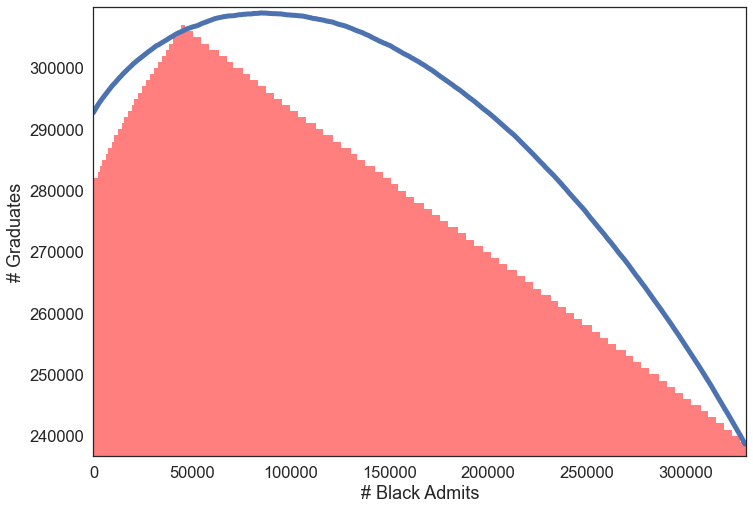

In [16]:
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="white", font_scale=1.5, )
ax = sns.lineplot(data=df_pareto, x='# Black Admits', y='# Graduates',linewidth=5)
errorboxes = []

for outcome_block in outcomes_grid:
    if outcome_block['policy_exists'] == 1:
        errorboxes.append(Rectangle((outcome_block['min_black_admits'] , outcome_block['min_graduates']),GRID_SIZE,GRID_SIZE))

pc = PatchCollection(errorboxes, facecolor='red', alpha=0.5,  edgecolor='none')
                       
ax.add_collection(pc)
plt.scatter(x=(df['R']*0.5).sum(),y=(df['Y']*0.5).sum(),color='green')   
plt.xlim([0, MAX_BLACK_ADMITS])
plt.ylim([df_pareto['# Graduates'].min()-2000, df_pareto['# Graduates'].max()+1000])
plt.show()


    
